In [1]:
import numpy as np
import dolfin as dl
from ufl import lhs, rhs, replace
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.linalg as sla
import matplotlib.pyplot as plt
from pathlib import Path
from nalger_helper_functions import *
import meshio
import sys
from scipy.spatial import KDTree as scipy_KDTree
from scipy.optimize import root_scalar
from localpsf import localpsf_root
from localpsf.newtoncg import newtoncg_ls, cgsteihaug
from nalger_helper_functions import *

import hlibpro_python_wrapper as hpro
from localpsf.product_convolution_kernel import ProductConvolutionKernel
from localpsf.product_convolution_hmatrix import make_hmatrix_from_kernel
from localpsf.derivatives_at_point import StokesDerivativesAtPoint
from localpsf.bilaplacian_regularization import BiLaplacianRegularization

# Options

In [2]:
# mesh_type = 'coarse'
# mesh_type = 'medium'
mesh_type = 'fine'
noise_level=1e-2
relative_prior_correlation_length=0.1
save_plots=True
gamma=1e4 # regularization gamma
m0_constant_value = 1.5 * 7.
rel_correlation_length = 0.1
reg_robin_bc=True
# mtrue_type = 'aces_building'
mtrue_type = 'angel_peak'
# mtrue_type = 'sinusoid'
# mtrue_string = 'm0 - (m0 / 7.)*std::cos((x[0]*x[0]+x[1]*x[1])*pi/(Radius*Radius))'
mtrue_string = 'm0 - (m0 / 7.)*std::cos(2.*x[0]*pi/Radius)'
solver_type = 'mumps'
# solver_type = 'default'
# solver_type = 'petsc'
# solver_type = 'umfpack'
# solver_type = 'superlu'
outflow_constant = 1.0e6

num_batches = 5 # number of batches used for Newton solves
tau = 3.0
num_neighbors = 10
hmatrix_tol = 1e-6
newton_rtol = 1e-8
# gamma_morozov = 15428.012899090285 # medium mesh, noise_level=1e-2
# gamma_morozov= 6932.714344119822 # fine mesh, noise_level=1e-2
# gamma_morozov= 6975.784285975133 # fine mesh, noise_level=1e-2
gamma_morozov = None
forcing_sequence_power = 0.5 # 1.0
num_gn_iter = 5

run_finite_difference_checks = False
check_gauss_newton_hessian = False

all_num_batches = [1, 5, 25] # number of batches used for spectral comparisons

In [3]:
save_dir = localpsf_root / 'numerical_examples' / 'stokes' / 'data'
save_dir.mkdir(parents=True, exist_ok=True)
save_dir_str = str(save_dir)

# Mesh

## Load unmodified mesh

In [4]:
if mesh_type == 'coarse':
    mfile_name = str(localpsf_root) + "/numerical_examples/stokes/meshes/cylinder_coarse"
    lam = 1e10
elif mesh_type == 'medium':
    mfile_name = str(localpsf_root) + "/numerical_examples/stokes/meshes/cylinder_medium"
    lam = 1e11
elif mesh_type == 'fine':
    mfile_name = str(localpsf_root) + "/numerical_examples/stokes/meshes/cylinder_fine"
    lam = 1e12
else:
    raise RuntimeError('invalid mesh type '+mesh_type+', valid types are coarse, medium, fine')
    
mesh = dl.Mesh(mfile_name+".xml")

mesh

## Boundary submeshes and subdomains

In [5]:
class BasalBoundary(dl.SubDomain):
    def inside(me, x, on_boundary):
        return dl.near(x[2], 0.) and on_boundary

class BasalBoundarySub(dl.SubDomain):
    def inside(me, x, on_boundary):
        return dl.near(x[2], 0.)

class TopBoundary(dl.SubDomain):
    def __init__(me, Height):
        me.Height = Height
        dl.SubDomain.__init__(me)
    def inside(me, x, on_boundary):
        return dl.near(x[1], me.Height) and on_boundary
    
boundary_markers = dl.MeshFunction("size_t", mesh, mfile_name+"_facet_region.xml")
boundary_mesh = dl.BoundaryMesh(mesh, "exterior", True)
basal_mesh3D = dl.SubMesh(boundary_mesh, BasalBoundarySub())

basal_mesh3D

## Modify mesh

In [6]:
r0 = 0.05
sig = 0.4
valleys = 4
valley_depth = 0.35
bump_height = 0.2
min_thickness = 0.08 / 8.
avg_thickness = 0.2 / 8.
theta = -np.pi / 2.
max_thickness = avg_thickness + (avg_thickness - min_thickness)
A_thickness = max_thickness - avg_thickness

dilitation = 1.e4
Length = 1.
Width = 1.
Length *= 2 * dilitation
Width *= 2 * dilitation
Radius = dilitation

prior_correlation_length = relative_prior_correlation_length * Radius

coords = mesh.coordinates()
bcoords = boundary_mesh.coordinates()
subbcoords = basal_mesh3D.coordinates()
coord_sets = [coords, bcoords, subbcoords]

def topography(r, t):
    zero = np.zeros(r.shape)
    R0 = r0 * np.ones(r.shape)
    return bump_height * np.exp(-(r / sig) ** 2) * (
                1. + valley_depth * np.sin(valleys * t - theta) * np.fmax(zero, (r - R0) / sig))

def depth(r, t):
    zero = np.zeros(r.shape)
    R0 = r0 * np.ones(r.shape)
    return min_thickness - A_thickness * np.sin(valleys * t - theta) * np.exp(
        -(r / sig) ** 2) * np.fmax(zero, (r - R0) / sig)

for k in range(len(coord_sets)):
    for i in range(len(coord_sets[k])):
        x, y, z = coord_sets[k][i]
        r = np.sqrt(x ** 2 + y ** 2)
        t = np.arctan2(y, x)
        coord_sets[k][i, 2] = depth(r, t) * z + topography(r, t)
        coord_sets[k][i] *= dilitation
        
mesh

In [7]:
basal_mesh3D

## 2D Basal mesh

Text(0.5, 1.0, '2D Basal Mesh')

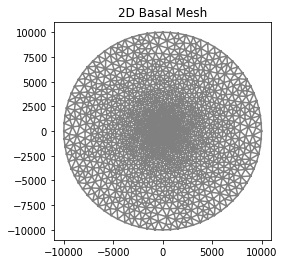

In [8]:
# ------ generate 2D mesh from 3D boundary subset mesh
coords = basal_mesh3D.coordinates()[:, :2]
cells = [("triangle", basal_mesh3D.cells())]
mesh2D = meshio.Mesh(coords, cells)
mesh2D.write("mesh2D.xml")
basal_mesh2D = dl.Mesh("mesh2D.xml")

dl.plot(basal_mesh2D)
plt.title('2D Basal Mesh')

# Plots to make (1): 
 - 3D mesh, colors, light mesh edges
 - 2D mesh top-view, edges only, black and white

In [9]:
# Save mesh
dl.File(save_dir_str + "/ice_mountain_mesh3D.xml") << mesh
dl.File(save_dir_str + "/ice_mountain_mesh_base3D.xml") << basal_mesh3D
dl.File(save_dir_str + "/ice_mountain_mesh_base2D.xml") << basal_mesh2D

# Function spaces

In [10]:
P1 = dl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
P2 = dl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
TH = P2 * P1

Zh = dl.FunctionSpace(mesh, TH)                     # Zh:  state, also adjoint
Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)          # Wh:  parameter, full 3D domain
Vh3 = dl.FunctionSpace(basal_mesh3D, 'Lagrange', 1) # Vh3: parameter, 2d basal manifold, 3d coords
Vh2 = dl.FunctionSpace(basal_mesh2D, 'Lagrange', 1) # Vh2: parameter, 2d basal flat space, 2d coords
Xh = [Zh, Wh, Zh]                                   # Xh:  (state, parameter full 3D domain, adjoint)

## Transfer operators between function spaces

In [11]:
def function_space_prolongate_numpy(x_numpy, dim_Yh, inds_Xh_in_Yh):
    y_numpy = np.zeros(dim_Yh)
    y_numpy[inds_Xh_in_Yh] = x_numpy
    return y_numpy

def function_space_restrict_numpy(y_numpy, inds_Xh_in_Yh):
    return y_numpy[inds_Xh_in_Yh].copy()

def function_space_prolongate_petsc(x_petsc, Yh, inds_Xh_in_Yh):
    y_petsc = dl.Function(Yh).vector()
    y_petsc[:] = function_space_prolongate_numpy(x_petsc[:], Yh.dim(), inds_Xh_in_Yh)
    return y_petsc

def function_space_restrict_petsc(y_petsc, Xh, inds_Xh_in_Yh):
    x_petsc = dl.Function(Xh).vector()
    x_petsc[:] = function_space_restrict_numpy(y_petsc[:], inds_Xh_in_Yh)
    return x_petsc

def make_prolongation_and_restriction_operators(Vsmall, Vbig, inds_Vsmall_in_Vbig):
    Vbig_to_Vsmall_numpy = lambda vb: function_space_restrict_numpy(vb, inds_Vsmall_in_Vbig)
    Vsmall_to_Vbig_numpy = lambda vs: function_space_prolongate_numpy(vs, Vbig.dim(), inds_Vsmall_in_Vbig)

    Vbig_to_Vsmall_petsc = lambda vb: function_space_restrict_petsc(vb, Vsmall, inds_Vsmall_in_Vbig)
    Vsmall_to_Vbig_petsc = lambda vs: function_space_prolongate_petsc(vs, Vbig, inds_Vsmall_in_Vbig)

    return Vbig_to_Vsmall_numpy, Vsmall_to_Vbig_numpy, Vbig_to_Vsmall_petsc, Vsmall_to_Vbig_petsc

In [12]:
pp_Vh3 = Vh3.tabulate_dof_coordinates()
pp_Vh2 = Vh2.tabulate_dof_coordinates()
pp_Wh = Wh.tabulate_dof_coordinates()

KDT_Wh = scipy_KDTree(pp_Wh)
inds_Vh3_in_Wh = KDT_Wh.query(pp_Vh3)[1]
if np.linalg.norm(pp_Vh3 - pp_Wh[inds_Vh3_in_Wh, :]) / np.linalg.norm(pp_Vh3) > 1.e-12:
    warnings.warn('problem with basal function space inclusion')

pp_Vh3_2D = pp_Vh3[:,:2]

KDT_Vh3_2D = scipy_KDTree(pp_Vh3_2D)
inds_Vh2_in_Vh3 = KDT_Vh3_2D.query(pp_Vh2)[1]
if np.linalg.norm(pp_Vh2 - pp_Vh3[inds_Vh2_in_Vh3, :2]) / np.linalg.norm(pp_Vh2) > 1.e-12:
    warnings.warn('inconsistency between manifold basal mesh and flat basal mesh')

inds_Vh2_in_Wh = inds_Vh3_in_Wh[inds_Vh2_in_Vh3]

Wh_to_Vh3_numpy, Vh3_to_Wh_numpy, Wh_to_Vh3_petsc, Vh3_to_Wh_petsc = \
    make_prolongation_and_restriction_operators(Vh3, Wh, inds_Vh3_in_Wh)

Vh3_to_Vh2_numpy, Vh2_to_Vh3_numpy, Vh3_to_Vh2_petsc, Vh2_to_Vh3_petsc = \
    make_prolongation_and_restriction_operators(Vh2, Vh3, inds_Vh2_in_Vh3)

Wh_to_Vh2_numpy, Vh2_to_Wh_numpy, Wh_to_Vh2_petsc, Vh2_to_Wh_petsc = \
    make_prolongation_and_restriction_operators(Vh2, Wh, inds_Vh2_in_Wh)

# Forward Stokes forms

In [13]:
m_Wh = dl.Function(Wh) # Basal sliding friction
u = dl.Function(Zh) # Stokes state: (velocity, pressure)
p = dl.Function(Zh) # Stokes adjoint variable

mtrue_Wh = dl.Function(Wh) # True parameter
utrue = dl.Function(Zh) # True state
uobs = dl.Function(Zh) # observed state (true state plus noise)

grav  = 9.81           # acceleration due to gravity
rho   = 910.0          # volumetric mass density of ice
stokes_forcing = dl.Constant( (0., 0., -rho*grav) )

ds = dl.Measure("ds", domain=mesh, subdomain_data=boundary_markers)
ds = ds
ds_base = ds(1)
ds_top = ds(2)
ds_lateral = ds(3)
normal = dl.FacetNormal(mesh)
# Strongly enforced Dirichlet conditions. The no outflow condition will be enforced weakly, via penalty parameter.
bcs  = []
bcs0 = []

# Define the Nonlinear Stokes varfs
# rheology
stokes_n = 1.0
stokes_A = dl.Constant(2.140373e-7) # dl.Constant(1.e-16)
smooth_strain = dl.Constant(1e-6)

velocity, pressure = dl.split(u)
strain_rate = dl.sym(dl.grad(velocity))
normEu12 = 0.5 * dl.inner(strain_rate, strain_rate) + smooth_strain

tangent_velocity = (velocity - dl.outer(normal, normal)*velocity)

energy_t1 = stokes_A ** (-1.) * normEu12 * dl.dx 
energy_t2 = -dl.inner(stokes_forcing, velocity) * dl.dx 
energy_t3 = dl.Constant(.5) * dl.inner(dl.exp(m_Wh) * tangent_velocity, tangent_velocity) * ds_base
energy_t4 = lam * dl.inner(velocity, normal) ** 2 * ds_base

energy_t5 = dl.Constant(outflow_constant) * dl.inner(velocity, normal)**2 * ds_lateral # Side outflow Robin BC

energy = energy_t1 + energy_t2 + energy_t3 + energy_t4 + energy_t5
energy_gradient = dl.derivative(energy, u, p)

adjoint_velocity, adjoint_pressure = dl.split(p)
div_constraint           = dl.inner(-dl.div(velocity),         adjoint_pressure) * dl.dx
div_constraint_transpose = dl.inner(-dl.div(adjoint_velocity), pressure)         * dl.dx

forward_form_ff = energy_gradient + div_constraint + div_constraint_transpose # A(u,v) + B(u,z) + B(v,p)

# Misfit forms

In [14]:
def Tang(vel, n):
    return vel - dl.outer(n, n)*vel

dummy_u1 = dl.Function(Zh)
dummy_u2 = dl.Function(Zh)

dummy_velocity1, dummy_pressure1 = dl.split(dummy_u1) 
dummy_velocity2, dummy_pressure2 = dl.split(dummy_u2)

data_inner_product_form = dl.inner(Tang(dummy_velocity1, normal), 
                                   Tang(dummy_velocity2, normal))*ds_top

def data_inner_product(u_petsc, v_petsc):
    dummy_u1.vector()[:] = u_petsc[:]
    dummy_u2.vector()[:] = v_petsc[:]
    return dl.assemble(data_inner_product_form)

true_velocity, true_pressure = dl.split(utrue)
observed_velocity, observed_pressure = dl.split(uobs)

velocity_discrepancy = observed_velocity - velocity

misfit_form = 0.5*dl.inner(Tang(velocity_discrepancy, normal), 
                           Tang(velocity_discrepancy, normal))*ds_top

# Lagrangian, adjoint, gradient, hessian

In [15]:
def input_vector_transformation(m_Vh2_numpy):
    m_Vh2_petsc = dl.Function(Vh2).vector()
    m_Vh2_petsc[:] = m_Vh2_numpy
    return Vh2_to_Wh_petsc(m_Vh2_petsc)

def output_vector_transformation(m_Wh_petsc):
    m_Vh2_numpy = Wh_to_Vh2_petsc(m_Wh_petsc)[:]
    return m_Vh2_numpy

SDAP = StokesDerivativesAtPoint(misfit_form, forward_form_ff, bcs,
                                m_Wh, u, p,
                                input_vector_transformation,
                                output_vector_transformation,
                                solver_type=solver_type)

# Solve for true observations

Text(0.5, 1.0, 'mtrue_Vh2')

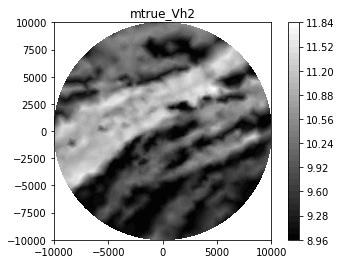

In [16]:
if mtrue_type == 'angel_peak' or mtrue_type == 'aces_building':
    image_dir = localpsf_root / 'localpsf'

    if mtrue_type == 'angel_peak':
#         image_file = image_dir / 'angel_peak_badlands_cropped9.png' # good
        image_file = image_dir / 'angel_peak_badlands_cropped7.png'
    else:
        image_file = image_dir / 'aces_building.png'
        
    mtrue_Vh2 = load_image_into_fenics(Vh2, image_file)
    minc = 9
    maxc = 12
    mtrue_Vh2_vec = mtrue_Vh2.vector()[:]
    mtrue_Vh2_vec *= 3
    mtrue_Vh2_vec += 9
    mtrue_Vh2.vector()[:] = mtrue_Vh2_vec
elif mtrue_type == 'sinusoid':
    mtrue_expr = dl.Expression(mtrue_string, element=Vh2.ufl_element(), m0=m0_constant_value, Radius=Radius)
    mtrue_Vh2 = dl.interpolate(mtrue_expr, Vh2)
else:
    raise RuntimeError('BAD mtrue_type')
        

mtrue_Vh3 = dl.Function(Vh3)
mtrue_Vh3.vector()[:] = Vh2_to_Vh3_numpy(mtrue_Vh2.vector()[:])

cm = dl.plot(mtrue_Vh2, cmap='gray')
plt.colorbar(cm)
plt.title('mtrue_Vh2')

In [17]:
SDAP.update_m(mtrue_Vh2.vector()[:])
SDAP.update_forward()
utrue.vector()[:] = SDAP.u.vector()[:].copy()

# Plots to make (2):
 - True velocity (arrows or not, up to you)
 - mtrue (basal sliding friction field)

In [18]:
dl.File(save_dir_str + "/mtrue_Vh2.pvd") << mtrue_Vh2
dl.File(save_dir_str + "/mtrue_Vh3.pvd") << mtrue_Vh3

dl.File(save_dir_str + "/true_velocity" + str(outflow_constant)+".pvd") << utrue.sub(0)
dl.File(save_dir_str + "/true_pressure" + str(outflow_constant)+".pvd") << utrue.sub(1)

# Add noise

In [19]:
utrue_vec = utrue.vector()[:]
noise_vec = noise_level * np.random.randn(Zh.dim()) * np.abs(utrue_vec)
uobs.vector()[:] = utrue_vec + noise_vec

In [20]:
def compute_misfit_datanorm():
    return np.sqrt(2.0 * SDAP.misfit())

noise_vec_petsc = dl.Function(Zh).vector()
noise_vec_petsc[:] = noise_vec
noise_datanorm = np.sqrt(data_inner_product(noise_vec_petsc, noise_vec_petsc))
print('noise_datanorm=', noise_datanorm)

noise_datanorm= 866.2663059032905


# Regularization

In [21]:
m_prior_mean_Vh2 = dl.Function(Vh2)
m_prior_mean_Vh2.vector()[:] = m0_constant_value * np.ones(Vh2.dim())
m_Vh2 = dl.Function(Vh2)
m_Vh2.vector()[:] = Wh_to_Vh2_numpy(m_Wh.vector()[:])

REG = BiLaplacianRegularization(gamma, prior_correlation_length, m_Vh2, m_prior_mean_Vh2)

/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/coo.py:431: SparseEfficiencyWarning: Constructing a DIA matrix with 1416 diagonals is inefficient
  warn("Constructing a DIA matrix with %d diagonals "


In [22]:
REG.update_gamma(1e5)
REG.update_correlation_length(prior_correlation_length)

Text(0.5, 1.0, 'random smooth function')

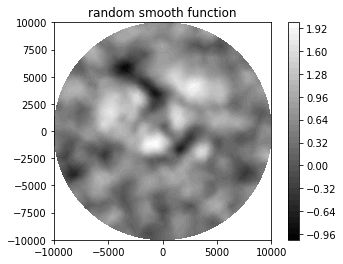

In [23]:
def random_smooth_Vh2_function(min_f, max_f):
    f_vec = REG.solve_R_numpy(np.random.randn(Vh2.dim()))
    f_vec = f_vec - np.min(f_vec)
    f_vec = (max_f - min_f) * f_vec / np.max(f_vec)
    f_vec = f_vec + min_f
    f = dl.Function(Vh2)
    f.vector()[:] = f_vec
    return f

random_smooth = random_smooth_Vh2_function(-1.0, 2.0)

cm = dl.plot(random_smooth, cmap='gray')
plt.colorbar(cm)
plt.title('random smooth function')

In [24]:
def update_m(new_m_Vh2_numpy):
    SDAP.update_m(new_m_Vh2_numpy)
    REG.parameter.vector()[:] = new_m_Vh2_numpy

def cost():
    return SDAP.misfit() + REG.cost()

def gradient():
    return SDAP.gradient() + REG.gradient_numpy()

def apply_hessian(z_Vh2_numpy):
    return SDAP.apply_hessian(z_Vh2_numpy) + REG.apply_hessian_numpy(z_Vh2_numpy)

def apply_gauss_newton_hessian(z_Vh2_numpy):
    return SDAP.apply_gauss_newton_hessian(z_Vh2_numpy) + REG.apply_hessian_numpy(z_Vh2_numpy)

# Finite difference check

Text(0.5, 1.0, 'dm_Vh2')

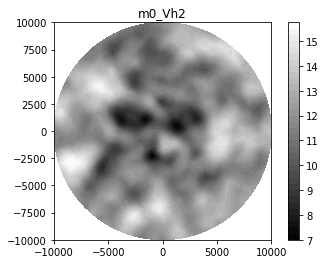

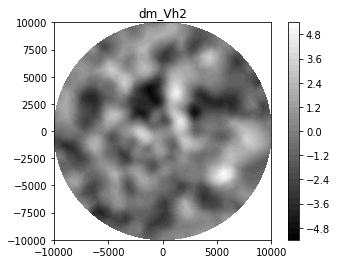

In [25]:
m0_Vh2 = random_smooth_Vh2_function(m0_constant_value/1.5, m0_constant_value*1.5)
plt.figure()
cm = dl.plot(m0_Vh2, cmap='gray')
plt.colorbar(cm)
plt.title('m0_Vh2')

plt.figure()
dm_Vh2 = random_smooth_Vh2_function(-m0_constant_value/2.0, m0_constant_value/2.0)
cm = dl.plot(dm_Vh2, cmap='gray')
plt.colorbar(cm)
plt.title('dm_Vh2')

In [26]:
if run_finite_difference_checks:
    m0_Vh2_numpy = m0_Vh2.vector()[:]
    dm_Vh2_numpy = dm_Vh2.vector()[:]

    update_m(m0_Vh2_numpy)
    J0_d = SDAP.misfit()
    g0_d = SDAP.gradient()
    H0dm_d = SDAP.apply_hessian(dm_Vh2_numpy)

    J0_r = REG.cost()
    g0_r = REG.gradient_numpy()
    H0dm_r = REG.apply_hessian_numpy(dm_Vh2_numpy)

    J0 = cost()
    g0 = gradient()
    H0dm = apply_hessian(dm_Vh2_numpy)

    # ss = [1e-6]
    ss = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
    errs_grad_d = []
    errs_hess_d = []
    errs_grad_r = []
    errs_hess_r = []
    errs_grad = []
    errs_hess = []
    for s in ss:
        m1_Vh2_numpy = m0_Vh2_numpy + s * dm_Vh2_numpy
        update_m(m1_Vh2_numpy)
        J1_d = SDAP.misfit()
        g1_d = SDAP.gradient()
#         H1dm_d = SDAP.apply_hessian(dm_Vh2_numpy)

        J1_r = REG.cost()
        g1_r = REG.gradient_numpy()
#         H1dm_r = REG.apply_hessian_numpy(dm_Vh2_numpy)

        J1 = cost()
        g1 = gradient()
#         H1dm = apply_hessian(dm_Vh2_numpy)

        # Gradient

        dJ_diff_d = (J1_d - J0_d) / s
        dJ_d = np.dot(g0_d, dm_Vh2_numpy)
        err_grad_d = np.abs(dJ_diff_d - dJ_d) / np.abs(dJ_diff_d)
        errs_grad_d.append(err_grad_d)

        dJ_diff_r = (J1_r - J0_r) / s
        dJ_r = np.dot(g0_r, dm_Vh2_numpy)
        err_grad_r = np.abs(dJ_diff_r - dJ_r) / np.abs(dJ_diff_r)
        errs_grad_r.append(err_grad_r)

        dJ_diff = (J1 - J0) / s
        dJ = np.dot(g0, dm_Vh2_numpy)
        err_grad = np.abs(dJ_diff - dJ) / np.abs(dJ_diff)
        errs_grad.append(err_grad)

        # Hessian

        dg_diff_d = (g1_d - g0_d) / s
        err_hess_d = np.linalg.norm(dg_diff_d - H0dm_d) / np.linalg.norm(dg_diff_d)
        errs_hess_d.append(err_hess_d)

        dg_diff_r = (g1_r - g0_r) / s
        err_hess_r = np.linalg.norm(dg_diff_r - H0dm_r) / np.linalg.norm(dg_diff_r)
        errs_hess_r.append(err_hess_r)

        dg_diff = (g1 - g0) / s
        err_hess = np.linalg.norm(dg_diff - H0dm) / np.linalg.norm(dg_diff)
        errs_hess.append(err_hess)

        print('s=', s)
        print('err_grad_d=', err_grad_d, ', err_grad_r=', err_grad_r, ', err_grad=', err_grad)
        print('err_hess_d=', err_hess_d, ', err_hess_r=', err_hess_r, ', err_hess=', err_hess)

    ss = np.array(ss)
    errs_grad_d = np.array(errs_grad_d)
    errs_hess_d = np.array(errs_hess_d)
    errs_grad_r = np.array(errs_grad_r)
    errs_hess_r = np.array(errs_hess_r)
    errs_grad = np.array(errs_grad)
    errs_hess = np.array(errs_hess)

    plt.figure()
    plt.loglog(ss, errs_grad_d)
    plt.loglog(ss, errs_hess_d)
    plt.title('finite difference check for misfit')
    plt.xlabel('step size s')
    plt.ylabel('error')
    plt.legend(['misfit gradient', 'misfit hessian'])

    plt.figure()
    plt.loglog(ss, errs_grad_r)
    plt.loglog(ss, errs_hess_r)
    plt.title('finite difference check for regularization')
    plt.xlabel('step size s')
    plt.ylabel('error')
    plt.legend(['regularization gradient', 'regularization hessian'])

    plt.figure()
    plt.loglog(ss, errs_grad)
    plt.loglog(ss, errs_hess)
    plt.title('finite difference check for overall cost')
    plt.xlabel('step size s')
    plt.ylabel('error')
    plt.legend(['gradient', 'hessian'])

# Check Gauss-Newton Hessian

In [27]:
if check_gauss_newton_hessian:
    m0_Vh2_numpy = m0_Vh2.vector()[:]
    
    uobs_vec_backup = uobs.vector()[:].copy()
    uobs.vector()[:] = utrue.vector()[:].copy()

    update_m(mtrue_Vh2.vector()[:].copy())

    z_Vh2_numpy = random_smooth_Vh2_function(-m0_constant_value/2.0, m0_constant_value/2.0).vector()[:]

    Hz = SDAP.apply_hessian(z_Vh2_numpy)
    HGNz = SDAP.apply_gauss_newton_hessian(z_Vh2_numpy)

    GN_discrepancy_at_truth_nonoise = np.linalg.norm(Hz - HGNz) / np.linalg.norm(Hz)
    print('GN_discrepancy_at_truth_nonoise=', GN_discrepancy_at_truth_nonoise)

    update_m(m0_Vh2_numpy)

    Hz = SDAP.apply_hessian(z_Vh2_numpy)
    HGNz = SDAP.apply_gauss_newton_hessian(z_Vh2_numpy)

    GN_discrepancy_elsewhere_nonoise = np.linalg.norm(Hz - HGNz) / np.linalg.norm(Hz)
    print('GN_discrepancy_elsewhere_nonoise=', GN_discrepancy_elsewhere_nonoise)


    uobs.vector()[:] = uobs_vec_backup

    update_m(mtrue_Vh2.vector()[:].copy())
    Hz = SDAP.apply_hessian(z_Vh2_numpy)
    HGNz = SDAP.apply_gauss_newton_hessian(z_Vh2_numpy)

    GN_discrepancy_at_truth_yesnoise = np.linalg.norm(Hz - HGNz) / np.linalg.norm(Hz)
    print('GN_discrepancy_at_truth_yesnoise=', GN_discrepancy_at_truth_yesnoise)

    update_m(m0_Vh2_numpy)
    Hz = SDAP.apply_hessian(z_Vh2_numpy)
    HGNz = SDAP.apply_gauss_newton_hessian(z_Vh2_numpy)

    GN_discrepancy_elsewhere_yesnoise = np.linalg.norm(Hz - HGNz) / np.linalg.norm(Hz)
    print('GN_discrepancy_elsewhere_yesnoise=', GN_discrepancy_elsewhere_yesnoise)

    #
    
    SDAP.update_m(m0_Vh2_numpy)
    SDAP.update_forward()

    p_Vh2_numpy = random_smooth_Vh2_function(-m0_constant_value/2.0, m0_constant_value/2.0).vector()[:]
    q_Vh2_numpy = random_smooth_Vh2_function(-m0_constant_value/2.0, m0_constant_value/2.0).vector()[:]

    SDAP.update_z(p_Vh2_numpy)
    SDAP.update_incremental_forward()
    du_dm_p = dl.Function(Zh)
    du_dm_p.vector()[:] = SDAP.du_dm_z.vector()[:].copy()

    SDAP.update_z(q_Vh2_numpy)
    SDAP.update_incremental_forward()
    du_dm_q = dl.Function(Zh)
    du_dm_q.vector()[:] = SDAP.du_dm_z.vector()[:].copy()

    C1 = data_inner_product(du_dm_p.vector(), du_dm_q.vector())

    Hgn_p = SDAP.apply_gauss_newton_hessian(p_Vh2_numpy)
    C2 = np.dot(q_Vh2_numpy, Hgn_p)

    gauss_newton_error = np.abs(C1 - C2) / np.abs(C1)

    print('gauss_newton_error=', gauss_newton_error)

In [97]:
def apply_misfit_gauss_newton_hessian_petsc(u_petsc):
    v = dl.Function(Vh2).vector()
    v[:] = SDAP.apply_gauss_newton_hessian(u_petsc[:])
    return v

class PCHWrapper:
    def __init__(me, do_updates=False):
        me.do_updates = do_updates
        
        me.PCK = None
        me.Hd_pch = None
        me.R_hmatrix = None
        me.H_pch = None
        me.preconditioner = None

    def build(me):
        me._make_Hd_hmatrix()
        me._make_reg_hmatrix()
        me._make_pre_hmatrix()
        
    def _make_pre_hmatrix(me):
        me.H_pch = me.Hd_pch + me.R_hmatrix
        me.preconditioner = me.H_pch.factorized_inverse()
        
    def _make_Hd_hmatrix(me):
        print('building PCH preconditioner')
        me.PCK = ProductConvolutionKernel(Vh2, Vh2, 
                                          apply_misfit_gauss_newton_hessian_petsc, 
                                          apply_misfit_gauss_newton_hessian_petsc,
                                          num_batches, num_batches,
                                          tau_rows=tau, tau_cols=tau,
                                          num_neighbors_rows=num_neighbors,
                                          num_neighbors_cols=num_neighbors)
        Hd_pch_nonsym, extras = make_hmatrix_from_kernel(me.PCK, hmatrix_tol=hmatrix_tol)
        me.Hd_pch = Hd_pch_nonsym.spd()
        
    def _make_reg_hmatrix(me):
        print('Building Regularization H-Matrix')
        me.R_hmatrix = REG.make_R_hmatrix(me.Hd_pch.bct, rtol=1e-6)
        
    def update_reg(me):
        if me.Hd_pch is None:
            me._make_Hd_hmatrix()
        me._make_reg_hmatrix()
        me._make_pre_hmatrix()
        
    def update_Hd(me):
        me._make_Hd_hmatrix()
        if me.R_hmatrix is None:
            me._make_reg_hmatrix()
        me._make_pre_hmatrix()
        
    
    def low_rank_update(me, xx, yy):
        if me.do_updates and (me.preconditioner_hmatrix is not None):
            pass
            #             me.preconditioner_hmatrix = me.preconditioner_hmatrix.dfp_update(np.array(yy).T, np.array(xx).T)

    def solve(me, u_Vh2_numpy):
        if me.preconditioner is None:
#             return REG.solve_hessian_numpy(u_Vh2_numpy)
            return u_Vh2_numpy
        else:
            return me.preconditioner.matvec(u_Vh2_numpy)
    
    def reset(me):
        me.PCK = None
        me.Hd_pch = None
        me.R_hmatrix = None
        me.H_pch = None
        me.preconditioner = None
    

In [98]:
REG.update_gamma(1e4)

get_optimization_variable = lambda : Wh_to_Vh2_numpy(m_Wh.vector()[:])
set_optimization_variable = update_m
cost_triple = lambda : [cost(), SDAP.misfit(), REG.cost()]
build_nothing = lambda : None
update_nothing = lambda X, Y: None

/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [99]:
PCH1 = PCHWrapper(do_updates=False)

def morozov_helper():
    misfit_datanorm = np.sqrt(2.0 * SDAP.misfit())
    print('gamma=', REG.gamma, ', noise_datanorm=', noise_datanorm, ', misfit_datanorm=', misfit_datanorm)
    return misfit_datanorm
    
morozov_gammas = list()
morozov_discrepancies = list()

def log_morozov_function(log_gamma):
    gamma = np.exp(log_gamma)
    print()
    print('-------- gamma=', gamma, ' --------')
    REG.update_gamma(gamma)
    
    preconditioner_build_iters = (3,)
    if PCH1.preconditioner is None:
        preconditioner_build_iters = (3,)
    else:
        PCH1.update_reg()
        preconditioner_build_iters = tuple([])
    
    update_m(m0_constant_value * np.ones(Vh2.dim()))
    newtoncg_ls(get_optimization_variable, 
                set_optimization_variable, 
                cost_triple, 
                gradient, 
                apply_hessian, 
                apply_gauss_newton_hessian, 
                PCH1.build,
                update_nothing, 
                PCH1.solve,
                preconditioner_build_iters = preconditioner_build_iters,
                rtol=newton_rtol,
                forcing_sequence_power=forcing_sequence_power)
    
    misfit_datanorm = morozov_helper()
    morozov_gammas.append(gamma)
    morozov_discrepancies.append(misfit_datanorm)
    
    log_mismatch = np.log(noise_datanorm) - np.log(misfit_datanorm)
    return log_mismatch

if gamma_morozov is None:
    sol_morozov = root_scalar(log_morozov_function, x0=np.log(5e3), x1=np.log(5e4))
    print(sol_morozov)
    gamma_morozov = np.exp(sol_morozov.root)
    print('gamma_morozov=', gamma_morozov)

REG.update_gamma(gamma_morozov)

# Plots to make (3):
 - Morozov discrepancy log-log plot

morozov_gammas= [ 5000.          5774.86476799  6344.50318043  7266.77474578
  7285.1582313   7285.48465351  7285.48829713  7476.08321631
 50000.        ]
morozov_discrepancies= [ 805.55463841  824.34302485  839.37764994  865.70833707  866.25658052
  866.26619855  866.2663068   872.00007074 2572.87233884]
noise_datanorm= 866.2663059032905


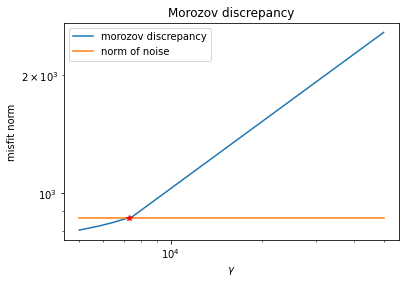

In [31]:
morozov_gammas = np.array(morozov_gammas)
morozov_discrepancies = np.array(morozov_discrepancies)

sort_inds = np.argsort(morozov_gammas)
morozov_gammas = morozov_gammas[sort_inds]
morozov_discrepancies = morozov_discrepancies[sort_inds]

print('morozov_gammas=', morozov_gammas)
print('morozov_discrepancies=', morozov_discrepancies)
print('noise_datanorm=', noise_datanorm)

np.savetxt(save_dir_str + '/morozov_gammas.txt', morozov_gammas)
np.savetxt(save_dir_str + '/morozov_discrepancies.txt', morozov_discrepancies)
np.savetxt(save_dir_str + '/noise_datanorm.txt', np.array([noise_datanorm]))

plt.figure()
plt.loglog(morozov_gammas, morozov_discrepancies)
plt.loglog(morozov_gammas, noise_datanorm*np.ones(len(morozov_gammas)))
plt.plot(gamma_morozov, noise_datanorm, '*r')
plt.title('Morozov discrepancy')
plt.xlabel(r'$\gamma$')
plt.ylabel('misfit norm')
plt.legend(['morozov discrepancy', 'norm of noise'])

# Newton Solve with PCH preconditioning

/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.947e+07
||M r0|| = 1.947e+07
(M r0, r0) = 1.947e+07
 Iteration :  0  (r, r) =  379080272233562.7
 Iteration :  1  (r, r) =  42697972707314.5
Relative/Absolute residual less than tol
Converged in  1  iterations with final norm  6534368.57755319

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in 

  0%|          | 0/5 [00:00<?, ?it/s]

Making row and column cluster treesUsing ProductConvolutionKernelRBFColsOnly!

Making block cluster trees
Building A kernel hmatrix
Making input and output mass matrix hmatrices━━ building H-matrix ( tol = 
Computing A_hmatrix = M_out_hmatrix * A_kernel_hmatrix * M_in_hmatrix
making hmatrix spd
symmetrizing
1e-06 )
            getting smallest eigenvalue with Lanczos9 s (5.97 GB) 
    done in 11.36s                                               
    size of H-matrix = 4.42 MB
lambda_min= -34617.2416808737                                    
scaling_at_lambda_min= 0.9878048780487805
scaling_at_zero= 0.5
Setting up operator T = (2*A - (b+a) I) / (b-a)
computing T^(2^k)
computing T^(2^1) = T^(2^0) * T^(2^0)

computing T^(2^2) = T^(2^1) * T^(2^1)
━━ H-matrix multiplication C=A*B 
    done in 27.99s                                                
    size of C = 5.30 MB
                                                                 
━━ H-matrix multiplication C=A*B 
    done in 29.52s    

Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 3.447e+03
||M r0|| = 1.716e-01
(M r0, r0) = 1.291e+01
 Iteration :  0  (r, r) =  11878434.113574648
 Iteration :  1  (r, r) =  4474880.982629124
 Iteration :  2  (r, r) =  1872726.960222972
 Iteration :  3  (r, r) =  809375.4932472149
 Iteration :  4  (r, r) =  272196.92355099245
 Iteration :  5  (r, r) =  104684.54787575048
 Iteration :  6  (r, r) =  34588.14858958904
 Iteration :  7  (r, r) =  15821.076784170593
 Iteration :  8  (r, r) =  7131.601675672953
 Iteration :  9  (r, r) =  2807.591657953455
 Iteration :  10  (r, r) =  687.1484048159077
Relative/Absolute residual less than tol
Converged in  10  iterations with final norm  26.213515689733565

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g ->

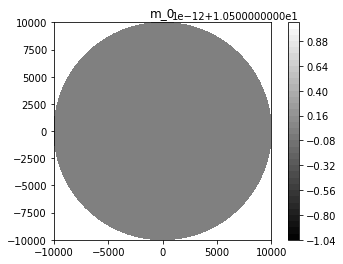

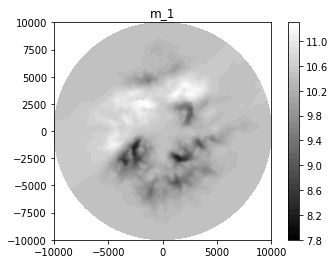

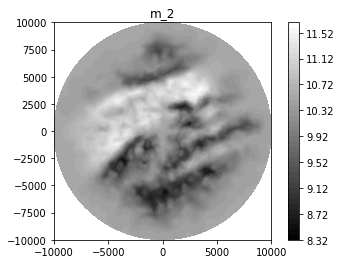

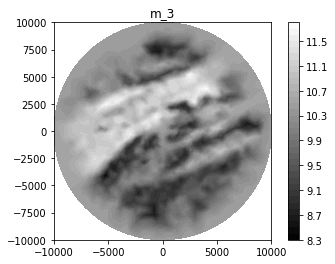

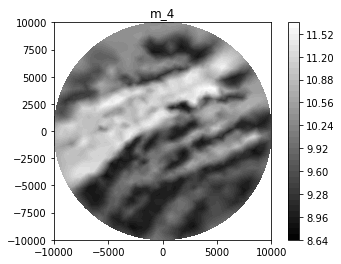

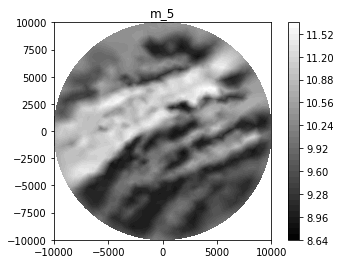

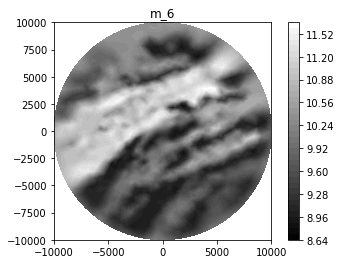

In [115]:
PCH1 = PCHWrapper(do_updates=False)
REG.update_gamma(gamma_morozov)
update_m(m0_constant_value * np.ones(Vh2.dim()))

iter_PCH = list()
m_iter_PCH = list()
def PCH_callback(it, m_Vh2_numpy):
    iter_PCH.append(it)
    m_iter_PCH.append(m_Vh2_numpy)
    m_Vh2 = dl.Function(Vh2)
    m_Vh2.vector()[:] = m_Vh2_numpy
    plt.figure()
    cm = dl.plot(m_Vh2, cmap='gray')
    plt.colorbar(cm)
    plt.title('m_'+str(it))

PCH_convergence_info = newtoncg_ls(get_optimization_variable, 
                                   set_optimization_variable, 
                                   cost_triple, 
                                   gradient, 
                                   apply_hessian, 
                                   apply_gauss_newton_hessian, 
                                   PCH1.build,
                                   update_nothing, 
                                   PCH1.solve,
                                   callback=PCH_callback,
                                   preconditioner_build_iters = (3,),
                                   rtol=newton_rtol,
                                   num_gn_iter=num_gn_iter,
                                   forcing_sequence_power=forcing_sequence_power)

misfit_datanorm = morozov_helper()

In [116]:
misfit_datanorm = np.sqrt(2.0 * SDAP.misfit())
print('noise_datanorm=', noise_datanorm, ', misfit_datanorm=', misfit_datanorm)

noise_datanorm= 866.2663059032905 , misfit_datanorm= 866.2663070330523


# Newton solve with regularization preconditioning

using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.947e+07
||M r0|| = 1.188e+05
(M r0, r0) = 1.395e+06
 Iteration :  0  (r, r) =  379080272233562.7
 Iteration :  1  (r, r) =  60675735182973.14
Relative/Absolute residual less than tol
Converged in  1  iterations with final norm  7789463.08695106

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in

using Gauss-Newton Hessian
it= 4 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 4.777e+05
||M r0|| = 1.024e+03
(M r0, r0) = 1.638e+04
 Iteration :  0  (r, r) =  228191019738.32993
 Iteration :  1  (r, r) =  180951663042.56674
 Iteration :  2  (r, r) =  160057076789.6305
 Iteration :  3  (r, r) =  145615663334.65796
 Iteration :  4  (r, r) =  139513533724.4741
 Iteration :  5  (r, r) =  134378052641.08775
 Iteration :  6  (r, r) =  130933093684.52377
 Iteration :  7  (r, r) =  129393801989.94313
 Iteration :  8  (r, r) =  130944968466.86563
 Iteration :  9  (r, r) =  117809634086.29166
 Iteration :  10  (r, r) =  105226159576.71451
 Iteration :  11  (r, r) =  97647725059.27007
 Iteration :  12  (r, r) =  84154081915.09993
 Iteration :  13  (r, r) =  88581140609.496
 Iteration :  14  (r, r) =  80975972416.5255
 Iteration :  15  (r, r) =  74587351567.33011
 Iteration :  16  (r, r) =  52679619495.5446

 Iteration :  80  (r, r) =  33346875.902317323
 Iteration :  81  (r, r) =  28922381.53134571
 Iteration :  82  (r, r) =  24623933.87344162
 Iteration :  83  (r, r) =  23775353.77607508
 Iteration :  84  (r, r) =  21758765.286283165
Relative/Absolute residual less than tol
Converged in  84  iterations with final norm  4664.629169214115

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      number of gradient evaluations in Newton iteration
nH

 Iteration :  120  (r, r) =  7744.741912211784
 Iteration :  121  (r, r) =  7885.099832996716
 Iteration :  122  (r, r) =  6953.965117032138
 Iteration :  123  (r, r) =  6636.980952927988
 Iteration :  124  (r, r) =  6819.651003821874
 Iteration :  125  (r, r) =  6276.818612755485
Relative/Absolute residual less than tol
Converged in  125  iterations with final norm  79.22637573911535

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in Newton iteration
nG:      nu

 Iteration :  117  (r, r) =  6.157566042544039
 Iteration :  118  (r, r) =  5.897782551673358
 Iteration :  119  (r, r) =  5.2243741177517125
 Iteration :  120  (r, r) =  5.113370561687472
 Iteration :  121  (r, r) =  5.275312653544157
 Iteration :  122  (r, r) =  4.334236314400004
 Iteration :  123  (r, r) =  4.589076980358733
 Iteration :  124  (r, r) =  4.077265570250519
 Iteration :  125  (r, r) =  4.645165594396849
 Iteration :  126  (r, r) =  4.141211732783078
 Iteration :  127  (r, r) =  3.688116629703075
 Iteration :  128  (r, r) =  3.5178823147875455
 Iteration :  129  (r, r) =  2.957049970694025
 Iteration :  130  (r, r) =  2.5499331484316903
 Iteration :  131  (r, r) =  2.4492961715643427
 Iteration :  132  (r, r) =  2.497415593776382
 Iteration :  133  (r, r) =  1.8242694618877429
 Iteration :  134  (r, r) =  1.7615824541087355
 Iteration :  135  (r, r) =  1.4468172483982857
 Iteration :  136  (r, r) =  1.30303016795511
 Iteration :  137  (r, r) =  1.2046492670279023
 Itera

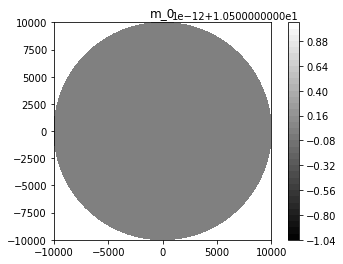

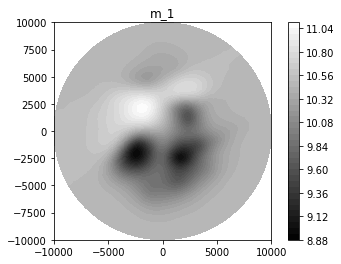

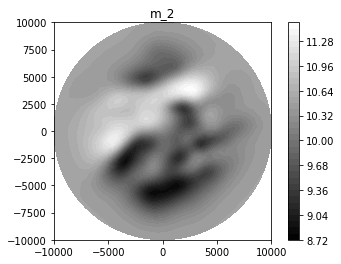

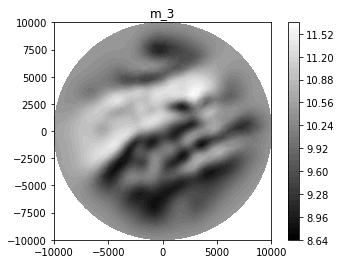

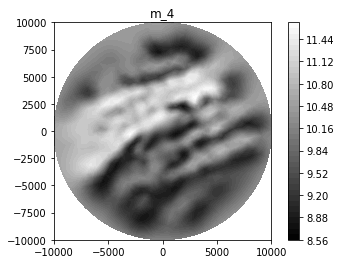

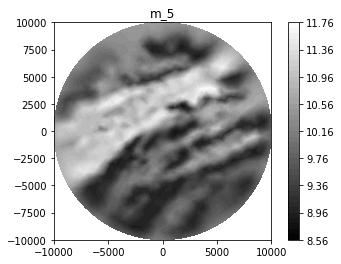

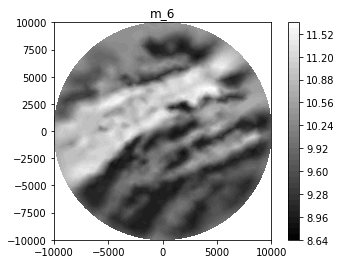

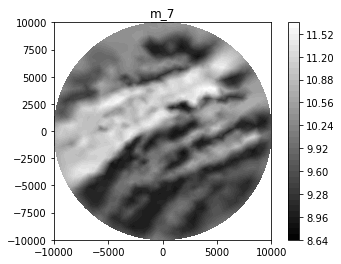

In [117]:
update_m(m0_constant_value * np.ones(Vh2.dim()))
REG.update_gamma(gamma_morozov)

iter_REG = list()
m_iter_REG = list()
def REG_callback(it, m_Vh2_numpy):
    iter_REG.append(it)
    m_iter_REG.append(m_Vh2_numpy)
    m_Vh2 = dl.Function(Vh2)
    m_Vh2.vector()[:] = m_Vh2_numpy
    plt.figure()
    cm = dl.plot(m_Vh2, cmap='gray')
    plt.colorbar(cm)
    plt.title('m_'+str(it))

REG_convergence_info = newtoncg_ls(get_optimization_variable, 
                                   set_optimization_variable, 
                                   cost_triple, 
                                   gradient, 
                                   apply_hessian, 
                                   apply_gauss_newton_hessian, 
                                   build_nothing, 
                                   update_nothing, 
                                   REG.solve_hessian_numpy,
                                   callback=REG_callback,
                                   rtol=newton_rtol,
                                   num_gn_iter=num_gn_iter,
                                   forcing_sequence_power=forcing_sequence_power)

misfit_datanorm = morozov_helper()

In [118]:
misfit_datanorm = morozov_helper()

gamma= 7285.488266896614 , noise_datanorm= 866.2663059032905 , misfit_datanorm= 866.2663602953917


# Newton CG solve with no preconditioning

using Gauss-Newton Hessian
it= 0 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.947e+07
||M r0|| = 1.947e+07
(M r0, r0) = 1.947e+07
 Iteration :  0  (r, r) =  379080272233562.7
 Iteration :  1  (r, r) =  42697972707314.5
Relative/Absolute residual less than tol
Converged in  1  iterations with final norm  6534368.57755319

====================== Begin Newton CG convergence information ======================
Preconditioned inexact Newton-CG with line search
Hp=-g
u <- u + alpha * p
u: parameter, J: cost, g: gradient, H: Hessian, alpha=step size, p=search direction

it=0    : u=u0         -> J -> g -> build precond (optional) -> cgsolve Hp=-g
it=1    : linesearch u -> J -> g -> build precond (optional) -> cgsolve Hp=-g
...
it=last : linesearch u -> J -> g -> Done.

it:      Newton iteration number
nCG:     number of CG iterations in Newton iteration
nJ:      number of cost function evaluations in 

using Gauss-Newton Hessian
it= 4 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= True
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 9.054e+04
||M r0|| = 9.054e+04
(M r0, r0) = 9.054e+04
 Iteration :  0  (r, r) =  8197723953.237471
 Iteration :  1  (r, r) =  5124155214.415149
 Iteration :  2  (r, r) =  6214719717.241926
 Iteration :  3  (r, r) =  5009890101.838192
 Iteration :  4  (r, r) =  6557977163.770697
 Iteration :  5  (r, r) =  4987977231.413413
 Iteration :  6  (r, r) =  3677210009.51042
 Iteration :  7  (r, r) =  3574639790.2634892
 Iteration :  8  (r, r) =  3930255966.4353337
 Iteration :  9  (r, r) =  4848267198.811773
 Iteration :  10  (r, r) =  3358975271.289107
 Iteration :  11  (r, r) =  2246442060.8080997
 Iteration :  12  (r, r) =  1768780494.3712907
 Iteration :  13  (r, r) =  1770164811.4179175
 Iteration :  14  (r, r) =  1708467211.7186837
 Iteration :  15  (r, r) =  1314685526.1416306
 Iteration :  16  (r, r) =  848539750.769348

using Hessian
it= 6 , preconditioner_build_iters= (3,) , num_gn_iter= 5 , using_gauss_newton= False
Residual: r=b-Ax
Preconditioner: M =approx= A^-1
||r0|| = 1.051e+02
||M r0|| = 1.051e+02
(M r0, r0) = 1.051e+02
 Iteration :  0  (r, r) =  11041.252076852004
 Iteration :  1  (r, r) =  6480.79361838349
 Iteration :  2  (r, r) =  8598.955268388943
 Iteration :  3  (r, r) =  8356.733984475246
 Iteration :  4  (r, r) =  9269.412469415205
 Iteration :  5  (r, r) =  8084.5435307727785
 Iteration :  6  (r, r) =  6312.287046270902
 Iteration :  7  (r, r) =  7130.969979357743
 Iteration :  8  (r, r) =  6583.640149113111
 Iteration :  9  (r, r) =  6898.276884606657
 Iteration :  10  (r, r) =  6600.892913309053
 Iteration :  11  (r, r) =  5319.870236457955
 Iteration :  12  (r, r) =  4759.78882071909
 Iteration :  13  (r, r) =  5863.891537923383
 Iteration :  14  (r, r) =  4491.0572872929015
 Iteration :  15  (r, r) =  3523.316100099816
 Iteration :  16  (r, r) =  3600.9574149501886
 Iteration :  

 Iteration :  40  (r, r) =  0.00030704261177248103
 Iteration :  41  (r, r) =  0.00032815559321419446
 Iteration :  42  (r, r) =  0.00026293964347553816
 Iteration :  43  (r, r) =  0.00022414180582658576
 Iteration :  44  (r, r) =  0.0001711181297379431
 Iteration :  45  (r, r) =  0.00016704686171320205
 Iteration :  46  (r, r) =  0.00011488024987754515
 Iteration :  47  (r, r) =  0.0001466994173783066
 Iteration :  48  (r, r) =  8.607554517707154e-05
 Iteration :  49  (r, r) =  6.509096570403759e-05
 Iteration :  50  (r, r) =  6.605433945827647e-05
 Iteration :  51  (r, r) =  5.4909077765343765e-05
 Iteration :  52  (r, r) =  5.2877743880663924e-05
 Iteration :  53  (r, r) =  4.574608614517801e-05
 Iteration :  54  (r, r) =  3.855969298186111e-05
 Iteration :  55  (r, r) =  4.278925552114153e-05
 Iteration :  56  (r, r) =  3.883617772042056e-05
 Iteration :  57  (r, r) =  3.225789439654046e-05
 Iteration :  58  (r, r) =  2.2584499654601662e-05
 Iteration :  59  (r, r) =  2.14963329530

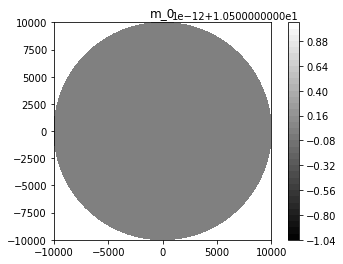

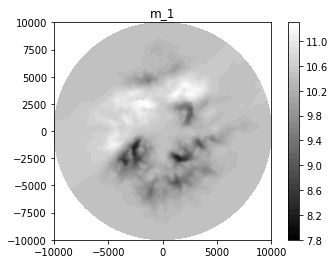

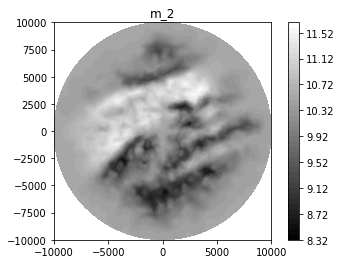

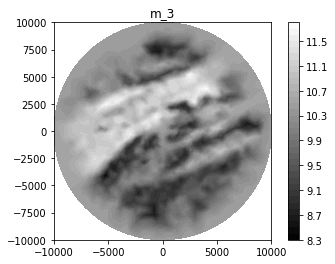

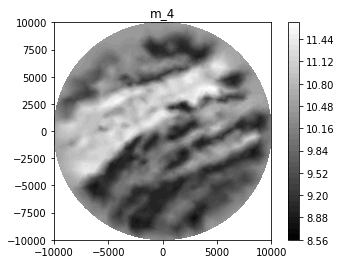

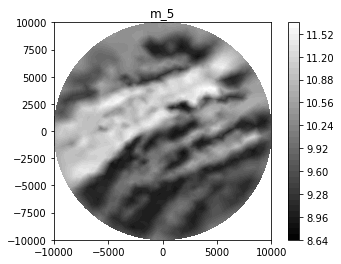

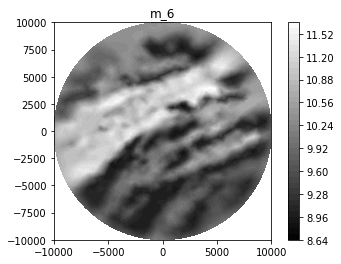

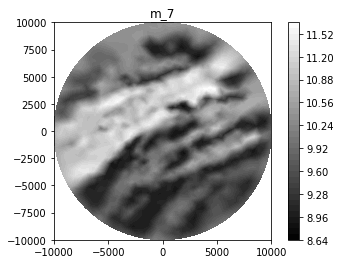

In [119]:
update_m(m0_constant_value * np.ones(Vh2.dim()))
REG.update_gamma(gamma_morozov)

iter_NONE = list()
m_iter_NONE = list()
def NONE_callback(it, m_Vh2_numpy):
    iter_NONE.append(it)
    m_iter_NONE.append(m_Vh2_numpy)
    m_Vh2 = dl.Function(Vh2)
    m_Vh2.vector()[:] = m_Vh2_numpy
    plt.figure()
    cm = dl.plot(m_Vh2, cmap='gray')
    plt.colorbar(cm)
    plt.title('m_'+str(it))

identity_operator = lambda x: x

NONE_convergence_info = newtoncg_ls(get_optimization_variable, 
                                    set_optimization_variable, 
                                    cost_triple, 
                                    gradient, 
                                    apply_hessian, 
                                    apply_gauss_newton_hessian, 
                                    build_nothing, 
                                    update_nothing, 
                                    identity_operator, # no preconditioning
                                    callback=NONE_callback,
                                    rtol=newton_rtol,
                                    num_gn_iter=num_gn_iter,
                                    forcing_sequence_power=forcing_sequence_power)

misfit_datanorm = morozov_helper()

# Plots to make (4):
 - Newton CG iterations and gradient table (psf and reg)
 - Newton iterates (reg and psf)
 - u recovered (with arrows)

In [122]:
norm_grad_newton_pch = np.array(PCH_convergence_info.gradnorm)
norm_grad_newton_reg = np.array(REG_convergence_info.gradnorm)
norm_grad_newton_none = np.array(NONE_convergence_info.gradnorm)

print('norm_grad_newton_pch=', norm_grad_newton_pch)
print('norm_grad_newton_reg=', norm_grad_newton_reg)
print('norm_grad_newton_none=', norm_grad_newton_none)
print('norm_grad_newton_pch/norm_grad_newton_pch[0]=', norm_grad_newton_pch/norm_grad_newton_pch[0])
print('norm_grad_newton_reg/norm_grad_newton_reg[0]=', norm_grad_newton_reg/norm_grad_newton_reg[0])
print('norm_grad_newton_reg/norm_grad_newton_none[0]=', norm_grad_newton_none/norm_grad_newton_none[0])

norm_grad_newton_pch= [1.94699839e+07 5.75903160e+06 2.35504764e+06 5.78871178e+05
 5.61489210e+04 3.44651043e+03 2.65574804e+01 4.08506507e-02]
norm_grad_newton_reg= [1.94699839e+07 7.90211107e+06 3.87424591e+06 1.62266011e+06
 4.77693437e+05 7.72159666e+04 5.03735473e+03 7.91265181e+01
 1.60215850e-01]
norm_grad_newton_none= [1.94699839e+07 5.75903160e+06 2.35504764e+06 5.78871178e+05
 9.05412831e+04 6.20626006e+03 1.05077362e+02 2.28555049e-01
 4.07589220e-02]
norm_grad_newton_pch/norm_grad_newton_pch[0]= [1.00000000e+00 2.95790260e-01 1.20957863e-01 2.97314667e-02
 2.88387096e-03 1.77016604e-04 1.36402169e-06 2.09813480e-09]
norm_grad_newton_reg/norm_grad_newton_reg[0]= [1.00000000e+00 4.05861202e-01 1.98985574e-01 8.33416260e-02
 2.45348656e-02 3.96589782e-03 2.58724135e-04 4.06402587e-06
 8.22886404e-09]
norm_grad_newton_reg/norm_grad_newton_none[0]= [1.00000000e+00 2.95790260e-01 1.20957863e-01 2.97314667e-02
 4.65030088e-03 3.18760411e-04 5.39689005e-06 1.17388412e-08
 2.093423

Text(0.5, 1.0, 'Congergence of preconditioned inexact Newton-CG')

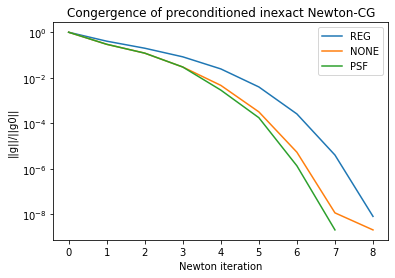

In [124]:
plt.figure()
plt.semilogy(norm_grad_newton_reg/norm_grad_newton_reg[0])
plt.semilogy(norm_grad_newton_none/norm_grad_newton_none[0])
plt.semilogy(norm_grad_newton_pch/norm_grad_newton_pch[0])
plt.legend(['REG', 'NONE', 'PSF'])
plt.xlabel('Newton iteration')
plt.ylabel('||g||/||g0||')
plt.title('Congergence of preconditioned inexact Newton-CG')

cumulative_cg_pch= [ 0.  1.  3.  7.  9. 14. 24. 38.]
cumulative_cg_reg= [  0.   1.   3.   8.  21.  63. 147. 272. 466.]
cumulative_cg_none= [  0.   1.   3.   7.  20.  53. 110. 186. 303.]


Text(0.5, 1.0, 'Congergence of preconditioned inexact Newton-CG')

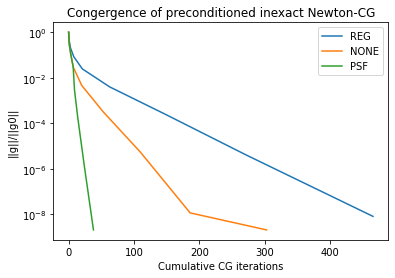

In [126]:
cumulative_cg_pch = np.concatenate([np.array([0.0]), np.cumsum(PCH_convergence_info.cg_iter)[:-1]])
cumulative_cg_reg = np.concatenate([np.array([0.0]), np.cumsum(REG_convergence_info.cg_iter)[:-1]])
cumulative_cg_none = np.concatenate([np.array([0.0]), np.cumsum(NONE_convergence_info.cg_iter)[:-1]])

print('cumulative_cg_pch=', cumulative_cg_pch)
print('cumulative_cg_reg=', cumulative_cg_reg)
print('cumulative_cg_none=', cumulative_cg_none)

plt.figure()

plt.semilogy(cumulative_cg_reg, norm_grad_newton_reg/norm_grad_newton_reg[0])
plt.semilogy(cumulative_cg_none, norm_grad_newton_none/norm_grad_newton_none[0])
plt.semilogy(cumulative_cg_pch, norm_grad_newton_pch/norm_grad_newton_pch[0])
plt.legend(['REG', 'NONE', 'PSF'])
plt.xlabel('Cumulative CG iterations')
plt.ylabel('||g||/||g0||')
plt.title('Congergence of preconditioned inexact Newton-CG')

In [127]:
print(PCH_convergence_info.hess_matvecs)
print(PCH_convergence_info.cg_iter)

[1, 2, 4, 2, 5, 10, 14, 0]
[1, 2, 4, 2, 5, 10, 14, 0]


In [128]:
spatialdim = 2
num_moment_matvecs = 1 + spatialdim + spatialdim * (spatialdim + 1) / 2.0
num_preconditioner_build_matvecs = num_moment_matvecs + num_batches

print('num_moment_matvecs=', num_moment_matvecs)
print('num_preconditioner_build_matvecs=', num_preconditioner_build_matvecs)

num_moment_matvecs= 6.0
num_preconditioner_build_matvecs= 11.0


cumulative_hessian_matvecs_psf= [ 0.  1.  3.  7. 20. 25. 35. 49.]
cumulative_hessian_matvecs_reg= [  0.   1.   3.   8.  21.  63. 147. 272. 466.]
cumulative_hessian_matvecs_none= [  0.   1.   3.   7.  20.  53. 110. 186. 303.]


Text(0.5, 1.0, 'Congergence of preconditioned inexact Newton-CG')

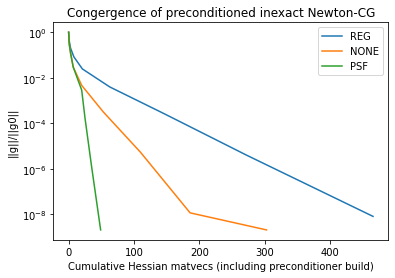

In [130]:
cumulative_hessian_matvecs_psf = [0.0]
for nh, build in zip(PCH_convergence_info.hess_matvecs[:-1], PCH_convergence_info.build_precond[:-1]):
    prev_matvecs = cumulative_hessian_matvecs_psf[-1]
    if build:
        new_matvecs = nh + num_preconditioner_build_matvecs
    else:
        new_matvecs = nh
    cumulative_hessian_matvecs_psf.append(prev_matvecs + new_matvecs)
    
cumulative_hessian_matvecs_reg = cumulative_cg_reg
cumulative_hessian_matvecs_none = cumulative_cg_none
cumulative_hessian_matvecs_psf = np.array(cumulative_hessian_matvecs_psf)
print('cumulative_hessian_matvecs_psf=', cumulative_hessian_matvecs_psf)
print('cumulative_hessian_matvecs_reg=', cumulative_hessian_matvecs_reg)
print('cumulative_hessian_matvecs_none=', cumulative_hessian_matvecs_none)

plt.figure()
plt.semilogy(cumulative_hessian_matvecs_reg, norm_grad_newton_reg/norm_grad_newton_reg[0])
plt.semilogy(cumulative_hessian_matvecs_none, norm_grad_newton_none/norm_grad_newton_none[0])
plt.semilogy(cumulative_hessian_matvecs_psf, norm_grad_newton_pch/norm_grad_newton_pch[0])
plt.legend(['REG', 'NONE', 'PSF'])
plt.xlabel('Cumulative Hessian matvecs (including preconditioner build)')
plt.ylabel('||g||/||g0||')
plt.title('Congergence of preconditioned inexact Newton-CG')

cumulative_stokes_psf= [  2   6  12  22  50  62  84 114]
cumulative_stokes_reg= [  2   6  12  24  52 138 308 560 950]
relative_grad_psf= [1.00000000e+00 2.95790260e-01 1.20957863e-01 2.97314667e-02
 2.88387096e-03 1.77016604e-04 1.36402169e-06 2.09813480e-09]
relative_grad_reg= [1.00000000e+00 4.05861202e-01 1.98985574e-01 8.33416260e-02
 2.45348656e-02 3.96589782e-03 2.58724135e-04 4.06402587e-06
 8.22886404e-09]
relative_grad_none= [1.00000000e+00 2.95790260e-01 1.20957863e-01 2.97314667e-02
 4.65030088e-03 3.18760411e-04 5.39689005e-06 1.17388412e-08
 2.09342351e-09]


Text(0.5, 1.0, 'Congergence of preconditioned inexact Newton-CG')

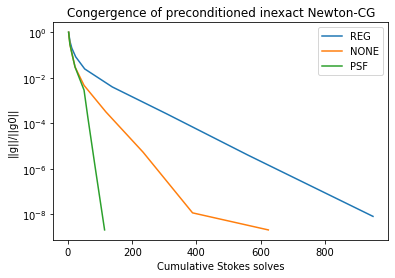

In [132]:
cumulative_stokes_psf = [PCH_convergence_info.cost_calls[0] + PCH_convergence_info.grad_calls[0]]
for k in range(1,len(PCH_convergence_info.newton_iter)):
    cs = cumulative_stokes_psf[-1]
    cs += PCH_convergence_info.cost_calls[k]
    cs += PCH_convergence_info.grad_calls[k]
    cs += 2*PCH_convergence_info.hess_matvecs[k-1] # incremental forward and incremental adjoint
    if PCH_convergence_info.build_precond[k-1]:
        cs += 2*num_preconditioner_build_matvecs
    cumulative_stokes_psf.append(cs)
    
cumulative_stokes_psf = np.array(cumulative_stokes_psf, dtype=int)
print('cumulative_stokes_psf=', cumulative_stokes_psf)

cumulative_stokes_reg = [REG_convergence_info.cost_calls[0] + REG_convergence_info.grad_calls[0]]
for k in range(1,len(REG_convergence_info.newton_iter)):
    cs = cumulative_stokes_reg[-1]
    cs += REG_convergence_info.cost_calls[k]
    cs += REG_convergence_info.grad_calls[k]
    cs += 2*REG_convergence_info.hess_matvecs[k-1] # incremental forward and incremental adjoint
    cumulative_stokes_reg.append(cs)
    
cumulative_stokes_reg = np.array(cumulative_stokes_reg)
print('cumulative_stokes_reg=', cumulative_stokes_reg)

cumulative_stokes_none = [NONE_convergence_info.cost_calls[0] + NONE_convergence_info.grad_calls[0]]
for k in range(1,len(NONE_convergence_info.newton_iter)):
    cs = cumulative_stokes_none[-1]
    cs += NONE_convergence_info.cost_calls[k]
    cs += NONE_convergence_info.grad_calls[k]
    cs += 2*NONE_convergence_info.hess_matvecs[k-1] # incremental forward and incremental adjoint
    cumulative_stokes_none.append(cs)

relative_grad_psf = norm_grad_newton_pch/norm_grad_newton_pch[0]
relative_grad_reg = norm_grad_newton_reg/norm_grad_newton_reg[0]
relative_grad_none = norm_grad_newton_none/norm_grad_newton_none[0]

print('relative_grad_psf=', relative_grad_psf)
print('relative_grad_reg=', relative_grad_reg)
print('relative_grad_none=', relative_grad_none)

plt.figure()
plt.semilogy(cumulative_stokes_reg, relative_grad_reg)
plt.semilogy(cumulative_stokes_none, relative_grad_none)
plt.semilogy(cumulative_stokes_psf, relative_grad_psf)
plt.legend(['REG', 'NONE', 'PSF'])
plt.xlabel('Cumulative Stokes solves')
plt.ylabel('||g||/||g0||')
plt.title('Congergence of preconditioned inexact Newton-CG')

In [133]:
np.savetxt(save_dir_str + '/cumulative_cg_pch.txt', cumulative_cg_pch)
np.savetxt(save_dir_str + '/cumulative_cg_reg.txt', cumulative_cg_reg)
np.savetxt(save_dir_str + '/cumulative_cg_none.txt', cumulative_cg_none)
np.savetxt(save_dir_str + '/cumulative_hessian_matvecs_psf.txt', cumulative_hessian_matvecs_psf)
np.savetxt(save_dir_str + '/cumulative_hessian_matvecs_reg.txt', cumulative_hessian_matvecs_reg)
np.savetxt(save_dir_str + '/cumulative_hessian_matvecs_none.txt', cumulative_hessian_matvecs_none)
np.savetxt(save_dir_str + '/cumulative_stokes_psf.txt', cumulative_stokes_psf)
np.savetxt(save_dir_str + '/cumulative_stokes_reg.txt', cumulative_stokes_reg)
np.savetxt(save_dir_str + '/cumulative_stokes_none.txt', cumulative_stokes_none)
np.savetxt(save_dir_str + '/relative_grad_psf.txt', relative_grad_psf)
np.savetxt(save_dir_str + '/relative_grad_reg.txt', relative_grad_reg)
np.savetxt(save_dir_str + '/relative_grad_none.txt', relative_grad_none)

In [134]:
dl.File(save_dir_str + "/recovered_pressure" + str(outflow_constant)+".pvd") << u.sub(1)
dl.File(save_dir_str + "/recovered_velocity" + str(outflow_constant)+".pvd") << u.sub(0)

In [135]:
num_cg_newton_none = np.array(NONE_convergence_info.hess_matvecs)
num_stokes_newton_none = (np.array(NONE_convergence_info.cost_calls) + 
                         np.array(NONE_convergence_info.grad_calls) +
                         2*np.array(NONE_convergence_info.hess_matvecs))

num_cg_newton_reg = np.array(REG_convergence_info.hess_matvecs)
num_stokes_newton_reg = (np.array(REG_convergence_info.cost_calls) + 
                         np.array(REG_convergence_info.grad_calls) +
                         2*np.array(REG_convergence_info.hess_matvecs))

num_cg_newton_psf = np.array(PCH_convergence_info.hess_matvecs)
num_stokes_newton_psf = (np.array(PCH_convergence_info.cost_calls) + 
                         np.array(PCH_convergence_info.grad_calls) +
                         2*np.array(PCH_convergence_info.hess_matvecs))

num_stokes_build_preconditioner = 2*num_preconditioner_build_matvecs*np.array(PCH_convergence_info.build_precond, dtype=int)
num_stokes_build_preconditioner = np.array(num_stokes_build_preconditioner, dtype=int)


np.savetxt(save_dir_str + '/norm_grad_newton_reg.txt', norm_grad_newton_reg)
np.savetxt(save_dir_str + '/norm_grad_newton_psf.txt', norm_grad_newton_pch)
np.savetxt(save_dir_str + '/norm_grad_newton_none.txt', norm_grad_newton_none)
np.savetxt(save_dir_str + '/num_cg_newton_reg.txt', num_cg_newton_reg)
np.savetxt(save_dir_str + '/num_cg_newton_psf.txt', num_cg_newton_psf)
np.savetxt(save_dir_str + '/num_cg_newton_none.txt', num_cg_newton_none)
np.savetxt(save_dir_str + '/num_stokes_newton_reg.txt', num_stokes_newton_reg)
np.savetxt(save_dir_str + '/num_stokes_newton_psf.txt', num_stokes_newton_psf)
np.savetxt(save_dir_str + '/num_stokes_newton_none.txt', num_stokes_newton_none)
np.savetxt(save_dir_str + '/num_stokes_build_preconditioner.txt', num_stokes_build_preconditioner)

In [143]:
ps = " "*5 + "|" + " "*10 + "PSF" + " "*11 + "|" + " "*10 + "REG" + " "*11 + "|" + " "*10 + "NONE" + " "*11 + "\n"
ps += "-"*5 + "|" + "-"*24 + "|" + "-"*24 + "|" + "-"*24 + "\n"
ps += "{0:>4} | {1:<3}  {2:<7} {3:>9} | {4:<3}  {5:<7} {6:>9} | {7:<3}  {8:<7} {9:>9}\n".format(
            "Iter", "#CG", "#Stokes", "||g||", "#CG", "#Stokes", "||g||", "#CG", "#Stokes", "||g||")
for k in range(len(norm_grad_newton_reg)):   
    ps += "{:>4}".format(k)
    ps += " | "
    if k < len(num_cg_newton_psf):
        ps += "{:<3d}".format(num_cg_newton_psf[k])
        ps += "  "
        if nbuild > 0:
            ps += "{:<7}".format(str(num_stokes_newton_psf[k]) + " + " + str(int(num_stokes_build_preconditioner[k])))
        else:
            ps += "{:<7d}".format(num_stokes_newton_psf[k])
        ps += " "
        ps += "{:>9}".format(np.format_float_scientific(norm_grad_newton_pch[k], precision=2, trim='k', unique=False))
    else:
        ps += "{:<3}".format('---')
        ps += "  "
        ps += "{:<7}".format('---')
        ps += " "
        ps += "{:>9}".format('---')
        
    ps += " | "
    ps += "{:<3d}".format(num_cg_newton_reg[k])
    ps += "  "
    ps += "{:<7d}".format(num_stokes_newton_reg[k])
    ps += " "
    ps += "{:>9}".format(np.format_float_scientific(norm_grad_newton_reg[k], precision=2, trim='k', unique=False))
    ps += " | "
    ps += "{:<3d}".format(num_cg_newton_none[k])
    ps += "  "
    ps += "{:<7d}".format(num_stokes_newton_none[k])
    ps += " "
    ps += "{:>9}".format(np.format_float_scientific(norm_grad_newton_none[k], precision=2, trim='k', unique=False))
    ps += "\n"
    
print(ps)

num_cg_total_psf = np.sum(num_cg_newton_psf)
print('num_cg_total_psf=', num_cg_total_psf)

num_cg_total_reg = np.sum(num_cg_newton_reg)
print('num_cg_total_reg=', num_cg_total_reg)

num_cg_total_none = np.sum(num_cg_newton_none)
print('num_cg_total_none=', num_cg_total_none)

num_stokes_total_psf = np.sum(num_stokes_newton_psf)
print('num_stokes_total_psf=', num_stokes_total_psf)

num_stokes_total_reg = np.sum(num_stokes_newton_reg)
print('num_stokes_total_reg=', num_stokes_total_reg)

num_stokes_total_none = np.sum(num_stokes_newton_none)
print('num_stokes_total_none=', num_stokes_total_none)

# Iter  |  #CG (PSF)   #Stokes (PSF)    ||g|| (PSF) |  #CG (REG)   #Stokes (REG)    ||g|| (REG)
# 1     |  1           1234             1.95e+07    |  1           2345             1.95e+07
# 2     |  2           1234             7.88e+06    |  2           2345             7.88e+06
# 3     |  5           1234             3.86e+06    |  5           2345             3.86e+06
# 4     |  2           1234 + 24        1.62e+06    |  14          2345             1.62e+06
# ...   |  ...         ...              ...         |  ...         ...              ...
# 8     |  15          1234             3.74e+01    |  210         2345             7.66e+01
# 9     |  ---         2                1.26e-01    |  ---         2                1.63e-01

     |          PSF           |          REG           |          NONE           
-----|------------------------|------------------------|------------------------
Iter | #CG  #Stokes     ||g|| | #CG  #Stokes     ||g|| | #CG  #Stokes     ||g||
   0 | 1    4        1.95e+07 | 1    4        1.95e+07 | 1    4        1.95e+07
   1 | 2    6        5.76e+06 | 2    6        7.90e+06 | 2    6        5.76e+06
   2 | 4    10       2.36e+06 | 5    12       3.87e+06 | 4    10       2.36e+06
   3 | 2    6        5.79e+05 | 13   28       1.62e+06 | 13   28       5.79e+05
   4 | 5    12       5.61e+04 | 42   86       4.78e+05 | 33   68       9.05e+04
   5 | 10   22       3.45e+03 | 84   170      7.72e+04 | 57   116      6.21e+03
   6 | 14   30       2.66e+01 | 125  252      5.04e+03 | 76   154      1.05e+02
   7 | 0    2        4.09e-02 | 194  390      7.91e+01 | 117  236      2.29e-01
   8 | ---  ---           --- | 0    2        1.60e-01 | 0    2        4.08e-02

num_cg_total_psf= 38
num_cg_total_re

In [144]:
for k in range(len(m_iter_PCH)):
    mk_pch = dl.Function(Vh2)
    mk_pch.vector()[:] = m_iter_PCH[k]
    dl.File(save_dir_str + "/m" + str(k) + "_psf.pvd") << mk_pch

for k in range(len(m_iter_REG)):
    mk_reg = dl.Function(Vh2)
    mk_reg.vector()[:] = m_iter_REG[k]
    dl.File(save_dir_str + "/m" + str(k) + "_reg.pvd") << mk_reg
    
for k in range(len(m_iter_NONE)):
    mk_none = dl.Function(Vh2)
    mk_none.vector()[:] = m_iter_NONE[k]
    dl.File(save_dir_str + "/m" + str(k) + "_none.pvd") << mk_none


# CG solve comparing PCH to REG to None preconditioning

In [46]:
all_PCK = list()
all_Hd_pch = list()
for nb in all_num_batches:
    print('building PCH' + str(nb) + ' preconditioner')
    PCKx = ProductConvolutionKernel(Vh2, Vh2, 
                                    apply_misfit_gauss_newton_hessian_petsc, 
                                    apply_misfit_gauss_newton_hessian_petsc,
                                    nb, nb,
                                    tau_rows=tau, tau_cols=tau,
                                    num_neighbors_rows=num_neighbors,
                                    num_neighbors_cols=num_neighbors)
    Hd_pch_nonsymx, extrasx = make_hmatrix_from_kernel(PCKx, hmatrix_tol=hmatrix_tol)

    # ----- build spd approximation of Hd
    Hd_pchx = Hd_pch_nonsymx.spd()
    all_PCK.append(PCKx)
    all_Hd_pch.append(Hd_pchx)

building PCH1 preconditioner
Computing impulse response moments
getting spatially varying volume
getting spatially varying mean
getting spatially varying covariance
Preparing sample point batch stuff
Preparing c++ object
Building initial sample point batches


  0%|          | 0/1 [00:00<?, ?it/s]

Making row and column cluster treesUsing ProductConvolutionKernelRBFColsOnly!
Making block cluster trees
Building A kernel hmatrix

Making input and output mass matrix hmatrices━━ building H-matrix ( tol = 1e-06 )
[==-                                     ]   7%                  
Computing A_hmatrix = M_out_hmatrix * A_kernel_hmatrix * M_in_hmatrix
making hmatrix spd
                                                         symmetrizing
 ========-                               ]  22% ETA 7 s (5.31 GB)
    done in 8.81s                                                
    size of H-matrix = 4.42 MB
lambda_min= -18258.49758721875                                   
scaling_at_lambda_min= 0.9878048780487805
scaling_at_zero= 0.5
Setting up operator T = (2*A - (b+a) I) / (b-a)
computing T^(2^k)
computing T^(2^1) = T^(2^0) * T^(2^0)

computing T^(2^2) = T^(2^1) * T^(2^1)
━━ H-matrix multiplication C=A*B 
[========-                                                        jector Pi_minus = I / (I +

  0%|          | 0/5 [00:00<?, ?it/s]

Making row and column cluster treesUsing ProductConvolutionKernelRBFColsOnly!

Making block cluster trees
Building A kernel hmatrix
Making input and output mass matrix hmatrices━━ building H-matrix ( tol = 
Computing A_hmatrix = M_out_hmatrix * A_kernel_hmatrix * M_in_hmatrix
making hmatrix spd
symmetrizing
1e-06 )
[======                                                                                                  
    done in 9.40s                                                
    size of H-matrix = 4.42 MB
lambda_min= -18113.97578005232                                   
scaling_at_lambda_min= 0.9878048780487805
scaling_at_zero= 0.5
Setting up operator T = (2*A - (b+a) I) / (b-a)
computing T^(2^k)
computing T^(2^1) = T^(2^0) * T^(2^0)

computing T^(2^2) = T^(2^1) * T^(2^1)
computing negative spectral projector Pi_minus = I / (I + T^(2^k))━━ H-matrix multiplication C=A*B 
[==-                                     ]                        
                                     ━━ H

  0%|          | 0/25 [00:00<?, ?it/s]

Making row and column cluster treesUsing ProductConvolutionKernelRBFColsOnly!

Making block cluster trees
Building A kernel hmatrix
━━ building H-matrix ( tol = 1e-06 )
[======                                                          
                                          Computing A_hmatrix = M_out_hmatrix * A_kernel_hmatrix * M_in_hmatrix
making hmatrix spd
symmetrizing
getting smallest eigenvalue with Lanczos
    done in 9.85s                                                
    size of H-matrix = 4.42 MB
lambda_min= -17967.321497959856                                  
scaling_at_lambda_min= 0.9878048780487805
scaling_at_zero= 0.5
Setting up operator T = (2*A - (b+a) I) / (b-a)
computing T^(2^k)
computing T^(2^1) = T^(2^0) * T^(2^0)

computing T^(2^2) = T^(2^1) * T^(2^1)━━ H-matrix multiplication C=A*B 
[==-                                                              
    done in 26.28s                                                jector Pi_minus = I / (I + T^(2^k))          

In [47]:
REG.update_gamma(gamma_morozov)

# Rebuild reg hmatrix with same block cluster tree as PCH data misfit hmatrix
print('Building Regularization H-Matrix')
R_hmatrix = REG.make_R_hmatrix(all_Hd_pch[0].bct, rtol=1e-6)

all_H_pch = [Hd + R_hmatrix for Hd in all_Hd_pch]
all_preconditioners = [H.factorized_inverse() for H in all_H_pch]

/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Building Regularization H-Matrix
  matrix has dimension 1416 x 1416
    no of non-zeroes    = 9746
    matrix is             real valued
    format              = non symmetric
  size of sparse matrix = 163.52 kB
  |S|_F                 = 1.17463e+06
    sparsity constant = 20
    size of H-matrix  = 4.06 MB
    |A|_F             = 1.17463e+06
 |S-A|_2 = 5.03893e-09
  matrix has dimension ━━ H-matrix inverse ( rtol =  1e-06 , atol =  1e-14 , overwrite= False  )
    done in  10.949486494064331
    size of inverse =  3361874  bytes
1416 x 1416
    no of non-zeroes    = 9746
    matrix is             real valued
    format              = symmetric
  size of sparse matrix = 163.52 kB
  |S|_F                 = 5.18561e+06
    sparsity constant = 20
    size of H-matrix  = 2.29 MB
    |A|_F             = 5.18561e+06
 |S-A|_2 = 4.66653e-09
                                                                  =================                      ]  45% ETA 7 s (5.40 GB)
━━ H-matrix multiplicatio

In [48]:
def cg_wrapper(A_linop, b, M_linop, tol=1e-10, x_true=None):
    if x_true is None:
        x_true = np.nan * np.zeros(b.shape)
    all_relres = list()
    all_err = list()

    ii_list = [0]
    def callback(xk):
        relres = np.linalg.norm(b - A_linop.matvec(xk)) / np.linalg.norm(b)
        all_relres.append(relres)
        err = np.linalg.norm(xk - x_true) / np.linalg.norm(x_true)
        all_err.append(err)
        print('ii=', ii_list[0], ', relres=', relres, ', err=', err)
        ii_list[0] += 1

    x, info = spla.cg(A_linop, b, M=M_linop, tol=tol, callback=callback, maxiter=1000)
    all_relres = np.array(all_relres)
    all_err = np.array(all_err)
    return x, info, all_relres, all_err

    done in 26.47s                                               
    size of LU factor = 23.77 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
[=========================-              ]  64% ETA 9 s (5.47 G   

    done in 26.06s                                               
    size of LU factor = 23.48 MB
GN: get truth:                                                   
ii= 0 , relres= 0.27601718308658496 , err= nan
ii= 1 , relres= 0.09813931551343728 , err= nan
ii= 2 , relres= 0.06541915358772958 , err= nan
ii= 3 , relres= 0.03277815146500743 , err= nan
ii= 4 , relres= 0.013858388676872571 , err= nan
ii= 5 , relres= 0.008356861333440008 , err= nan
ii= 6 , relres= 0.005509456953260937 , err= nan
ii= 7 , relres= 0.0029237274611475885 , err= nan
ii= 8 , relres= 0.0013427580506960727 , err= nan
ii= 9 , relres= 0.0005697863814164986 , err= nan
ii= 10 , relres= 0.00024750702116254855 , err= nan
ii= 11 , relres= 9.422633661451903e-05 , err= nan
ii= 12 , relres= 3.94891994467393e-05 , err= nan
ii= 13 , relres= 1.7686266467685407e-05 , err= nan
ii= 14 , relres= 8.08120525077261e-06 , err= nan
ii= 15 , relres= 3.0467651942569076e-06 , err= nan
ii= 16 , relres= 9.604742888292093e-07 , err= nan
ii= 1

ii= 18 , relres= 1.8525295592336308e-07 , err= 5.8356432248492125e-08
ii= 19 , relres= 8.955566263306183e-08 , err= 2.749471454167753e-08
ii= 20 , relres= 4.2785056803872966e-08 , err= 1.3551504025043353e-08
ii= 21 , relres= 1.6861718533806796e-08 , err= 6.164691933606336e-09
ii= 22 , relres= 6.3176309247221295e-09 , err= 2.387715114715222e-09
ii= 23 , relres= 2.3815341175019107e-09 , err= 9.88188903321504e-10
ii= 24 , relres= 9.125171913310231e-10 , err= 3.9502614568344317e-10
ii= 25 , relres= 3.266836379862665e-10 , err= 1.4095122099711297e-10
ii= 26 , relres= 1.3799009155180028e-10 , err= 5.703493318988062e-11
ii= 27 , relres= 5.683462753166873e-11 , err= 0.0
GN: reg
ii= 0 , relres= 1.0597820456483673 , err= 0.9979792995277864
ii= 1 , relres= 1.0927419351621757 , err= 0.9926389926378255
ii= 2 , relres= 1.092910761796001 , err= 0.9855575747229944
ii= 3 , relres= 1.123743029407103 , err= 0.9763144348173889
ii= 4 , relres= 1.1328075503517547 , err= 0.964541190083685
ii= 5 , relres= 1.1

ii= 119 , relres= 0.04638944753822308 , err= 0.017272277535928814
ii= 120 , relres= 0.043498104578078726 , err= 0.01641588093154916
ii= 121 , relres= 0.04249113269183356 , err= 0.016253980755307786
ii= 122 , relres= 0.04078210695022554 , err= 0.015117135155343006
ii= 123 , relres= 0.04104436897868264 , err= 0.014946145697720011
ii= 124 , relres= 0.040323387702956376 , err= 0.014436104616260121
ii= 125 , relres= 0.03758159860993337 , err= 0.014017077418924101
ii= 126 , relres= 0.038501295800612144 , err= 0.013559003371883442
ii= 127 , relres= 0.03882844911853987 , err= 0.013096581970267158
ii= 128 , relres= 0.033712897104939674 , err= 0.012560358346199764
ii= 129 , relres= 0.03351481755537215 , err= 0.01178095499522938
ii= 130 , relres= 0.031719338834503445 , err= 0.011438147888693635
ii= 131 , relres= 0.032231701377756966 , err= 0.011080294676537702
ii= 132 , relres= 0.029059102790253165 , err= 0.01046549142517503
ii= 133 , relres= 0.028361308911792938 , err= 0.009721686537845197
ii= 1

ii= 241 , relres= 0.0007374101219214811 , err= 0.0002371991971009571
ii= 242 , relres= 0.0007208236693684593 , err= 0.00023061305944921336
ii= 243 , relres= 0.0006933386112326419 , err= 0.0002234363751590843
ii= 244 , relres= 0.0007380880286402977 , err= 0.00021795757268615201
ii= 245 , relres= 0.0006756481019509488 , err= 0.00020948990681592228
ii= 246 , relres= 0.0006093413017912769 , err= 0.0002041762883880892
ii= 247 , relres= 0.0006421789529669244 , err= 0.00019832140645682054
ii= 248 , relres= 0.0006393285154333586 , err= 0.00019409799237860313
ii= 249 , relres= 0.0005480495659870829 , err= 0.00018476072099327137
ii= 250 , relres= 0.0005454343982931454 , err= 0.00018157674209361984
ii= 251 , relres= 0.0005086742942887944 , err= 0.00016868066665643098
ii= 252 , relres= 0.0005129662148342407 , err= 0.0001643812858848555
ii= 253 , relres= 0.0005145226953151725 , err= 0.00016146071775340339
ii= 254 , relres= 0.00048627128444326417 , err= 0.00015527826874371322
ii= 255 , relres= 0.000

ii= 359 , relres= 1.2300737243986416e-05 , err= 4.080612876969717e-06
ii= 360 , relres= 1.2883767557120898e-05 , err= 4.032169270088251e-06
ii= 361 , relres= 1.1413857667523516e-05 , err= 3.7083396506960093e-06
ii= 362 , relres= 1.1549579597655263e-05 , err= 3.613116584971242e-06
ii= 363 , relres= 1.1168981086007192e-05 , err= 3.5240661601868554e-06
ii= 364 , relres= 1.0995897430568414e-05 , err= 3.3476321230890343e-06
ii= 365 , relres= 1.0333534852372204e-05 , err= 3.170271270220133e-06
ii= 366 , relres= 9.547858141343389e-06 , err= 3.0813019130323453e-06
ii= 367 , relres= 9.201947957468501e-06 , err= 2.9132839381193e-06
ii= 368 , relres= 9.299010944786385e-06 , err= 2.8661733286845123e-06
ii= 369 , relres= 9.343857306986125e-06 , err= 2.781551327590541e-06
ii= 370 , relres= 8.120008563595529e-06 , err= 2.6854274023851643e-06
ii= 371 , relres= 9.014311345359535e-06 , err= 2.566429624202434e-06
ii= 372 , relres= 7.970701913320922e-06 , err= 2.4750454262532034e-06
ii= 373 , relres= 7.77

ii= 477 , relres= 2.1430305785522506e-07 , err= 7.217230361882603e-08
ii= 478 , relres= 2.230398781986484e-07 , err= 6.911703573210892e-08
ii= 479 , relres= 1.9985129270750736e-07 , err= 6.308256682104596e-08
ii= 480 , relres= 1.8545343336122463e-07 , err= 6.185616022444506e-08
ii= 481 , relres= 1.8125060671755635e-07 , err= 6.117193202249032e-08
ii= 482 , relres= 1.7830984649314336e-07 , err= 5.980524417439229e-08
ii= 483 , relres= 2.0382686693870018e-07 , err= 5.668538771089659e-08
ii= 484 , relres= 1.821056237880069e-07 , err= 5.419362302940745e-08
ii= 485 , relres= 1.6450575392753335e-07 , err= 5.297077217034777e-08
ii= 486 , relres= 1.4119498324243227e-07 , err= 4.962726342107838e-08
ii= 487 , relres= 1.4332500262161308e-07 , err= 4.634754877873267e-08
ii= 488 , relres= 1.4058250653493708e-07 , err= 4.5014650765804086e-08
ii= 489 , relres= 1.259545376296815e-07 , err= 4.3952636338116335e-08
ii= 490 , relres= 1.2244772167083244e-07 , err= 4.259478618259028e-08
ii= 491 , relres= 1.3

ii= 595 , relres= 3.3775248223866672e-09 , err= 1.0838004686649102e-09
ii= 596 , relres= 3.310302040901299e-09 , err= 1.0523903259084203e-09
ii= 597 , relres= 3.163741145252938e-09 , err= 1.0333012720956697e-09
ii= 598 , relres= 3.4916011199925196e-09 , err= 1.0051888151642904e-09
ii= 599 , relres= 3.3390341123734137e-09 , err= 9.632673109705057e-10
ii= 600 , relres= 3.0097888386953703e-09 , err= 9.321492770016537e-10
ii= 601 , relres= 2.910780932351324e-09 , err= 9.131719533136223e-10
ii= 602 , relres= 2.8646798135224195e-09 , err= 8.85679798535991e-10
ii= 603 , relres= 2.541472552664069e-09 , err= 8.588513838096568e-10
ii= 604 , relres= 2.6145616108070384e-09 , err= 8.300084817935031e-10
ii= 605 , relres= 2.7056411270317915e-09 , err= 8.173182543068364e-10
ii= 606 , relres= 2.3458934790077078e-09 , err= 7.596377660314669e-10
ii= 607 , relres= 2.1659645643585113e-09 , err= 7.413003883251177e-10
ii= 608 , relres= 2.244970591061353e-09 , err= 7.329076191879633e-10
ii= 609 , relres= 2.06

ii= 713 , relres= 9.955827971375901e-11 , err= 3.1380413968104994e-11
GN: none
ii= 0 , relres= 1.5723762265828813 , err= 0.9413100182322085
ii= 1 , relres= 1.4276321717628766 , err= 0.9018713062388705
ii= 2 , relres= 1.2967314226199262 , err= 0.8640858231017992
ii= 3 , relres= 1.0355692385903477 , err= 0.8300247633337678
ii= 4 , relres= 1.0002573862064221 , err= 0.7855074289407601
ii= 5 , relres= 0.9815232648203925 , err= 0.7459197081265568
ii= 6 , relres= 0.8568601879009778 , err= 0.6981193636912204
ii= 7 , relres= 0.7999414683448317 , err= 0.6588811911116395
ii= 8 , relres= 0.7213308188095783 , err= 0.6238058835213194
ii= 9 , relres= 0.7109956553113762 , err= 0.5850499449499349
ii= 10 , relres= 0.605316967836353 , err= 0.542425316761491
ii= 11 , relres= 0.6405253997179531 , err= 0.5046782901841684
ii= 12 , relres= 0.5614551919236895 , err= 0.47203791041476995
ii= 13 , relres= 0.5067016087109157 , err= 0.43614511016286744
ii= 14 , relres= 0.503235339152959 , err= 0.4047759000305859
ii

ii= 124 , relres= 8.36555598769769e-05 , err= 8.066695354864718e-05
ii= 125 , relres= 9.158887311459392e-05 , err= 7.31806784622787e-05
ii= 126 , relres= 7.419970808979208e-05 , err= 6.69030559862882e-05
ii= 127 , relres= 6.613964421405356e-05 , err= 5.98344127813281e-05
ii= 128 , relres= 7.337017670308658e-05 , err= 5.4435539767135925e-05
ii= 129 , relres= 5.6896157136539e-05 , err= 4.8449387862449294e-05
ii= 130 , relres= 5.526171928635681e-05 , err= 4.305197118314353e-05
ii= 131 , relres= 5.521744802085336e-05 , err= 3.9250208428626184e-05
ii= 132 , relres= 4.188984545557424e-05 , err= 3.5092193117338576e-05
ii= 133 , relres= 4.31433703098381e-05 , err= 3.105306739913883e-05
ii= 134 , relres= 4.199637198857127e-05 , err= 2.879910672915922e-05
ii= 135 , relres= 3.470657129070027e-05 , err= 2.5619706046477116e-05
ii= 136 , relres= 3.543255500900378e-05 , err= 2.360570627004686e-05
ii= 137 , relres= 2.5193979474260566e-05 , err= 2.1233221416265427e-05
ii= 138 , relres= 3.20182953341169

ii= 242 , relres= 6.1728072859757035e-09 , err= 5.359160698599263e-09
ii= 243 , relres= 5.237481835696061e-09 , err= 5.022537114927771e-09
ii= 244 , relres= 5.938451926963992e-09 , err= 4.676179059486973e-09
ii= 245 , relres= 4.165809303119184e-09 , err= 4.3338617192085085e-09
ii= 246 , relres= 3.977870119564041e-09 , err= 3.983960726064067e-09
ii= 247 , relres= 3.4934300371497835e-09 , err= 3.6452975389921644e-09
ii= 248 , relres= 5.030250890581217e-09 , err= 3.387958752915058e-09
ii= 249 , relres= 2.930509991350758e-09 , err= 3.1529444652874664e-09
ii= 250 , relres= 3.475337943727479e-09 , err= 2.8735238359620008e-09
ii= 251 , relres= 2.4608886610188077e-09 , err= 2.646247282044847e-09
ii= 252 , relres= 2.4886206700703864e-09 , err= 2.32323484337468e-09
ii= 253 , relres= 2.8535835285090936e-09 , err= 2.1825027601627095e-09
ii= 254 , relres= 1.8469192681949586e-09 , err= 1.9304754952853835e-09
ii= 255 , relres= 1.6144786664830887e-09 , err= 1.6629452370074132e-09
ii= 256 , relres= 1.7

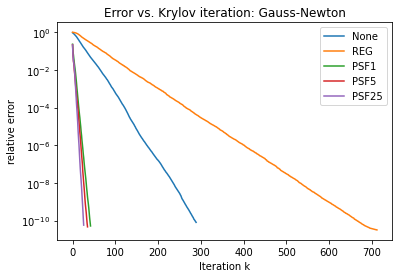

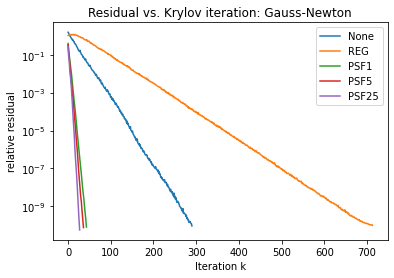

In [49]:
H_linop = spla.LinearOperator((Vh2.dim(), Vh2.dim()), matvec=apply_hessian)
Hgn_linop = spla.LinearOperator((Vh2.dim(), Vh2.dim()), matvec=apply_gauss_newton_hessian)
ireg_linop = spla.LinearOperator((Vh2.dim(), Vh2.dim()), matvec=REG.solve_hessian_numpy)
all_p_linop = [spla.LinearOperator((Vh2.dim(), Vh2.dim()), matvec=p.matvec) for p in all_preconditioners]

b = np.random.randn(Vh2.dim())

print('GN: get truth:')
x_true_gn, _, _, _ = cg_wrapper(Hgn_linop, b, all_p_linop[-1])

all_relres_gn = list()
all_errs_gn = list()
for nb, p_linop in zip(all_num_batches, all_p_linop):
    print('GN: psf'+str(nb))
    _, _, relres_gn, errs_gn = cg_wrapper(Hgn_linop, b, p_linop, x_true=x_true_gn)
    all_relres_gn.append(relres_gn)
    all_errs_gn.append(errs_gn)

print('GN: reg')
_, _, relres_gn_reg, errs_gn_reg = cg_wrapper(Hgn_linop, b, ireg_linop, x_true=x_true_gn)

print('GN: none')
_, _, relres_gn_none, errs_gn_none = cg_wrapper(Hgn_linop, b, None, x_true=x_true_gn)

plt.semilogy(errs_gn_none[:-1])
plt.semilogy(errs_gn_reg[:-1])
for errs_gn in all_errs_gn:
    plt.semilogy(errs_gn[:-1])
plt.title('Error vs. Krylov iteration: Gauss-Newton')
plt.xlabel('Iteration k')
plt.ylabel('relative error')
plt.legend(['None', 'REG'] + ['PSF'+str(nb) for nb in all_num_batches])

plt.figure()
plt.semilogy(relres_gn_none)
plt.semilogy(relres_gn_reg)
for relres_gn in all_relres_gn:
    plt.semilogy(relres_gn)
plt.title('Residual vs. Krylov iteration: Gauss-Newton')
plt.xlabel('Iteration k')
plt.ylabel('relative residual')
plt.legend(['None', 'REG'] + ['PSF'+str(nb) for nb in all_num_batches])

FULL: get truth:
ii= 0 , relres= 0.27748694259626777 , err= nan
ii= 1 , relres= 0.0986974188371117 , err= nan
ii= 2 , relres= 0.06180643286417644 , err= nan
ii= 3 , relres= 0.03447270977268124 , err= nan
ii= 4 , relres= 0.014202932749323284 , err= nan
ii= 5 , relres= 0.007730697336086705 , err= nan
ii= 6 , relres= 0.004868426151325458 , err= nan
ii= 7 , relres= 0.0027902417871429577 , err= nan
ii= 8 , relres= 0.001404540508743247 , err= nan
ii= 9 , relres= 0.0005351344245887282 , err= nan
ii= 10 , relres= 0.00022542563845710136 , err= nan
ii= 11 , relres= 8.984838418564862e-05 , err= nan
ii= 12 , relres= 3.955038219427387e-05 , err= nan
ii= 13 , relres= 1.6228488220487497e-05 , err= nan
ii= 14 , relres= 7.004956266701144e-06 , err= nan
ii= 15 , relres= 3.126974894854351e-06 , err= nan
ii= 16 , relres= 1.0416026834268995e-06 , err= nan
ii= 17 , relres= 4.2794712086817113e-07 , err= nan
ii= 18 , relres= 1.7604980302577017e-07 , err= nan
ii= 19 , relres= 8.461047672945042e-08 , err= nan
i

ii= 20 , relres= 4.147844237395628e-08 , err= 1.2366506140732088e-08
ii= 21 , relres= 1.741119990478758e-08 , err= 5.4310456819979985e-09
ii= 22 , relres= 6.6073492507802825e-09 , err= 2.44619439195804e-09
ii= 23 , relres= 2.379928376053447e-09 , err= 1.004430783589502e-09
ii= 24 , relres= 9.044015543290005e-10 , err= 3.694672724035349e-10
ii= 25 , relres= 3.4343421976602576e-10 , err= 1.3861381691359339e-10
ii= 26 , relres= 1.553949622999789e-10 , err= 5.300756535852121e-11
ii= 27 , relres= 6.738780522967071e-11 , err= 0.0
FULL: reg
ii= 0 , relres= 1.0597265881590914 , err= 0.9979666609945363
ii= 1 , relres= 1.092608244922056 , err= 0.9925971457437103
ii= 2 , relres= 1.0926325580380152 , err= 0.9854805023158194
ii= 3 , relres= 1.1233970391000407 , err= 0.9761929688578079
ii= 4 , relres= 1.132320282513923 , err= 0.9643683782249776
ii= 5 , relres= 1.1307456908832139 , err= 0.952445436502996
ii= 6 , relres= 1.168503580276918 , err= 0.9411470659465903
ii= 7 , relres= 1.1933765770675104 , 

ii= 121 , relres= 0.0445186236138439 , err= 0.016127799577921556
ii= 122 , relres= 0.04270728023399345 , err= 0.015143081381655087
ii= 123 , relres= 0.04021938118852225 , err= 0.014851888095102848
ii= 124 , relres= 0.03979910857834069 , err= 0.014551150188437273
ii= 125 , relres= 0.03909627821252636 , err= 0.014062246373709295
ii= 126 , relres= 0.03698939736468008 , err= 0.013599947602837224
ii= 127 , relres= 0.034038577511963035 , err= 0.012623720763793474
ii= 128 , relres= 0.03498206400371976 , err= 0.012207593069822388
ii= 129 , relres= 0.034030379144178904 , err= 0.011806176454557319
ii= 130 , relres= 0.031565652089982146 , err= 0.011409876526162708
ii= 131 , relres= 0.031687157452353676 , err= 0.011181843774019758
ii= 132 , relres= 0.03307009779320815 , err= 0.010888549760895854
ii= 133 , relres= 0.028703229807666212 , err= 0.010396863956736536
ii= 134 , relres= 0.029359940170343858 , err= 0.009748587323767271
ii= 135 , relres= 0.027873405493359944 , err= 0.009464321002722334
ii= 

ii= 243 , relres= 0.0006931677784011005 , err= 0.0002263009034848702
ii= 244 , relres= 0.0006969051319055064 , err= 0.00021899925890978724
ii= 245 , relres= 0.0006420811046389391 , err= 0.0002074042331735196
ii= 246 , relres= 0.0005999582887319005 , err= 0.0002024015152431793
ii= 247 , relres= 0.0006346340830784129 , err= 0.00019534083969235404
ii= 248 , relres= 0.0006327598037746177 , err= 0.00018868196422748993
ii= 249 , relres= 0.0005455849793876707 , err= 0.00018376969911363644
ii= 250 , relres= 0.0005484233920897775 , err= 0.00018086119478492255
ii= 251 , relres= 0.0005412180100916316 , err= 0.00016906015518855928
ii= 252 , relres= 0.0004977367231217517 , err= 0.00016648133406777695
ii= 253 , relres= 0.0005146172062513713 , err= 0.00016157402314563696
ii= 254 , relres= 0.0004839467673834003 , err= 0.00015440437061900274
ii= 255 , relres= 0.00047929042352089305 , err= 0.00015023190099142838
ii= 256 , relres= 0.0004515010910062983 , err= 0.00014755033039742517
ii= 257 , relres= 0.00

ii= 361 , relres= 1.2143106807393859e-05 , err= 3.824036374191485e-06
ii= 362 , relres= 1.1920911259640689e-05 , err= 3.7383935190009736e-06
ii= 363 , relres= 1.1244264092823386e-05 , err= 3.5849304107808887e-06
ii= 364 , relres= 1.1077682786060891e-05 , err= 3.5294336506070816e-06
ii= 365 , relres= 1.1284347561568834e-05 , err= 3.452189168590542e-06
ii= 366 , relres= 1.0886539427327703e-05 , err= 3.2635920943620794e-06
ii= 367 , relres= 9.77742677193425e-06 , err= 3.1423892330327573e-06
ii= 368 , relres= 9.610654927717543e-06 , err= 3.1136092408404208e-06
ii= 369 , relres= 9.449242968749506e-06 , err= 2.9798946741255544e-06
ii= 370 , relres= 9.122834198372424e-06 , err= 2.8667720851443557e-06
ii= 371 , relres= 8.83867006524245e-06 , err= 2.772268415303708e-06
ii= 372 , relres= 8.179416968386179e-06 , err= 2.7141518257331738e-06
ii= 373 , relres= 8.806691956628664e-06 , err= 2.6271152372488324e-06
ii= 374 , relres= 7.665516276303906e-06 , err= 2.4835588466818635e-06
ii= 375 , relres= 7

ii= 479 , relres= 2.1637406965248278e-07 , err= 6.981532713000544e-08
ii= 480 , relres= 2.252198405099129e-07 , err= 6.782738099210222e-08
ii= 481 , relres= 1.7522526631767046e-07 , err= 6.174254287335147e-08
ii= 482 , relres= 1.9052155486295157e-07 , err= 6.045016187214028e-08
ii= 483 , relres= 1.8513766704584045e-07 , err= 5.9064392252006177e-08
ii= 484 , relres= 2.0440116080922773e-07 , err= 5.612806201843489e-08
ii= 485 , relres= 1.6055329698933799e-07 , err= 5.292085506167504e-08
ii= 486 , relres= 1.4059514932059838e-07 , err= 4.9778553702474154e-08
ii= 487 , relres= 1.4974721020522146e-07 , err= 4.833993908676584e-08
ii= 488 , relres= 1.343816354764604e-07 , err= 4.553021006440688e-08
ii= 489 , relres= 1.271306688437924e-07 , err= 4.436090926574669e-08
ii= 490 , relres= 1.2266852789378083e-07 , err= 4.4009529247331953e-08
ii= 491 , relres= 1.252275295070901e-07 , err= 4.1424496538550457e-08
ii= 492 , relres= 1.2906273391754747e-07 , err= 3.9651895389275795e-08
ii= 493 , relres= 1

ii= 597 , relres= 3.280528077626988e-09 , err= 1.1045204677339415e-09
ii= 598 , relres= 3.3966129886961224e-09 , err= 1.0604015244606096e-09
ii= 599 , relres= 3.112679929443533e-09 , err= 1.001857820595298e-09
ii= 600 , relres= 3.0385718687425387e-09 , err= 9.920847956239282e-10
ii= 601 , relres= 2.8811920671035915e-09 , err= 9.376554221632486e-10
ii= 602 , relres= 2.5935388647883587e-09 , err= 9.058438277743469e-10
ii= 603 , relres= 2.7046660907390185e-09 , err= 8.89121684888838e-10
ii= 604 , relres= 2.6104228387533937e-09 , err= 8.35755217078526e-10
ii= 605 , relres= 2.683282559552078e-09 , err= 8.18917692704592e-10
ii= 606 , relres= 2.2117256378658784e-09 , err= 7.866067053048956e-10
ii= 607 , relres= 2.3345641684276682e-09 , err= 7.63033944002468e-10
ii= 608 , relres= 2.268717196462146e-09 , err= 7.432246376037391e-10
ii= 609 , relres= 2.0650422954152498e-09 , err= 7.159273086441403e-10
ii= 610 , relres= 2.139679828113687e-09 , err= 6.929991409926802e-10
ii= 611 , relres= 1.9321704

ii= 715 , relres= 1.0350172580985473e-10 , err= 3.1547191085427915e-11
ii= 716 , relres= 9.581845246080368e-11 , err= 3.121919498560772e-11
FULL: none
ii= 0 , relres= 1.5716567492061533 , err= 0.9407802253239325
ii= 1 , relres= 1.4266261702073126 , err= 0.9010255154819136
ii= 2 , relres= 1.295356775069299 , err= 0.8629463859695059
ii= 3 , relres= 1.0341510780529184 , err= 0.828637380288847
ii= 4 , relres= 0.9989474391894206 , err= 0.7837807716917106
ii= 5 , relres= 0.9797294098409576 , err= 0.7438930416566424
ii= 6 , relres= 0.8547857580567096 , err= 0.6958655917636394
ii= 7 , relres= 0.7977830433134245 , err= 0.6564011803243123
ii= 8 , relres= 0.7196491548328643 , err= 0.6211610815777434
ii= 9 , relres= 0.7082642236855325 , err= 0.5822935587729063
ii= 10 , relres= 0.6023227847265122 , err= 0.5395724669653795
ii= 11 , relres= 0.6374662672928189 , err= 0.5017474144634031
ii= 12 , relres= 0.5587404097047445 , err= 0.4690703038523222
ii= 13 , relres= 0.5036171581444335 , err= 0.4330648182

ii= 123 , relres= 8.138805350872195e-05 , err= 7.658784838570258e-05
ii= 124 , relres= 7.066303566550493e-05 , err= 6.937339649266163e-05
ii= 125 , relres= 7.676456838584443e-05 , err= 6.314083173124095e-05
ii= 126 , relres= 6.191391481084153e-05 , err= 5.773944013586036e-05
ii= 127 , relres= 5.492432972889215e-05 , err= 5.169350183292593e-05
ii= 128 , relres= 6.17177538684025e-05 , err= 4.6956300879582285e-05
ii= 129 , relres= 4.787134764063247e-05 , err= 4.204543381844626e-05
ii= 130 , relres= 4.553366139066931e-05 , err= 3.7391941334669015e-05
ii= 131 , relres= 4.716231415354071e-05 , err= 3.4027669705333213e-05
ii= 132 , relres= 3.549987815191707e-05 , err= 3.068406189830574e-05
ii= 133 , relres= 3.618246923478319e-05 , err= 2.7253878357277416e-05
ii= 134 , relres= 3.542945865482367e-05 , err= 2.5302127916545628e-05
ii= 135 , relres= 2.9748389332410285e-05 , err= 2.2647255967486947e-05
ii= 136 , relres= 3.0028233000942597e-05 , err= 2.099197006421081e-05
ii= 137 , relres= 2.1966379

ii= 241 , relres= 3.2287696538524792e-09 , err= 3.837770876279223e-09
ii= 242 , relres= 3.986862596821859e-09 , err= 3.5931945581090487e-09
ii= 243 , relres= 2.838208999216693e-09 , err= 3.3841646452419056e-09
ii= 244 , relres= 3.011977283223997e-09 , err= 3.1630122176994757e-09
ii= 245 , relres= 2.410839156933403e-09 , err= 2.953953357573248e-09
ii= 246 , relres= 2.315290581987507e-09 , err= 2.761220054809398e-09
ii= 247 , relres= 1.976558808174858e-09 , err= 2.565588523060545e-09
ii= 248 , relres= 2.3615020539733708e-09 , err= 2.359695706883433e-09
ii= 249 , relres= 2.076334934418944e-09 , err= 2.2541710870183133e-09
ii= 250 , relres= 2.105778323021072e-09 , err= 2.13493200239837e-09
ii= 251 , relres= 1.439078582586534e-09 , err= 1.9553400092651003e-09
ii= 252 , relres= 1.5600244427933605e-09 , err= 1.7461381593557996e-09
ii= 253 , relres= 1.7374455478859715e-09 , err= 1.6554440719730733e-09
ii= 254 , relres= 1.1722527820303346e-09 , err= 1.4804517672341107e-09
ii= 255 , relres= 1.07

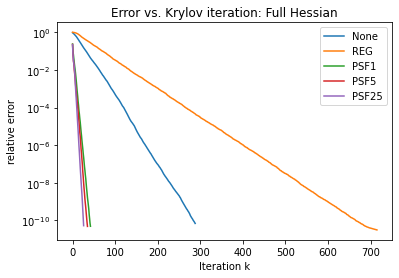

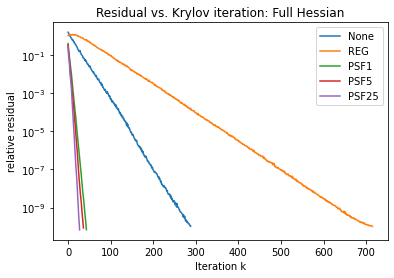

In [50]:
print('FULL: get truth:')
x_true, _, _, _ = cg_wrapper(H_linop, b, all_p_linop[-1])

all_relres = list()
all_errs = list()
for nb, p_linop in zip(all_num_batches, all_p_linop):
    print('FULL: psf'+str(nb))
    _, _, relres, errs = cg_wrapper(H_linop, b, p_linop, x_true=x_true)
    all_relres.append(relres)
    all_errs.append(errs)

print('FULL: reg')
_, _, all_relres_reg, all_err_reg = cg_wrapper(H_linop, b, ireg_linop, x_true=x_true)

print('FULL: none')
_, _, all_relres_none, all_err_none = cg_wrapper(H_linop, b, None, x_true=x_true)

plt.semilogy(all_err_none[:-1])
plt.semilogy(all_err_reg[:-1])
for errs in all_errs:
    plt.semilogy(errs[:-1])
plt.title('Error vs. Krylov iteration: Full Hessian')
plt.xlabel('Iteration k')
plt.ylabel('relative error')
plt.legend(['None', 'REG'] + ['PSF'+str(nb) for nb in all_num_batches])

plt.figure()
plt.semilogy(all_relres_none[:-1])
plt.semilogy(all_relres_reg[:-1])
for relres in all_relres:
    plt.semilogy(relres)
plt.title('Residual vs. Krylov iteration: Full Hessian')
plt.xlabel('Iteration k')
plt.ylabel('relative residual')
plt.legend(['None', 'REG'] + ['PSF'+str(nb) for nb in all_num_batches])

# Plots to make (5):
 - CG convergence (Full Newton, full page width, residual)

In [51]:
np.savetxt(save_dir_str + '/cg_relres_none.txt', all_relres_none)
np.savetxt(save_dir_str + '/cg_relres_reg.txt', all_relres_reg)
for nb, relres in zip(all_num_batches, all_relres):
    np.savetxt(save_dir_str + '/cg_relres_p' + str(nb) + '.txt', relres)
    
np.savetxt(save_dir_str + '/cg_relres_none_gn.txt', relres_gn_none)
np.savetxt(save_dir_str + '/cg_relres_reg_gn.txt', relres_gn_reg)
for nb, relres_gn in zip(all_num_batches, all_relres_gn):
    np.savetxt(save_dir_str + '/cg_relres_p' + str(nb) + '_gn.txt', relres_gn)
    
print('all_relres_none=', all_relres_none)
print('all_relres_reg=', all_relres_reg)
print('all_relres=', all_relres)

print('relres_gn_none=', relres_gn_none)
print('relres_gn_reg=', relres_gn_reg)
print('all_relres_gn=', all_relres_gn)

all_relres_none= [1.57165675e+00 1.42662617e+00 1.29535678e+00 1.03415108e+00
 9.98947439e-01 9.79729410e-01 8.54785758e-01 7.97783043e-01
 7.19649155e-01 7.08264224e-01 6.02322785e-01 6.37466267e-01
 5.58740410e-01 5.03617158e-01 5.00985154e-01 4.14308840e-01
 3.99514498e-01 3.57753786e-01 3.53731594e-01 3.09452679e-01
 2.79338980e-01 2.60403233e-01 2.32993038e-01 2.01701395e-01
 1.89401409e-01 1.62973376e-01 1.69551473e-01 1.55996408e-01
 1.71172004e-01 1.31283680e-01 1.23445186e-01 1.06864563e-01
 1.01178055e-01 9.60950311e-02 8.79484884e-02 7.21947900e-02
 7.43997095e-02 6.70463559e-02 6.34344945e-02 5.44978074e-02
 4.95648372e-02 5.54615536e-02 4.68181948e-02 4.63775085e-02
 3.86648594e-02 3.44046295e-02 3.30555785e-02 3.37506172e-02
 2.85688414e-02 2.58780688e-02 2.44469385e-02 2.72726513e-02
 2.25061739e-02 2.06840825e-02 1.84954880e-02 1.63404238e-02
 1.48813655e-02 1.45844098e-02 1.32278071e-02 1.20884311e-02
 1.28757762e-02 1.05822419e-02 1.04151290e-02 9.36344774e-03
 8.1514

# Preconditioned spectrum plots

In [52]:
all_H_pch_dense = list()
for nb, H in zip(all_num_batches, all_H_pch):
    print('building p' + str(nb) + '_dense')
    all_H_pch_dense.append(build_dense_matrix_from_matvecs(H.matvec, Vh2.dim()))

building p1_dense


  0%|          | 0/1415 [00:00<?, ?it/s]

building p5_dense


  0%|          | 0/1415 [00:00<?, ?it/s]

building p25_dense


  0%|          | 0/1415 [00:00<?, ?it/s]

In [53]:
print('building reg_dense')
reg_dense = build_dense_matrix_from_matvecs(REG.apply_R_numpy, Vh2.dim())

building reg_dense


  0%|          | 0/1415 [00:00<?, ?it/s]

In [54]:
print('building H_dense')
H_dense = build_dense_matrix_from_matvecs(H_linop.matvec, Vh2.dim())

print('building Hgn_dense')
Hgn_dense = build_dense_matrix_from_matvecs(Hgn_linop.matvec, Vh2.dim())

building H_dense


  0%|          | 0/1415 [00:00<?, ?it/s]

building Hgn_dense


  0%|          | 0/1415 [00:00<?, ?it/s]

In [55]:
all_ee_gn = list()
all_P_gn = list()
for nb, Hpch_dense in zip(all_num_batches, all_H_pch_dense):
    print('computing ee' + str(nb) + '_gn')
    ee_gn, P_gn = sla.eigh(Hgn_dense, Hpch_dense)
    all_ee_gn.append(ee_gn)
    all_P_gn.append(P_gn)

print('computing eeR_gn')
eeR_gn, PR_gn = sla.eigh(Hgn_dense, reg_dense)
print('computing ee_none_gn')
ee_none_gn, P_none_gn = sla.eigh(Hgn_dense)

all_cond_gn = list()
for ee_gn in all_ee_gn:
    all_cond_gn.append(np.max(ee_gn) / np.min(ee_gn))
condR_gn = np.max(eeR_gn) / np.min(eeR_gn)
cond_none_gn = np.max(ee_none_gn) / np.min(ee_none_gn)

for nb, cond_gn in zip(all_num_batches, all_cond_gn):
    print('cond' + str(nb) + '_gn=', cond_gn)

print('condR_gn=', condR_gn)
print('cond_none_gn=', cond_none_gn)

computing ee1_gn
computing ee5_gn
computing ee25_gn
computing eeR_gn
computing ee_none_gn
cond1_gn= 17.591900591356705
cond5_gn= 13.864832451629688
cond25_gn= 10.574543556195529
condR_gn= 7015.897704373023
cond_none_gn= 921.647665509053


Text(0.5, 1.0, 'Generalized eigenvalue, $H_{gn} u_k = \\lambda_k B u_k$')

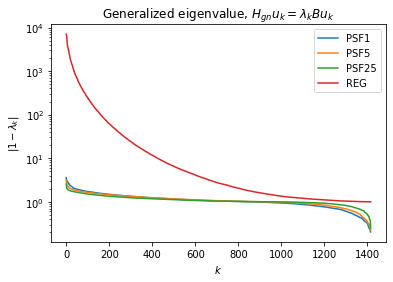

In [56]:
plt.figure()
for ee_gn in all_ee_gn:
#     plt.semilogy(np.sort(np.abs(1.0 - ee_gn))[::-1])
    plt.semilogy(np.sort(ee_gn)[::-1])
    
# plt.semilogy(np.sort(np.abs(1.0 - eeR_gn))[::-1])
plt.semilogy(np.sort(eeR_gn)[::-1])
plt.legend(['PSF' + str(nb) for nb in all_num_batches] + ['REG', 'None'])
plt.xlabel(r'$k$')
plt.ylabel(r'$|1 - \lambda_k|$')
plt.title(r'Generalized eigenvalue, $H_{gn} u_k = \lambda_k B u_k$')

In [57]:
all_ee = list()
all_P = list()
for nb, Hpch_dense in zip(all_num_batches, all_H_pch_dense):
    print('computing ee' + str(nb))
    ee, P = sla.eigh(H_dense, Hpch_dense)
    all_ee.append(ee)
    all_P.append(P)

print('computing eeR')
eeR, PR = sla.eigh(H_dense, reg_dense)
print('computing ee_none')
ee_none, P_none = sla.eigh(H_dense)

all_cond = list()
for ee in all_ee:
    all_cond.append(np.max(ee) / np.min(ee))
condR = np.max(eeR) / np.min(eeR)
cond_none = np.max(ee_none) / np.min(ee_none)

for nb, cond in zip(all_num_batches, all_cond):
    print('cond' + str(nb) + '=', cond)

print('condR=', condR)
print('cond_none=', cond_none)

computing ee1
computing ee5
computing ee25
computing eeR
computing ee_none
cond1= 17.525665851322636
cond5= 13.86107916473564
cond25= 10.34842046586369
condR= 7016.760785605505
cond_none= 871.177098437612


Text(0.5, 1.0, 'Generalized eigenvalue, $H u_k = \\lambda_k B u_k$')

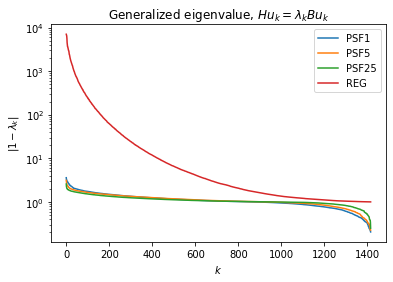

In [58]:
plt.figure()
for ee in all_ee:
#     plt.semilogy(np.sort(np.abs(1.0 - ee))[::-1])
    plt.semilogy(np.sort(ee)[::-1])
    
# plt.semilogy(np.sort(np.abs(1.0 - eeR))[::-1])
plt.semilogy(np.sort(eeR)[::-1])
plt.legend(['PSF' + str(nb) for nb in all_num_batches] + ['REG', 'None'])
plt.xlabel(r'$k$')
plt.ylabel(r'$|1 - \lambda_k|$')
plt.title(r'Generalized eigenvalue, $H u_k = \lambda_k B u_k$')

# Plots to make (6)
 - Preconditioned spectrum (Full newton)
 - Condition number table (Gauss-Newton and full Newton

In [59]:
for nb, ee in zip(all_num_batches, all_ee):
    np.savetxt(save_dir_str + '/generalized_eigenvalues_psf' + str(nb) + '.txt', ee)
np.savetxt(save_dir_str + '/generalized_eigenvalues_reg.txt', eeR)

for nb, ee_gn in zip(all_num_batches, all_ee_gn):
    np.savetxt(save_dir_str + '/generalized_eigenvalues_psf' + str(nb) + '_gn.txt', ee_gn)
np.savetxt(save_dir_str + '/generalized_eigenvalues_reg_gn.txt', eeR_gn)

np.savetxt(save_dir_str + '/all_num_batches.txt', all_num_batches)
np.savetxt(save_dir_str + '/cond_psf.txt', all_cond)
np.savetxt(save_dir_str + '/condR.txt', np.array([condR]))
np.savetxt(save_dir_str + '/cond_none.txt', np.array([cond_none]))

np.savetxt(save_dir_str + '/cond_psf_gn.txt', all_cond_gn)
np.savetxt(save_dir_str + '/condR_gn.txt', np.array([condR_gn]))
np.savetxt(save_dir_str + '/cond_none_gn.txt', np.array([cond_none_gn]))

ps = " "*14 + " | " + "{:>8}".format("None") + " " + "{:>8}".format("REG") + " "
for nb in all_num_batches:
    ps += "{:>8}".format("PSF" + str(nb)) + " "
ps += "\n"
ps += "-"*(34 + 9*len(all_num_batches)) + "\n"
ps += "cond(P^-1 H)   | " 
ps += "{:>8}".format(np.format_float_scientific(cond_none, precision=2, trim='k', unique=False)) + " "
ps += "{:>8}".format(np.format_float_scientific(condR, precision=2, trim='k', unique=False)) + " "
for c in all_cond:
    ps += "{:>8}".format(np.format_float_scientific(c, precision=2, trim='k', unique=False)) + " "
ps += "\n"
ps += "cond(P^-1 Hgn) | "
ps += "{:>8}".format(np.format_float_scientific(cond_none_gn, precision=2, trim='k', unique=False)) + " "
ps += "{:>8}".format(np.format_float_scientific(condR_gn, precision=2, trim='k', unique=False)) + " "
for c_gn in all_cond_gn:
    ps += "{:>8}".format(np.format_float_scientific(c_gn, precision=2, trim='k', unique=False)) + " "
ps += "\n"

print(ps)

#     ps += "{:>9}".format(np.format_float_scientific(g_psf, precision=2, trim='k', unique=False))
#     ps += " | "
#     ps += "{:<3d}".format(ncg_reg)

#           |  None    Reg   PSF3   PSF6   PSF9
#-----------------------------------------------
# P^-1 H    |  923.5   7762  15.59  14.16  13.96 
# P^-1 Hgn  |  978.0   7760  15.57  14.12  13.98

               |     None      REG     PSF1     PSF5    PSF25 
-------------------------------------------------------------
cond(P^-1 H)   | 8.71e+02 7.02e+03 1.75e+01 1.39e+01 1.03e+01 
cond(P^-1 Hgn) | 9.22e+02 7.02e+03 1.76e+01 1.39e+01 1.06e+01 



In [60]:
print('all_ee=', all_ee)
print('eeR', eeR)

print('all_ee_gn=', all_ee_gn)
print('eeR_gn', eeR_gn)

print('all_num_batches=', all_num_batches)

all_ee= [array([0.20479807, 0.21566055, 0.2244167 , ..., 3.19263348, 3.22725555,
       3.58922253]), array([0.22440423, 0.22527475, 0.23023981, ..., 2.55203292, 2.83170155,
       3.11048486]), array([0.24872499, 0.34108694, 0.38266717, ..., 2.16165625, 2.18867903,
       2.57391076])]
eeR [1.00048710e+00 1.00060306e+00 1.00082011e+00 ... 6.45111156e+03
 6.66462254e+03 7.02017867e+03]
all_ee_gn= [array([0.20389256, 0.21162739, 0.22384947, ..., 3.17981707, 3.22580176,
       3.58685758]), array([0.22367382, 0.22422584, 0.2298343 , ..., 2.55348454, 2.82985104,
       3.10119999]), array([0.24327598, 0.33851536, 0.38180181, ..., 2.15063821, 2.18520331,
       2.57253249])]
eeR_gn [1.00031942e+00 1.00053392e+00 1.00057603e+00 ... 6.44960234e+03
 6.66202687e+03 7.01813869e+03]
all_num_batches= [1, 5, 25]


# Regularization robustness plot

In [62]:
all_gammas = np.logspace(np.log10(5e3), np.log10(5e5), 7)[::-1]

b = np.random.randn(Vh2.dim())

sweep_tol = 1e-6
def first_good_iter(rr): # 1-based indexing
    return np.argwhere(rr < sweep_tol).reshape(-1)[0]+1

In [63]:
all_num_iter_sweep_gn = list()
num_iter_sweep_reg_gn = list()
num_iter_sweep_none_gn = list()
for gamma in all_gammas:
    print('---  GAMMA  ---:', gamma)
    REG.update_gamma(gamma)

    # Rebuild reg hmatrix with same block cluster tree as PCH data misfit hmatrix
    print('Building Regularization H-Matrix')
    R_hmatrix = REG.make_R_hmatrix(all_Hd_pch[0].bct, rtol=1e-6)

    all_H_pch = [Hd + R_hmatrix for Hd in all_Hd_pch]
    all_preconditioners = [H.factorized_inverse() for H in all_H_pch]

    ireg_linop = spla.LinearOperator((Vh2.dim(), Vh2.dim()), matvec=REG.solve_hessian_numpy)
    all_p_linop = [spla.LinearOperator((Vh2.dim(), Vh2.dim()), matvec=p.matvec) for p in all_preconditioners]

    print('GN: get truth:')
    x_true_gn_sweep, _, _, _ = cg_wrapper(Hgn_linop, b, all_p_linop[-1], tol=1e-10)

    all_relres_gn_sweep = list()
    all_errs_gn_sweep = list()
    for nb, p_linop in zip(all_num_batches, all_p_linop):
        print('GN: psf'+str(nb))
        _, _, relres_gn_sweep, errs_gn_sweep = cg_wrapper(Hgn_linop, b, p_linop, 
                                                          x_true=x_true_gn_sweep,
                                                          tol=1e-7)
        all_relres_gn_sweep.append(relres_gn_sweep)
        all_errs_gn_sweep.append(errs_gn_sweep)

    print('GN: reg')
    _, _, relres_gn_reg_sweep, errs_gn_reg_sweep = cg_wrapper(Hgn_linop, b, ireg_linop, 
                                                              x_true=x_true_gn_sweep,
                                                              tol=1e-7)

    print('GN: none')
    _, _, relres_gn_none_sweep, errs_gn_none_sweep = cg_wrapper(Hgn_linop, b, None, 
                                                                x_true=x_true_gn_sweep,
                                                                tol=1e-7)
    
    print('gamma=', gamma)
    all_num_iter_sweep_gn.append([])
    for k, relres_gn_sweep in enumerate(all_relres_gn_sweep):
        nb = all_num_batches[k]
        good_iter_psf = first_good_iter(relres_gn_sweep)
        all_num_iter_sweep_gn[-1].append(good_iter_psf)
        print('nb=', nb, ', good_iter_psf=', good_iter_psf)
        
    good_iter_reg = first_good_iter(relres_gn_reg_sweep)
    num_iter_sweep_reg_gn.append(good_iter_reg)
    print('good_iter_reg=', good_iter_reg)
    
    good_iter_none = first_good_iter(relres_gn_none_sweep)
    num_iter_sweep_none_gn.append(good_iter_none)
    print('good_iter_none=', good_iter_none)

---  GAMMA  ---: 499999.99999999994
Building Regularization H-Matrix
  matrix has dimension 1416 x 1416
    no of non-zeroes    = 9746
    matrix is             real valued
    format              = non symmetric
  size of sparse matrix = 163.52 kB
  |S|_F                 = 8.06144e+07
    sparsity constant = 20
    size of H-matrix  = 4.06 MB
    |A|_F             = 8.06144e+07
 |S-A|_2 = 2.38579e-09
  matrix has dimension ━━ H-matrix inverse ( rtol =  1416 x 1416
    no of non-zeroes    = 9746
    matrix is             real valued
    format              = symmetric
  size of sparse matrix = 163.52 kB
  |S|_F                 = 5.18561e+06
    sparsity constant = 20
    size of H-matrix  = 2.29 MB
    |A|_F             = 5.18561e+06
 |S-A|_2 = 4.66653e-09
1e-06 , atol =  1e-14 , overwrite= False  )


/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


    done in  11.692014932632446
    size of inverse =  3361874  bytes
                                                                 
━━ H-matrix multiplication C=A*B 
    done in 20.56s
    size of C = 4.02 MB
                                                                 
━━ H-matrix multiplication C=A*B 
    done in 27.93s
    size of C = 8.67 MB


                                                                 
━━ LU factorisation ( rtol = 1e-07 )
             GN: get truth:===-          ]  74% ETA 6 s (5.76 GB) 
    done in 27.02s                                               ==========-       ]  82% ETA 4 s (5.76 GB)
    size of LU factor = 19.83 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
    done in 26.71s                                                -                           ]  32% ETA 17 s (5.76 GB)                                                              
    size of LU factor = 19.59 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
                              ii= 0 , relres= 1.063279189915153 , err= nan
    done in 26.36s                                                                                              
    size of LU factor = 19.59 MB
ii= 1 , relres= 0.48673074050585924 , err= nan 

ii= 32 , relres= 0.11531419148151213 , err= 0.24321368785929953
ii= 33 , relres= 0.11491214604670795 , err= 0.23152152610816232
ii= 34 , relres= 0.11440433887238159 , err= 0.22075918262355534
ii= 35 , relres= 0.10570464163820907 , err= 0.21046463175109378
ii= 36 , relres= 0.09843952890186454 , err= 0.19967813934127795
ii= 37 , relres= 0.0950487945712745 , err= 0.18911899792120598
ii= 38 , relres= 0.09557222046657739 , err= 0.17900585250648152
ii= 39 , relres= 0.08925825122318064 , err= 0.16697138437126466
ii= 40 , relres= 0.08576213031462668 , err= 0.15532785996026435
ii= 41 , relres= 0.07794348081220334 , err= 0.14500402533218218
ii= 42 , relres= 0.07630671145079287 , err= 0.1352147856857762
ii= 43 , relres= 0.07402422108087685 , err= 0.1266254434958574
ii= 44 , relres= 0.07337029513746106 , err= 0.11769918342001814
ii= 45 , relres= 0.08171236044472334 , err= 0.10994237623052094
ii= 46 , relres= 0.07183100769604946 , err= 0.10322383800223449
ii= 47 , relres= 0.06243993061800838 , err=

ii= 154 , relres= 1.727368061744425e-05 , err= 1.5203726370127978e-05
ii= 155 , relres= 1.6450346054765935e-05 , err= 1.3662668366956419e-05
ii= 156 , relres= 1.5273278960560375e-05 , err= 1.2297504423132468e-05
ii= 157 , relres= 1.5243287870804622e-05 , err= 1.107633788893781e-05
ii= 158 , relres= 1.3372486295347535e-05 , err= 1.0169701752966308e-05
ii= 159 , relres= 1.113815932448434e-05 , err= 9.086898476388911e-06
ii= 160 , relres= 1.0411469476977172e-05 , err= 8.14678293138286e-06
ii= 161 , relres= 1.035294841285762e-05 , err= 7.460113517658547e-06
ii= 162 , relres= 8.217667517548041e-06 , err= 6.803613676230534e-06
ii= 163 , relres= 7.366731980176824e-06 , err= 5.997342949502732e-06
ii= 164 , relres= 6.47088623957384e-06 , err= 5.277373586416645e-06
ii= 165 , relres= 6.087221483524775e-06 , err= 4.719262130707141e-06
ii= 166 , relres= 5.760927236583221e-06 , err= 4.2981557874364596e-06
ii= 167 , relres= 4.881098432485414e-06 , err= 3.926209991242957e-06
ii= 168 , relres= 4.567595

ii= 13 , relres= 3.577967114145811e-08 , err= 2.1282304944262118e-08
GN: psf5
ii= 0 , relres= 0.46977525530308434 , err= 0.1944902286622361
ii= 1 , relres= 0.22396538477453387 , err= 0.08294693114287648
ii= 2 , relres= 0.056731366726406655 , err= 0.05885207670863469
ii= 3 , relres= 0.02825118954412645 , err= 0.01590307809028221
ii= 4 , relres= 0.01458555782803941 , err= 0.007331352413958272
ii= 5 , relres= 0.0037371617772297455 , err= 0.0027304559967110936
ii= 6 , relres= 0.0011762116831918765 , err= 0.0006099057859811401
ii= 7 , relres= 0.00025362153055087926 , err= 0.0001395037220806042
ii= 8 , relres= 6.1061147759406e-05 , err= 3.806621818275145e-05
ii= 9 , relres= 2.0068269071443113e-05 , err= 7.965826360704715e-06
ii= 10 , relres= 3.3058667197644803e-06 , err= 2.0360580323881034e-06
ii= 11 , relres= 7.691876708393042e-07 , err= 4.1425560481973963e-07
ii= 12 , relres= 1.7754433924748058e-07 , err= 8.908780593688008e-08
ii= 13 , relres= 3.415656817817812e-08 , err= 1.966252628882604

ii= 78 , relres= 0.0026924506734757655 , err= 0.0026380739478227113
ii= 79 , relres= 0.00258135550721236 , err= 0.0022784952218536467
ii= 80 , relres= 0.002591453070513434 , err= 0.002071625740224236
ii= 81 , relres= 0.0019963534205005543 , err= 0.0018332404999733772
ii= 82 , relres= 0.0017381219455815428 , err= 0.0015684400545443301
ii= 83 , relres= 0.0015992337037637745 , err= 0.0013450512027714853
ii= 84 , relres= 0.0014455417473438514 , err= 0.0011492407352478437
ii= 85 , relres= 0.0013537912500994715 , err= 0.0009772089804113262
ii= 86 , relres= 0.0012387204948374184 , err= 0.0008636837588679039
ii= 87 , relres= 0.0009625168087322577 , err= 0.0007676160936052202
ii= 88 , relres= 0.000807513893529114 , err= 0.000668754009291929
ii= 89 , relres= 0.0007438069234207606 , err= 0.000581826199389011
ii= 90 , relres= 0.0007529491345890748 , err= 0.000514303180734715
ii= 91 , relres= 0.0006332946490258369 , err= 0.00045961833874844896
ii= 92 , relres= 0.00046568696327256066 , err= 0.000400

ii= 0 , relres= 0.24687527927918707 , err= nan
ii= 1 , relres= 0.04658865550873907 , err= nan
ii= 2 , relres= 0.01626163291140586 , err= nan
ii= 3 , relres= 0.006549805929303358 , err= nan
ii= 4 , relres= 0.0015375856544489652 , err= nan
ii= 5 , relres= 0.0003213562328596892 , err= nan
ii= 6 , relres= 9.525664387260222e-05 , err= nan
ii= 7 , relres= 2.173159003410076e-05 , err= nan
ii= 8 , relres= 8.036288856093628e-06 , err= nan
ii= 9 , relres= 1.6315275177891015e-06 , err= nan
ii= 10 , relres= 2.625830819528505e-07 , err= nan
ii= 11 , relres= 7.280497135444582e-08 , err= nan
ii= 12 , relres= 1.2627335027888555e-08 , err= nan
ii= 13 , relres= 1.8544631737829582e-09 , err= nan
ii= 14 , relres= 2.6188622118067116e-10 , err= nan
ii= 15 , relres= 3.953964565533973e-11 , err= nan
GN: psf1
ii= 0 , relres= 0.2596736604390033 , err= 0.1251929044962036
ii= 1 , relres= 0.05244478325840443 , err= 0.048060819044855395
ii= 2 , relres= 0.01601132243024856 , err= 0.013798320721887747
ii= 3 , relres=

ii= 38 , relres= 0.02717620046683571 , err= 0.044206530116219174
ii= 39 , relres= 0.023312987996448032 , err= 0.03882651005795569
ii= 40 , relres= 0.021128454315345536 , err= 0.03420961780115992
ii= 41 , relres= 0.01884336263088503 , err= 0.030301560386195872
ii= 42 , relres= 0.018701189503684802 , err= 0.02657274435987306
ii= 43 , relres= 0.018639763842617826 , err= 0.023661526481143162
ii= 44 , relres= 0.017533695995464785 , err= 0.02120419534951744
ii= 45 , relres= 0.014844883730454853 , err= 0.018674454116223708
ii= 46 , relres= 0.012728944610577596 , err= 0.01604502255410552
ii= 47 , relres= 0.011018568350941513 , err= 0.013863787871645184
ii= 48 , relres= 0.010441087586593121 , err= 0.011997731635047904
ii= 49 , relres= 0.008995915575744312 , err= 0.010434024707256679
ii= 50 , relres= 0.00794261134952962 , err= 0.009068149781686246
ii= 51 , relres= 0.007273577435012484 , err= 0.007850027869618838
ii= 52 , relres= 0.005824223272415458 , err= 0.006743222878413462
ii= 53 , relres= 0

    done in 26.71s                                               
    size of LU factor = 23.28 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
[==================================      ]  85% ETA 4 s (5.80 ii= 0 , relres= 0.13834816022510613 , err= nan
    done in 27.30s                                               
    size of LU factor = 23.11 MB
ii= 1 , relres= 0.023325596419854593 , err= nan                  
ii= 2 , relres= 0.007600607442433326 , err= nan
ii= 3 , relres= 0.001386542004910362 , err= nan
ii= 4 , relres= 0.00024874251451650496 , err= nan
ii= 5 , relres= 4.43174568388678e-05 , err= nan
ii= 6 , relres= 9.923572578946783e-06 , err= nan
ii= 7 , relres= 1.5226632082615026e-06 , err= nan
ii= 8 , relres= 2.639975897250285e-07 , err= nan
ii= 9 , relres= 3.630581602213918e-08 , err= nan
ii= 10 , relres= 6.831832700914098e-09 , err= nan
ii= 11 , relres= 1.551519239552267e-09 , err= nan
ii= 12 , relres= 2.03622885017579

ii= 4 , relres= 0.5396090257286565 , err= 0.6355101765711494
ii= 5 , relres= 0.48048521236458125 , err= 0.5723671027185135
ii= 6 , relres= 0.41893192193504836 , err= 0.5119957065885337
ii= 7 , relres= 0.3528841816042526 , err= 0.4622230485819135
ii= 8 , relres= 0.31217032816547424 , err= 0.40797548534764067
ii= 9 , relres= 0.27960165723497815 , err= 0.36149918758143096
ii= 10 , relres= 0.251571709065308 , err= 0.31729249528547526
ii= 11 , relres= 0.23244143881710963 , err= 0.2739100668949
ii= 12 , relres= 0.19195241797942114 , err= 0.23973084777987183
ii= 13 , relres= 0.16934638204458216 , err= 0.20700131724207388
ii= 14 , relres= 0.1526417034893243 , err= 0.17963181635824566
ii= 15 , relres= 0.13143116169211347 , err= 0.15464280832217428
ii= 16 , relres= 0.11445941498923003 , err= 0.13458233550500384
ii= 17 , relres= 0.1000182215360251 , err= 0.1178792406271502
ii= 18 , relres= 0.08050499859455178 , err= 0.10464812454051789
ii= 19 , relres= 0.07289153820711738 , err= 0.092786206414029

    size of inverse =  3361874  bytes
                                                                  
━━ H-matrix multiplication C=A*B 
    done in 20.48s                                                
    size of C = 3.92 MB
                                                                 
━━ H-matrix multiplication C=A*B 
    done in 28.85s                                                
    size of C = 8.61 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
           GN: get truth:=====-          ]  74% ETA 7 s (5.81 GB) 
    done in 27.31s                                               ============-       ]  82% ETA 4 s (5.81 GB)
    size of LU factor = 23.54 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
    done in 27.07s                                                                                                          
    size of LU factor = 23.62 MB
     

ii= 56 , relres= 0.0070306060235144794 , err= 0.00292484672579567
ii= 57 , relres= 0.006307148543366422 , err= 0.0026903877867232146
ii= 58 , relres= 0.006106491697843917 , err= 0.00246652409172937
ii= 59 , relres= 0.005295914186996996 , err= 0.0022353718882792907
ii= 60 , relres= 0.0044720764870654316 , err= 0.0019161155196493534
ii= 61 , relres= 0.004003475676635653 , err= 0.0016619394532536205
ii= 62 , relres= 0.0036484831827040152 , err= 0.0015462108121389445
ii= 63 , relres= 0.00312046242351259 , err= 0.001353169414511393
ii= 64 , relres= 0.0030885361075793827 , err= 0.00115604690060305
ii= 65 , relres= 0.002697323357791252 , err= 0.001079932127444151
ii= 66 , relres= 0.0025749071009714126 , err= 0.000997148325438144
ii= 67 , relres= 0.0021498966174008493 , err= 0.0008633407407761992
ii= 68 , relres= 0.0019568560716965388 , err= 0.0007748400132334517
ii= 69 , relres= 0.0017657486531981262 , err= 0.0007153720261239752
ii= 70 , relres= 0.0016879279059518536 , err= 0.0006458804005618

ii= 14 , relres= 0.10560879804084773 , err= 0.14094510049106354
ii= 15 , relres= 0.09382416023673158 , err= 0.12074719758378581
ii= 16 , relres= 0.07989929608381686 , err= 0.10422751181201428
ii= 17 , relres= 0.06914701356336087 , err= 0.08947904239920215
ii= 18 , relres= 0.057434528437683464 , err= 0.07687319635483653
ii= 19 , relres= 0.04861198972050924 , err= 0.06631646122539467
ii= 20 , relres= 0.042109984354076604 , err= 0.05724807626089412
ii= 21 , relres= 0.034638425451336455 , err= 0.050284690263096496
ii= 22 , relres= 0.028184289120827755 , err= 0.04404454842335487
ii= 23 , relres= 0.023649762399973573 , err= 0.03881480547963122
ii= 24 , relres= 0.020421211999354972 , err= 0.034149296405415
ii= 25 , relres= 0.01799696565726243 , err= 0.029799029401808518
ii= 26 , relres= 0.016027636156797424 , err= 0.025614676750622192
ii= 27 , relres= 0.014477794772463439 , err= 0.021569177137802778
ii= 28 , relres= 0.01304737641666856 , err= 0.01802848094699803
ii= 29 , relres= 0.01215980530

ii= 2 , relres= 0.03501427314072797 , err= nan
ii= 3 , relres= 0.011397850777935556 , err= nan
ii= 4 , relres= 0.004336613155175277 , err= nan
ii= 5 , relres= 0.002124732184392992 , err= nan
ii= 6 , relres= 0.0009213590972246631 , err= nan
ii= 7 , relres= 0.00037108758938686227 , err= nan
ii= 8 , relres= 0.00013282504172942972 , err= nan
ii= 9 , relres= 4.733101787549631e-05 , err= nan
ii= 10 , relres= 2.047812890378889e-05 , err= nan
ii= 11 , relres= 8.46612500827734e-06 , err= nan
ii= 12 , relres= 3.0596642562355582e-06 , err= nan
ii= 13 , relres= 1.1209970990933556e-06 , err= nan
ii= 14 , relres= 3.641897899770058e-07 , err= nan
ii= 15 , relres= 1.1569271863347648e-07 , err= nan
ii= 16 , relres= 3.50693639650021e-08 , err= nan
ii= 17 , relres= 1.1631379786490367e-08 , err= nan
ii= 18 , relres= 4.417554575239714e-09 , err= nan
ii= 19 , relres= 1.41140362817738e-09 , err= nan
ii= 20 , relres= 4.2054289181695503e-10 , err= nan
ii= 21 , relres= 1.2035249554220624e-10 , err= nan
ii= 22 ,

ii= 50 , relres= 0.21592691034800018 , err= 0.08957318215453343
ii= 51 , relres= 0.20902075944325987 , err= 0.08806493455919824
ii= 52 , relres= 0.19678748455579795 , err= 0.08340062262487545
ii= 53 , relres= 0.18949658667619323 , err= 0.07795458565308662
ii= 54 , relres= 0.18446568492386486 , err= 0.07647486027690374
ii= 55 , relres= 0.16013514742408314 , err= 0.07104280018540353
ii= 56 , relres= 0.1587844821045276 , err= 0.06766842286854816
ii= 57 , relres= 0.15285080820862315 , err= 0.06544276803064678
ii= 58 , relres= 0.15182888050085533 , err= 0.06279325082935999
ii= 59 , relres= 0.13968896324361993 , err= 0.060449844776816725
ii= 60 , relres= 0.12783216690897195 , err= 0.056417758168911994
ii= 61 , relres= 0.12245583393615134 , err= 0.052820450119122994
ii= 62 , relres= 0.1175367801428256 , err= 0.05110211056244787
ii= 63 , relres= 0.11172726151223103 , err= 0.04829275949557969
ii= 64 , relres= 0.1094198739363628 , err= 0.04760796748611231
ii= 65 , relres= 0.1039680364118674 , er

ii= 173 , relres= 0.00044427934289382114 , err= 0.00015138676379726604
ii= 174 , relres= 0.00045925534735845607 , err= 0.00014655671759569242
ii= 175 , relres= 0.000447607853964187 , err= 0.0001424788227077779
ii= 176 , relres= 0.00042453750998936086 , err= 0.00013325252043882525
ii= 177 , relres= 0.00041505597897732336 , err= 0.00012812738387674006
ii= 178 , relres= 0.00035024568831592683 , err= 0.00012184062129022795
ii= 179 , relres= 0.0003243688541308356 , err= 0.00011182283961945607
ii= 180 , relres= 0.0003103239368767581 , err= 0.00010768561784961488
ii= 181 , relres= 0.0003388283690234894 , err= 0.0001043522600311119
ii= 182 , relres= 0.00030985383770133285 , err= 9.836877779170785e-05
ii= 183 , relres= 0.00028403890383733486 , err= 9.451158571978136e-05
ii= 184 , relres= 0.00026548279353375047 , err= 9.010011649069755e-05
ii= 185 , relres= 0.0002594690708651105 , err= 8.410003042174807e-05
ii= 186 , relres= 0.0002478774839051484 , err= 8.235565053616608e-05
ii= 187 , relres= 0.

ii= 291 , relres= 1.1334450491385617e-06 , err= 3.4741149701527273e-07
ii= 292 , relres= 1.0770771760184169e-06 , err= 3.312926855456567e-07
ii= 293 , relres= 1.0315106167701753e-06 , err= 3.248463907020287e-07
ii= 294 , relres= 1.0116194730108283e-06 , err= 2.990554082436264e-07
ii= 295 , relres= 9.45374584096554e-07 , err= 2.868620257972397e-07
ii= 296 , relres= 8.032919091971854e-07 , err= 2.701797648038728e-07
ii= 297 , relres= 8.575991848102406e-07 , err= 2.6229476255873297e-07
ii= 298 , relres= 8.305321590307367e-07 , err= 2.5030574543302536e-07
ii= 299 , relres= 7.839967177113903e-07 , err= 2.3537550161352705e-07
ii= 300 , relres= 6.98033224095347e-07 , err= 2.258465735775212e-07
ii= 301 , relres= 6.634990997650757e-07 , err= 2.1824048671017957e-07
ii= 302 , relres= 6.156829422657606e-07 , err= 2.0021222048101042e-07
ii= 303 , relres= 6.109431959247855e-07 , err= 1.865728283871444e-07
ii= 304 , relres= 5.539533651839378e-07 , err= 1.8119861863556778e-07
ii= 305 , relres= 5.64057

ii= 71 , relres= 0.0011910829686612209 , err= 0.0013096192401251838
ii= 72 , relres= 0.0012126021288903438 , err= 0.00116727442212223
ii= 73 , relres= 0.0011998163433420504 , err= 0.0010484647638670126
ii= 74 , relres= 0.0010595914350560922 , err= 0.0009759067787205912
ii= 75 , relres= 0.0008903003011073324 , err= 0.000879091084985161
ii= 76 , relres= 0.0010484484130218654 , err= 0.0007990554722518283
ii= 77 , relres= 0.0007087756789641913 , err= 0.0007202570972418341
ii= 78 , relres= 0.0006103016899792417 , err= 0.0006261423865744114
ii= 79 , relres= 0.0005406114863122315 , err= 0.0005479636993726953
ii= 80 , relres= 0.0004903207128031914 , err= 0.00048230602928053394
ii= 81 , relres= 0.00042446246187359586 , err= 0.0004214406923324219
ii= 82 , relres= 0.00043958487506744106 , err= 0.000375903322048094
ii= 83 , relres= 0.00037120025670656456 , err= 0.0003512149855361105
ii= 84 , relres= 0.0002689848464541113 , err= 0.00030976390063257547
ii= 85 , relres= 0.0002651503285200935 , err= 0

ii= 13 , relres= 0.0003758479727022376 , err= 0.00013682082195940677
ii= 14 , relres= 0.00016992748252304387 , err= 7.019788561420123e-05
ii= 15 , relres= 8.811097345987317e-05 , err= 3.1078546535984976e-05
ii= 16 , relres= 4.620116071335566e-05 , err= 1.4270321582334615e-05
ii= 17 , relres= 2.2701319988347517e-05 , err= 7.818057029869051e-06
ii= 18 , relres= 1.1799758593800042e-05 , err= 4.228405725252515e-06
ii= 19 , relres= 6.619346915290057e-06 , err= 2.0981805515308304e-06
ii= 20 , relres= 3.376536375709346e-06 , err= 9.63194941426742e-07
ii= 21 , relres= 1.7966742817310147e-06 , err= 5.362186643702507e-07
ii= 22 , relres= 8.291082350893098e-07 , err= 2.83786304049251e-07
ii= 23 , relres= 4.06875781287155e-07 , err= 1.4690745843608255e-07
ii= 24 , relres= 1.862645682444312e-07 , err= 6.956704131809402e-08
ii= 25 , relres= 9.714200155482449e-08 , err= 3.292556275785442e-08
GN: reg
ii= 0 , relres= 1.0437602024959947 , err= 0.9979672322240524
ii= 1 , relres= 1.1159650571979562 , err=

ii= 117 , relres= 0.16880870899427317 , err= 0.06963982980412604
ii= 118 , relres= 0.1716194018004088 , err= 0.06684701437855628
ii= 119 , relres= 0.16723980293111082 , err= 0.0651932964781353
ii= 120 , relres= 0.1580936657009086 , err= 0.06319245470753868
ii= 121 , relres= 0.15732456762204933 , err= 0.06225792975900148
ii= 122 , relres= 0.16666662232887522 , err= 0.06026749226902556
ii= 123 , relres= 0.1438302501411762 , err= 0.05913831507629871
ii= 124 , relres= 0.1548240777481713 , err= 0.05669632384891125
ii= 125 , relres= 0.14490215744248106 , err= 0.05610276226853724
ii= 126 , relres= 0.15159935132660585 , err= 0.05534786931301761
ii= 127 , relres= 0.1358006548440567 , err= 0.05346698784962444
ii= 128 , relres= 0.13363659254986734 , err= 0.0525798797868848
ii= 129 , relres= 0.1317580469890655 , err= 0.051868484690882344
ii= 130 , relres= 0.12145556135598062 , err= 0.05008281261322852
ii= 131 , relres= 0.12554708747213328 , err= 0.048249813428042125
ii= 132 , relres= 0.12011711527

ii= 242 , relres= 0.009224133998748454 , err= 0.003118031176444613
ii= 243 , relres= 0.009033424413134853 , err= 0.0030897841555543575
ii= 244 , relres= 0.009113235042624113 , err= 0.002999827853926494
ii= 245 , relres= 0.008187170939639084 , err= 0.0029325212802821655
ii= 246 , relres= 0.008876784543874484 , err= 0.0028779675206415676
ii= 247 , relres= 0.008819699267399492 , err= 0.0027859958047866595
ii= 248 , relres= 0.007638703014917983 , err= 0.0027368639210315214
ii= 249 , relres= 0.00810064551435558 , err= 0.002697225494011127
ii= 250 , relres= 0.008391575439698623 , err= 0.002638223609743445
ii= 251 , relres= 0.007385584579114415 , err= 0.0025715549776565106
ii= 252 , relres= 0.0077372803983674415 , err= 0.002512773634527549
ii= 253 , relres= 0.0070701887922009375 , err= 0.002418609801911391
ii= 254 , relres= 0.006678898903080871 , err= 0.0023516817783913774
ii= 255 , relres= 0.0066131694540810205 , err= 0.002282610475593728
ii= 256 , relres= 0.006217428153179861 , err= 0.00220

ii= 362 , relres= 0.0005299809009063032 , err= 0.00018401928680830806
ii= 363 , relres= 0.0004932673229596493 , err= 0.00017895706497271963
ii= 364 , relres= 0.000513330042559887 , err= 0.00017082823494918138
ii= 365 , relres= 0.0004658178539152046 , err= 0.00016822428371346916
ii= 366 , relres= 0.0004586117842987244 , err= 0.00016559761188585329
ii= 367 , relres= 0.0005025327573811396 , err= 0.0001621320912252161
ii= 368 , relres= 0.00045947348898736835 , err= 0.0001598648641635995
ii= 369 , relres= 0.0004535301991832187 , err= 0.0001539933590152413
ii= 370 , relres= 0.0004334961960884299 , err= 0.00015156969304307388
ii= 371 , relres= 0.0004543813056451894 , err= 0.00014916829812883467
ii= 372 , relres= 0.0004166686224175947 , err= 0.00014710431874364734
ii= 373 , relres= 0.000423145343130848 , err= 0.0001440401169674623
ii= 374 , relres= 0.0003904937120245787 , err= 0.00013996565894119458
ii= 375 , relres= 0.00037012003731653586 , err= 0.00013807276328120006
ii= 376 , relres= 0.0003

ii= 480 , relres= 3.5867525028608894e-05 , err= 1.1277952164600987e-05
ii= 481 , relres= 3.271643652628274e-05 , err= 1.1068406612591406e-05
ii= 482 , relres= 3.2477109087529335e-05 , err= 1.0887802476304612e-05
ii= 483 , relres= 3.598110592411952e-05 , err= 1.072290331598873e-05
ii= 484 , relres= 2.942866708418097e-05 , err= 1.0202636654133916e-05
ii= 485 , relres= 2.968092348060884e-05 , err= 9.99637477749417e-06
ii= 486 , relres= 2.9399004802289464e-05 , err= 9.595814401062154e-06
ii= 487 , relres= 2.6376691519125023e-05 , err= 9.214263937058722e-06
ii= 488 , relres= 2.5702070274767084e-05 , err= 9.048734954206664e-06
ii= 489 , relres= 2.714658839099051e-05 , err= 8.80315219635188e-06
ii= 490 , relres= 2.442563775876976e-05 , err= 8.524784941815937e-06
ii= 491 , relres= 2.715931694594202e-05 , err= 8.2865381844027e-06
ii= 492 , relres= 2.316872775476349e-05 , err= 8.109447690897122e-06
ii= 493 , relres= 2.2877599518691386e-05 , err= 8.051879722018925e-06
ii= 494 , relres= 2.43080336

ii= 598 , relres= 1.83374259065553e-06 , err= 6.674998712575047e-07
ii= 599 , relres= 1.8971747508635244e-06 , err= 6.594870607765502e-07
ii= 600 , relres= 1.8532107410212902e-06 , err= 6.509376995065789e-07
ii= 601 , relres= 2.024528345160707e-06 , err= 6.23648450546746e-07
ii= 602 , relres= 1.8418013951694578e-06 , err= 6.15331372032049e-07
ii= 603 , relres= 1.7511830493620836e-06 , err= 5.96912478264623e-07
ii= 604 , relres= 1.8178318947032915e-06 , err= 5.89236425169885e-07
ii= 605 , relres= 1.590334965568675e-06 , err= 5.76730678399738e-07
ii= 606 , relres= 1.6960203727502035e-06 , err= 5.633093939171282e-07
ii= 607 , relres= 1.7181579505544306e-06 , err= 5.499745845185313e-07
ii= 608 , relres= 1.67461743470196e-06 , err= 5.301237337441421e-07
ii= 609 , relres= 1.6189465763971988e-06 , err= 5.084237460380835e-07
ii= 610 , relres= 1.4545293774343777e-06 , err= 4.956847035849588e-07
ii= 611 , relres= 1.410906432311875e-06 , err= 4.908462607887165e-07
ii= 612 , relres= 1.533234774925

ii= 716 , relres= 1.205003324944846e-07 , err= 3.9784524716408584e-08
ii= 717 , relres= 1.1424908103518347e-07 , err= 3.8796098137301536e-08
ii= 718 , relres= 1.0761461587711676e-07 , err= 3.7520005804852724e-08
ii= 719 , relres= 1.0314539736128094e-07 , err= 3.571073627926581e-08
ii= 720 , relres= 1.0107748929530505e-07 , err= 3.5070223736657133e-08
ii= 721 , relres= 9.657344280271703e-08 , err= 3.472683608978406e-08
GN: none
ii= 0 , relres= 1.7998822036496183 , err= 0.9607754379299388
ii= 1 , relres= 1.6320083169869368 , err= 0.9238043406215309
ii= 2 , relres= 1.5300990980764357 , err= 0.8862505957115849
ii= 3 , relres= 1.293491835637571 , err= 0.8576353348776828
ii= 4 , relres= 1.277031008233619 , err= 0.8223245828294179
ii= 5 , relres= 1.1872164822042266 , err= 0.7959416138910144
ii= 6 , relres= 1.0392485033316259 , err= 0.7649434764394949
ii= 7 , relres= 1.005293145797907 , err= 0.7320199885682038
ii= 8 , relres= 0.9703237399230883 , err= 0.6950125027314484
ii= 9 , relres= 0.89623

ii= 120 , relres= 0.0007351004087711995 , err= 0.0006295005373873454
ii= 121 , relres= 0.0007187747747896413 , err= 0.0005832972666238363
ii= 122 , relres= 0.0007063366644020955 , err= 0.0005534152945090836
ii= 123 , relres= 0.0005736891339987608 , err= 0.0005185440323151547
ii= 124 , relres= 0.0005290378184303053 , err= 0.0004806142080954676
ii= 125 , relres= 0.0005569059695027856 , err= 0.00044965139639722025
ii= 126 , relres= 0.0005098285815563602 , err= 0.0004261161158539281
ii= 127 , relres= 0.00045931174664384176 , err= 0.0003961294566168403
ii= 128 , relres= 0.0004360144262876434 , err= 0.00036999161827819005
ii= 129 , relres= 0.00040852950735735717 , err= 0.00035002096685089404
ii= 130 , relres= 0.00033793154822055687 , err= 0.0003245743671164454
ii= 131 , relres= 0.00035015470401351956 , err= 0.0002962720403178423
ii= 132 , relres= 0.00036644642679912104 , err= 0.0002801669922806529
ii= 133 , relres= 0.00033443671447346316 , err= 0.0002596181325436681
ii= 134 , relres= 0.00035

ii= 238 , relres= 3.406922637920611e-07 , err= 3.4118365862509234e-07
ii= 239 , relres= 3.3377056700739115e-07 , err= 3.2065970458758135e-07
ii= 240 , relres= 3.355499222983446e-07 , err= 3.0259352612894736e-07
ii= 241 , relres= 3.2714787794795575e-07 , err= 2.8250105057794894e-07
ii= 242 , relres= 2.528975422737976e-07 , err= 2.6677665827328873e-07
ii= 243 , relres= 2.5282857456211175e-07 , err= 2.4424887299581256e-07
ii= 244 , relres= 2.5750261685201645e-07 , err= 2.310398794361486e-07
ii= 245 , relres= 2.069310997299773e-07 , err= 2.1368884190702314e-07
ii= 246 , relres= 2.400323071173513e-07 , err= 1.9310139433921793e-07
ii= 247 , relres= 2.197438594131103e-07 , err= 1.8688955782276292e-07
ii= 248 , relres= 1.8907961970344383e-07 , err= 1.7307032074449047e-07
ii= 249 , relres= 1.7140044602644415e-07 , err= 1.5967768058666872e-07
ii= 250 , relres= 1.5041389784629943e-07 , err= 1.4606332780907226e-07
ii= 251 , relres= 2.0348229071245957e-07 , err= 1.3741171092060066e-07
ii= 252 , rel

In [64]:
print('all_num_iter_sweep_gn=', all_num_iter_sweep_gn)
print('num_iter_sweep_reg_gn=', num_iter_sweep_reg_gn)
print('num_iter_sweep_none_gn=', num_iter_sweep_none_gn)

all_num_iter_sweep_gn= [[15, 15, 15], [12, 12, 12], [11, 11, 11], [9, 9, 9], [12, 11, 10], [20, 17, 15], [36, 30, 23]]
num_iter_sweep_reg_gn= [9, 17, 33, 67, 140, 296, 628]
num_iter_sweep_none_gn= [186, 152, 119, 99, 87, 145, 220]


In [65]:
# all_num_iter_sweep= [[15, 15, 15], [12, 11, 11], [9, 9, 9], [16, 14, 11], [37, 32, 23]]
# num_iter_sweep_reg= [9, 23, 68, 205, 627]
# num_iter_sweep_none= [187, 132, 97, 110, 220]
all_num_iter_sweep_gn = np.array(all_num_iter_sweep_gn)
num_iter_sweep_reg_gn = np.array(num_iter_sweep_reg_gn)
num_iter_sweep_none_gn = np.array(num_iter_sweep_none_gn)

print('all_gammas', all_gammas)
print('all_num_iter_sweep_gn', all_num_iter_sweep_gn)
print('num_iter_sweep_reg_gn=', num_iter_sweep_reg_gn)
print('num_iter_sweep_none_gn=', num_iter_sweep_none_gn)

np.savetxt(save_dir_str + '/all_gammas.txt', all_gammas)
np.savetxt(save_dir_str + '/all_num_iter_sweep_gn.txt', all_num_iter_sweep_gn)
np.savetxt(save_dir_str + '/num_iter_sweep_reg_gn.txt', num_iter_sweep_reg_gn)
np.savetxt(save_dir_str + '/num_iter_sweep_none_gn.txt', num_iter_sweep_none_gn)

all_gammas [500000.         232079.44168064 107721.73450159  50000.
  23207.94416806  10772.17345016   5000.        ]
all_num_iter_sweep_gn [[15 15 15]
 [12 12 12]
 [11 11 11]
 [ 9  9  9]
 [12 11 10]
 [20 17 15]
 [36 30 23]]
num_iter_sweep_reg_gn= [  9  17  33  67 140 296 628]
num_iter_sweep_none_gn= [186 152 119  99  87 145 220]


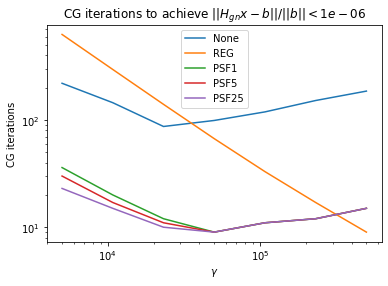

In [66]:
plt.loglog(all_gammas, num_iter_sweep_none_gn)
plt.loglog(all_gammas, num_iter_sweep_reg_gn)
for k in range(len(all_num_batches)):
    plt.loglog(all_gammas, all_num_iter_sweep_gn[:,k])

plt.title(r'CG iterations to achieve $||H_{gn}x-b||/||b|| < ' + str(sweep_tol) + '$')
plt.xlabel(r'$\gamma$')
plt.ylabel('CG iterations')
plt.legend(['None', 'REG'] + ['PSF'+str(nb) for nb in all_num_batches])

In [67]:
all_num_iter_sweep = list()
num_iter_sweep_reg = list()
num_iter_sweep_none = list()
for gamma in all_gammas:
    print('---  GAMMA  ---:', gamma)
    REG.update_gamma(gamma)

    # Rebuild reg hmatrix with same block cluster tree as PCH data misfit hmatrix
    print('Building Regularization H-Matrix')
    R_hmatrix = REG.make_R_hmatrix(all_Hd_pch[0].bct, rtol=1e-6)

    all_H_pch = [Hd + R_hmatrix for Hd in all_Hd_pch]
    all_preconditioners = [H.factorized_inverse() for H in all_H_pch]

    ireg_linop = spla.LinearOperator((Vh2.dim(), Vh2.dim()), matvec=REG.solve_hessian_numpy)
    all_p_linop = [spla.LinearOperator((Vh2.dim(), Vh2.dim()), matvec=p.matvec) for p in all_preconditioners]

    print('FULL: get truth:')
    x_true_sweep, _, _, _ = cg_wrapper(H_linop, b, all_p_linop[-1], tol=1e-10)

    all_relres_sweep = list()
    all_errs_sweep = list()
    for nb, p_linop in zip(all_num_batches, all_p_linop):
        print('FULL: psf'+str(nb))
        _, _, relres_sweep, errs_sweep = cg_wrapper(H_linop, b, p_linop, 
                                                    x_true=x_true_sweep,
                                                    tol=1e-7)
        all_relres_sweep.append(relres_sweep)
        all_errs_sweep.append(errs_sweep)

    print('FULL: reg')
    _, _, relres_reg_sweep, errs_reg_sweep = cg_wrapper(H_linop, b, ireg_linop, 
                                                        x_true=x_true_sweep,
                                                        tol=1e-7)

    print('FULL: none')
    _, _, relres_none_sweep, errs_none_sweep = cg_wrapper(H_linop, b, None, 
                                                          x_true=x_true_sweep,
                                                          tol=1e-7)
    
    print('gamma=', gamma)
    all_num_iter_sweep.append([])
    for k, relres_sweep in enumerate(all_relres_sweep):
        nb = all_num_batches[k]
        good_iter_psf = first_good_iter(relres_sweep)
        all_num_iter_sweep[-1].append(good_iter_psf)
        print('nb=', nb, ', good_iter_psf=', good_iter_psf)
        
    good_iter_reg = first_good_iter(relres_reg_sweep)
    num_iter_sweep_reg.append(good_iter_reg)
    print('good_iter_reg=', good_iter_reg)
    
    good_iter_none = first_good_iter(relres_none_sweep)
    num_iter_sweep_none.append(good_iter_none)
    print('good_iter_none=', good_iter_none)

---  GAMMA  ---: 499999.99999999994
Building Regularization H-Matrix
  matrix has dimension 1416 x 1416
    no of non-zeroes    = 9746
    matrix is             real valued
    format              = non symmetric
  size of sparse matrix = 163.52 kB
  |S|_F                 = 8.06144e+07
    sparsity constant = 20
    size of H-matrix  = 4.06 MB
    |A|_F             = 8.06144e+07
 |S-A|_2 = 2.38579e-09
  matrix has dimension ━━ H-matrix inverse ( rtol =  1e-06 , atol =  1e-14 , overwrite= False  )


/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


    done in 1416 x 1416
    no of non-zeroes    = 9746
    matrix is             real valued
    format              = symmetric
  size of sparse matrix = 163.52 kB
  |S|_F                 = 5.18561e+06
    sparsity constant = 20
    size of H-matrix  = 2.29 MB
    |A|_F             = 5.18561e+06
 |S-A|_2 = 4.66653e-09
 12.090587377548218
    size of inverse =  3361874  bytes
                                                                 
━━ H-matrix multiplication C=A*B 
    done in 20.26s
    size of C = 4.02 MB


                                                                 
━━ H-matrix multiplication C=A*B 
    done in 28.70s
    size of C = 8.67 MB


                                                                 
━━ LU factorisation ( rtol = 1e-07 )
[======================================- ]  9FULL: get truth:     
    done in 26.71s                                               
    size of LU factor = 19.83 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
    done in 26.74s                                                                                    
    size of LU factor = 19.58 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
    done in 26.66s                                                                                                          ============================-           ]  72% ETA 7 s (5.83 GB)
    size of LU factor = 19.59 MB
ii= 0 , relres= 1.0631862208327747 , err= nan                    
ii= 1 , relres= 0.48669970484770186 , err= nan
ii= 2 , relres= 0.16758458267436105 , err= nan
ii= 3 ,

ii= 33 , relres= 0.11488312793215659 , err= 0.23147089474976987
ii= 34 , relres= 0.11437517587396821 , err= 0.22070983595774593
ii= 35 , relres= 0.10567776474800211 , err= 0.21041638248419847
ii= 36 , relres= 0.0984148278671668 , err= 0.19963096510943726
ii= 37 , relres= 0.0950249722330875 , err= 0.1890728586405296
ii= 38 , relres= 0.09554812594246663 , err= 0.17896071320303608
ii= 39 , relres= 0.08923525328281198 , err= 0.16692751316282733
ii= 40 , relres= 0.08573936621395094 , err= 0.15528541817924654
ii= 41 , relres= 0.07792111909090008 , err= 0.14496299765436726
ii= 42 , relres= 0.0762762833323146 , err= 0.1351747873198261
ii= 43 , relres= 0.07394876601618251 , err= 0.1265824421710987
ii= 44 , relres= 0.07296212029328916 , err= 0.11762381946546407
ii= 45 , relres= 0.0811473855748144 , err= 0.10971630652642173
ii= 46 , relres= 0.07242615895070514 , err= 0.10310117013596044
ii= 47 , relres= 0.06252003711677143 , err= 0.09543054029906861
ii= 48 , relres= 0.062334450011607506 , err= 0.

ii= 156 , relres= 1.580662791548832e-05 , err= 1.2711927308391028e-05
ii= 157 , relres= 1.4636269266460381e-05 , err= 1.1435919319012344e-05
ii= 158 , relres= 1.253663638324682e-05 , err= 1.0262018068648441e-05
ii= 159 , relres= 1.175768269533553e-05 , err= 9.149289403417358e-06
ii= 160 , relres= 1.1389936434234769e-05 , err= 8.33925121646152e-06
ii= 161 , relres= 9.504874057811025e-06 , err= 7.596718466758194e-06
ii= 162 , relres= 7.952345970983886e-06 , err= 6.811240639960139e-06
ii= 163 , relres= 7.346897437479756e-06 , err= 5.989906817618548e-06
ii= 164 , relres= 6.513768865453026e-06 , err= 5.2730038469865e-06
ii= 165 , relres= 6.235302401629196e-06 , err= 4.730307109760064e-06
ii= 166 , relres= 5.709485732515195e-06 , err= 4.316119865460539e-06
ii= 167 , relres= 4.782018892190175e-06 , err= 3.9233934106304695e-06
ii= 168 , relres= 4.531278946851128e-06 , err= 3.5797200009863147e-06
ii= 169 , relres= 4.600903884881056e-06 , err= 3.3363889610086783e-06
ii= 170 , relres= 3.640035403

ii= 0 , relres= 0.469708352976905 , err= 0.1946530569853382
ii= 1 , relres= 0.22400357645992605 , err= 0.08290860770978788
ii= 2 , relres= 0.056733041602708166 , err= 0.05882811381453561
ii= 3 , relres= 0.028243137937780178 , err= 0.015918381168916272
ii= 4 , relres= 0.014594296642061652 , err= 0.007329276634263276
ii= 5 , relres= 0.003735258139284126 , err= 0.002729911901605664
ii= 6 , relres= 0.0011760910038258066 , err= 0.0006096563362111322
ii= 7 , relres= 0.0002534952196905719 , err= 0.0001395216561959574
ii= 8 , relres= 6.106948831933621e-05 , err= 3.8040452059607936e-05
ii= 9 , relres= 2.0051169285560113e-05 , err= 7.969342250917863e-06
ii= 10 , relres= 3.3002666020969846e-06 , err= 2.0349689140417144e-06
ii= 11 , relres= 7.695233601728884e-07 , err= 4.137846599575336e-07
ii= 12 , relres= 1.7731665512883246e-07 , err= 8.923142489618402e-08
ii= 13 , relres= 3.425793055667444e-08 , err= 1.9575979426672806e-08
FULL: psf25
ii= 0 , relres= 0.46618371518502943 , err= 0.191215990732912

ii= 78 , relres= 0.0026900007887921944 , err= 0.0026369160790340514
ii= 79 , relres= 0.0027118448207056186 , err= 0.0022887599397425546
ii= 80 , relres= 0.002497275511981644 , err= 0.002087327076229286
ii= 81 , relres= 0.0019715816980394006 , err= 0.0018315692429763072
ii= 82 , relres= 0.0017337994982318395 , err= 0.0015654621934888566
ii= 83 , relres= 0.001595678386368622 , err= 0.0013423436941244972
ii= 84 , relres= 0.001440153660604811 , err= 0.0011466598471177902
ii= 85 , relres= 0.0013389928593533296 , err= 0.0009737662403375159
ii= 86 , relres= 0.0012365118867017923 , err= 0.0008595848618081337
ii= 87 , relres= 0.0009651001481515825 , err= 0.0007656004905451869
ii= 88 , relres= 0.0008058961636830139 , err= 0.0006673680366561309
ii= 89 , relres= 0.0007384955770867814 , err= 0.0005803761276241119
ii= 90 , relres= 0.0007460836583969298 , err= 0.0005119526263033051
ii= 91 , relres= 0.0006362492454443976 , err= 0.00045806288862974056
ii= 92 , relres= 0.000465118317685718 , err= 0.0003

ii= 0 , relres= 0.24682860538615073 , err= nan
ii= 1 , relres= 0.04663394571636879 , err= nan
ii= 2 , relres= 0.01625524297973522 , err= nan
ii= 3 , relres= 0.006554866429639036 , err= nan
ii= 4 , relres= 0.001539871877859575 , err= nan
ii= 5 , relres= 0.00032134678783986894 , err= nan
ii= 6 , relres= 9.472666586291675e-05 , err= nan
ii= 7 , relres= 2.1633325644607946e-05 , err= nan
ii= 8 , relres= 8.055181624912555e-06 , err= nan
ii= 9 , relres= 1.6284025856498707e-06 , err= nan
ii= 10 , relres= 2.627556318030791e-07 , err= nan
ii= 11 , relres= 7.291604123041234e-08 , err= nan
ii= 12 , relres= 1.2676895032784443e-08 , err= nan
ii= 13 , relres= 1.8606191081892397e-09 , err= nan
ii= 14 , relres= 2.6117852405482287e-10 , err= nan
ii= 15 , relres= 3.92299525697328e-11 , err= nan
FULL: psf1
ii= 0 , relres= 0.259627811059379 , err= 0.125346833639271
ii= 1 , relres= 0.05250125298894541 , err= 0.04803496754662429
ii= 2 , relres= 0.016005839034064454 , err= 0.0138023781159319
ii= 3 , relres= 0

ii= 38 , relres= 0.027123397173450307 , err= 0.0440980835878075
ii= 39 , relres= 0.023264076437066863 , err= 0.038727758511983526
ii= 40 , relres= 0.021079329699266427 , err= 0.03412046472805305
ii= 41 , relres= 0.018778674463696934 , err= 0.03021942547045758
ii= 42 , relres= 0.01846623101713151 , err= 0.026475936757620885
ii= 43 , relres= 0.018166876025258398 , err= 0.023475079353344225
ii= 44 , relres= 0.017712811053703145 , err= 0.021002435490016035
ii= 45 , relres= 0.014972725030275823 , err= 0.018594716891641685
ii= 46 , relres= 0.012711142406067433 , err= 0.01599929934611022
ii= 47 , relres= 0.01099073714642441 , err= 0.013825501323225454
ii= 48 , relres= 0.010414184524569908 , err= 0.011963563998759707
ii= 49 , relres= 0.008972959974863894 , err= 0.010402899895871509
ii= 50 , relres= 0.00792238588792896 , err= 0.009039601274454086
ii= 51 , relres= 0.0072541335256609924 , err= 0.00782391748761556
ii= 52 , relres= 0.005808073524074209 , err= 0.006719571280357113
ii= 53 , relres= 0

ii= 72 , relres= 2.859623714453481e-07 , err= 1.1787003550592721e-07
ii= 73 , relres= 1.8414055889289e-07 , err= 9.312349748537558e-08
ii= 74 , relres= 1.4737482928148342e-07 , err= 7.091869622785533e-08
ii= 75 , relres= 1.371072718760321e-07 , err= 6.510905584592585e-08
ii= 76 , relres= 1.0707622113386795e-07 , err= 4.8310574432067164e-08
ii= 77 , relres= 8.781074224520285e-08 , err= 4.2485754191963515e-08
FULL: none
ii= 0 , relres= 1.0275588342466317 , err= 0.8999070796525145
ii= 1 , relres= 0.8409944161836395 , err= 0.8337730709982174
ii= 2 , relres= 0.7103978404680646 , err= 0.7675531477344127
ii= 3 , relres= 0.6264276148361952 , err= 0.7052455022817598
ii= 4 , relres= 0.5393527244174584 , err= 0.6349179449251804
ii= 5 , relres= 0.4802244552836064 , err= 0.5716881240173413
ii= 6 , relres= 0.4186385526697495 , err= 0.5112478672499603
ii= 7 , relres= 0.3525544790259425 , err= 0.4614393439190886
ii= 8 , relres= 0.311825034458517 , err= 0.407171753129128
ii= 9 , relres= 0.2792577462851

    done in  11.863934755325317
    size of inverse =  3361874  bytes
                                                                 
━━ H-matrix multiplication C=A*B 
    done in 20.29s
    size of C = 3.92 MB
                                                                 
━━ H-matrix multiplication C=A*B 
    done in 29.31s
    size of C = 8.61 MB


                                                                 
━━ LU factorisation ( rtol = 1e-07 )
    done in 27.33s                                                
    size of LU factor = 23.54 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
                                                          FULL: get truth:
    done in 27.08s                                                                          
    size of LU factor = 23.62 MB
                                                                 
━━ LU factorisation ( rtol = 1e-07 )
                                                                 ii= 0 , relres= 0.11517711752836998 , err= nan===========-                       ]  42% ETA 15 s (5.83 GB)
    done in 27.03s                                               ================-     ]  87% ETA 3 s (5.83 GB)
    size of LU factor = 23.41 MB
ii= 1 , relres= 0.02148146582855472 , err= nan                   
ii= 2 ,

ii= 63 , relres= 0.0031516604495623684 , err= 0.0013609341656445032
ii= 64 , relres= 0.0032636215274034768 , err= 0.0012979417369122096
ii= 65 , relres= 0.0026904716964801663 , err= 0.0010896770044204014
ii= 66 , relres= 0.0025673670526994864 , err= 0.0009959151050870402
ii= 67 , relres= 0.0021514882296593558 , err= 0.000864777504158228
ii= 68 , relres= 0.001996325122824759 , err= 0.0007818185623016512
ii= 69 , relres= 0.0017812185064679062 , err= 0.0007225318086480822
ii= 70 , relres= 0.0016859495400503883 , err= 0.0006580037713083794
ii= 71 , relres= 0.0014368039776582286 , err= 0.0005805926525953248
ii= 72 , relres= 0.0015025876489915386 , err= 0.0005402811669273656
ii= 73 , relres= 0.0011156414119935986 , err= 0.0004542017784603198
ii= 74 , relres= 0.0009923392522070587 , err= 0.0003994070624338161
ii= 75 , relres= 0.000987196113098874 , err= 0.0003686580754018352
ii= 76 , relres= 0.0008501390342258118 , err= 0.00032965167620711074
ii= 77 , relres= 0.0007841056955338922 , err= 0.00

ii= 21 , relres= 0.033906666326095056 , err= 0.04822817021383358
ii= 22 , relres= 0.027508567818346024 , err= 0.042144223782631676
ii= 23 , relres= 0.023008624898397632 , err= 0.03707293456399553
ii= 24 , relres= 0.019776193919412568 , err= 0.03257476211349055
ii= 25 , relres= 0.01737579399999922 , err= 0.028403073827618166
ii= 26 , relres= 0.0154410870401414 , err= 0.024402575193129446
ii= 27 , relres= 0.013922435430803497 , err= 0.020544626078297937
ii= 28 , relres= 0.012526921726792584 , err= 0.017173115647674098
ii= 29 , relres= 0.011643941993401045 , err= 0.01430678825073565
ii= 30 , relres= 0.009525319635897068 , err= 0.011655405895498131
ii= 31 , relres= 0.007982339945942106 , err= 0.009419346268302882
ii= 32 , relres= 0.007390665092975415 , err= 0.007793355744248472
ii= 33 , relres= 0.006520658392157475 , err= 0.006805068341273801
ii= 34 , relres= 0.004927742241255309 , err= 0.005728339002329435
ii= 35 , relres= 0.003858790337997701 , err= 0.0048959925004912405
ii= 36 , relres=

ii= 13 , relres= 1.0582328806136423e-06 , err= nan
ii= 14 , relres= 3.5617201598715856e-07 , err= nan
ii= 15 , relres= 1.1065311979776553e-07 , err= nan
ii= 16 , relres= 3.3033325319849133e-08 , err= nan
ii= 17 , relres= 1.0966278671498225e-08 , err= nan
ii= 18 , relres= 4.2341384163326815e-09 , err= nan
ii= 19 , relres= 1.3712510854683594e-09 , err= nan
ii= 20 , relres= 3.9307010519649176e-10 , err= nan
ii= 21 , relres= 1.1433420514011479e-10 , err= nan
ii= 22 , relres= 3.48521084348836e-11 , err= nan
FULL: psf1
ii= 0 , relres= 0.30138487708576434 , err= 0.19256366747644418
ii= 1 , relres= 0.13348168084339215 , err= 0.071963223723447
ii= 2 , relres= 0.07059043895649138 , err= 0.034022262222974
ii= 3 , relres= 0.03540756562048775 , err= 0.015735549103960956
ii= 4 , relres= 0.019342041856021067 , err= 0.007695725743463938
ii= 5 , relres= 0.010074645853215871 , err= 0.003925691534437133
ii= 6 , relres= 0.005628010299582792 , err= 0.0018545632905642047
ii= 7 , relres= 0.002896800622101762

ii= 59 , relres= 0.1396532114485957 , err= 0.06077527197308812
ii= 60 , relres= 0.1276983271178163 , err= 0.05674079570118517
ii= 61 , relres= 0.12210079886326032 , err= 0.053077614086904
ii= 62 , relres= 0.11738333248832528 , err= 0.05133951785202126
ii= 63 , relres= 0.10782474804271568 , err= 0.04829937602189371
ii= 64 , relres= 0.11683724101065511 , err= 0.04507975832492992
ii= 65 , relres= 0.1048212122425353 , err= 0.04352998134847945
ii= 66 , relres= 0.10441214548236151 , err= 0.04190135253047636
ii= 67 , relres= 0.09446683268852636 , err= 0.03898304170548311
ii= 68 , relres= 0.09199747253836175 , err= 0.03699489899949507
ii= 69 , relres= 0.08644026533885478 , err= 0.0355521550005675
ii= 70 , relres= 0.08704449952868984 , err= 0.03401369831629429
ii= 71 , relres= 0.08076843209561146 , err= 0.032233879732201626
ii= 72 , relres= 0.07897079238735753 , err= 0.03154574233660217
ii= 73 , relres= 0.06889928687514826 , err= 0.028526120411352558
ii= 74 , relres= 0.07219286930647201 , err= 

ii= 182 , relres= 0.0003313732902573874 , err= 0.00010332109036081189
ii= 183 , relres= 0.0003023412735968653 , err= 9.852319825469609e-05
ii= 184 , relres= 0.0002758606391727367 , err= 9.297970536892828e-05
ii= 185 , relres= 0.0002626030659388608 , err= 9.083212728098351e-05
ii= 186 , relres= 0.00024559018311458617 , err= 8.371285410359255e-05
ii= 187 , relres= 0.0002474328564641276 , err= 7.878592859290041e-05
ii= 188 , relres= 0.00022603291728899217 , err= 7.44579096065276e-05
ii= 189 , relres= 0.00021365759693237152 , err= 7.179376274031811e-05
ii= 190 , relres= 0.00020684276170119403 , err= 6.654339081495981e-05
ii= 191 , relres= 0.00019462626825744956 , err= 6.294535744589026e-05
ii= 192 , relres= 0.00017987401245328578 , err= 6.0924117616845545e-05
ii= 193 , relres= 0.00018803582637928697 , err= 5.627550910427503e-05
ii= 194 , relres= 0.00016561257387165263 , err= 5.4526554555513976e-05
ii= 195 , relres= 0.00015981305170660031 , err= 5.2588132864188054e-05
ii= 196 , relres= 0.00

ii= 300 , relres= 7.391124281563317e-07 , err= 2.3568085860142907e-07
ii= 301 , relres= 7.083220474240285e-07 , err= 2.291014901998159e-07
ii= 302 , relres= 6.659836290642409e-07 , err= 2.2390750925865585e-07
ii= 303 , relres= 6.225624778707176e-07 , err= 2.062503254817481e-07
ii= 304 , relres= 6.112893205939559e-07 , err= 1.964472171309531e-07
ii= 305 , relres= 5.49731024246627e-07 , err= 1.8370440679532614e-07
ii= 306 , relres= 5.641592928442082e-07 , err= 1.704113084389067e-07
ii= 307 , relres= 4.812187503524979e-07 , err= 1.6159547734019212e-07
ii= 308 , relres= 4.787629379361811e-07 , err= 1.5792567411339946e-07
ii= 309 , relres= 4.4233748184675453e-07 , err= 1.535515200928585e-07
ii= 310 , relres= 4.717393596677575e-07 , err= 1.433432836629786e-07
ii= 311 , relres= 4.263192557692118e-07 , err= 1.3515931157348518e-07
ii= 312 , relres= 3.8823378742166513e-07 , err= 1.3133307530808863e-07
ii= 313 , relres= 3.865500576047536e-07 , err= 1.2281628505955373e-07
ii= 314 , relres= 3.42912

ii= 80 , relres= 0.0004449008627777177 , err= 0.0004390871332275105
ii= 81 , relres= 0.0003841105462533124 , err= 0.00038346790185306995
ii= 82 , relres= 0.00038211548159168915 , err= 0.0003406265631168979
ii= 83 , relres= 0.00034828001421276174 , err= 0.00031816423426295686
ii= 84 , relres= 0.00024548631606379737 , err= 0.0002812141549787807
ii= 85 , relres= 0.0002508394398130583 , err= 0.00024921074986237844
ii= 86 , relres= 0.00023747829780684663 , err= 0.0002282800282165537
ii= 87 , relres= 0.00019398459648367513 , err= 0.00020800398781971574
ii= 88 , relres= 0.0001670242727020723 , err= 0.00018583495859871572
ii= 89 , relres= 0.00013607174136248305 , err= 0.00016531036405365094
ii= 90 , relres= 0.0001306765303979969 , err= 0.00014555909278996757
ii= 91 , relres= 0.00011982610905284853 , err= 0.0001309843793294075
ii= 92 , relres= 0.0001418520857587501 , err= 0.00011831273453133211
ii= 93 , relres= 0.00010996973456573352 , err= 0.00011057935448314901
ii= 94 , relres= 8.832571340619

ii= 6 , relres= 0.013175379888285562 , err= nan
ii= 7 , relres= 0.009991030232752267 , err= nan
ii= 8 , relres= 0.007073326185423544 , err= nan
ii= 9 , relres= 0.0048799429222499 , err= nan
ii= 10 , relres= 0.002947894529065422 , err= nan
ii= 11 , relres= 0.0013806223292837727 , err= nan
ii= 12 , relres= 0.0006792554238437234 , err= nan
ii= 13 , relres= 0.00033802090074444173 , err= nan
ii= 14 , relres= 0.00016173852310235183 , err= nan
ii= 15 , relres= 8.823049068609442e-05 , err= nan
ii= 16 , relres= 4.7504909544068965e-05 , err= nan
ii= 17 , relres= 2.2816893371727953e-05 , err= nan
ii= 18 , relres= 1.1692633682238589e-05 , err= nan
ii= 19 , relres= 6.688170613824988e-06 , err= nan
ii= 20 , relres= 3.4866073377062523e-06 , err= nan
ii= 21 , relres= 1.7867501740280733e-06 , err= nan
ii= 22 , relres= 7.803783035295052e-07 , err= nan
ii= 23 , relres= 3.6530400428543034e-07 , err= nan
ii= 24 , relres= 1.6604979631489899e-07 , err= nan
ii= 25 , relres= 7.931710936705127e-08 , err= nan
ii

ii= 25 , relres= 7.931710936705127e-08 , err= 3.0504780811420006e-08
FULL: reg
ii= 0 , relres= 1.0436596165702747 , err= 0.9979332029684506
ii= 1 , relres= 1.115761146345676 , err= 0.9947075924244105
ii= 2 , relres= 1.1229003667108926 , err= 0.9892184442328479
ii= 3 , relres= 1.186011499673668 , err= 0.9812240925801998
ii= 4 , relres= 1.234260878503644 , err= 0.9737470709658541
ii= 5 , relres= 1.246445811998027 , err= 0.9644518363500286
ii= 6 , relres= 1.2163721703794743 , err= 0.954687248401684
ii= 7 , relres= 1.2701065284229616 , err= 0.945549602495665
ii= 8 , relres= 1.279512604472137 , err= 0.9319141231982399
ii= 9 , relres= 1.373853316183168 , err= 0.9175730262064895
ii= 10 , relres= 1.2848459270404469 , err= 0.9047408919428187
ii= 11 , relres= 1.279324045789408 , err= 0.8904507923383196
ii= 12 , relres= 1.2395770487391455 , err= 0.8761183362586807
ii= 13 , relres= 1.2709839548507476 , err= 0.857916600583957
ii= 14 , relres= 1.2013571567830055 , err= 0.8440312393479613
ii= 15 , re

ii= 130 , relres= 0.1204985234856421 , err= 0.05003883203914103
ii= 131 , relres= 0.12823645698913883 , err= 0.04861758143209701
ii= 132 , relres= 0.11797302732918195 , err= 0.04754885640421831
ii= 133 , relres= 0.11989325225438356 , err= 0.04569345538426582
ii= 134 , relres= 0.11319424037329463 , err= 0.044389738196091676
ii= 135 , relres= 0.11798841066375151 , err= 0.04363370912594554
ii= 136 , relres= 0.11210574932786506 , err= 0.04245170571311757
ii= 137 , relres= 0.10377335636832444 , err= 0.041972362141781336
ii= 138 , relres= 0.10552711576834396 , err= 0.041092397052040375
ii= 139 , relres= 0.10198721224550375 , err= 0.04009910597650299
ii= 140 , relres= 0.09712846748501897 , err= 0.039787130885519634
ii= 141 , relres= 0.0974660588562867 , err= 0.03863396531312668
ii= 142 , relres= 0.09209504001595382 , err= 0.03772107267715084
ii= 143 , relres= 0.09080857694531086 , err= 0.037189608421895524
ii= 144 , relres= 0.09644784828141485 , err= 0.03680482071051897
ii= 145 , relres= 0.08

ii= 254 , relres= 0.00680020866379282 , err= 0.002377602468171716
ii= 255 , relres= 0.006830564660327846 , err= 0.0023502199024380624
ii= 256 , relres= 0.006679916511157931 , err= 0.002321568203319486
ii= 257 , relres= 0.006452786276285765 , err= 0.0022606227180809947
ii= 258 , relres= 0.006252330131019296 , err= 0.0022072957849391347
ii= 259 , relres= 0.006529308477144541 , err= 0.0021651110210196595
ii= 260 , relres= 0.006442734701274955 , err= 0.00210784635158392
ii= 261 , relres= 0.005836338496136515 , err= 0.002047823616971598
ii= 262 , relres= 0.005704638238941 , err= 0.0019856254065993197
ii= 263 , relres= 0.0056713218945763375 , err= 0.001968827156698639
ii= 264 , relres= 0.005530880211887968 , err= 0.0019147904662378213
ii= 265 , relres= 0.005173234368466859 , err= 0.0018742086244320677
ii= 266 , relres= 0.005381393377972747 , err= 0.001849939873405075
ii= 267 , relres= 0.005668934093897472 , err= 0.0018134409884950952
ii= 268 , relres= 0.005097853378446842 , err= 0.0017457823

ii= 374 , relres= 0.00046614397915764464 , err= 0.0001456971001115619
ii= 375 , relres= 0.0004010772608497433 , err= 0.00014307554539702314
ii= 376 , relres= 0.00037703034209925456 , err= 0.00013983950192486208
ii= 377 , relres= 0.00037048158050230685 , err= 0.00013859222920403972
ii= 378 , relres= 0.0004045034014784703 , err= 0.0001338849974835223
ii= 379 , relres= 0.0004015972415063304 , err= 0.00012993572387999302
ii= 380 , relres= 0.000359129348146144 , err= 0.00012700842143061617
ii= 381 , relres= 0.00037523949562674974 , err= 0.0001248868699556361
ii= 382 , relres= 0.0003473794742050611 , err= 0.0001213202464727839
ii= 383 , relres= 0.0003606487328802317 , err= 0.00011895269057236613
ii= 384 , relres= 0.0003283261802801176 , err= 0.00011360327922367874
ii= 385 , relres= 0.0003282448232322996 , err= 0.00010994262614266002
ii= 386 , relres= 0.00034441300257908556 , err= 0.00010853676155917967
ii= 387 , relres= 0.000291106572321221 , err= 0.00010461289574397604
ii= 388 , relres= 0.0

ii= 492 , relres= 2.5236926655594126e-05 , err= 8.495528391374176e-06
ii= 493 , relres= 2.469081653080581e-05 , err= 8.340925187959498e-06
ii= 494 , relres= 2.2687818830206146e-05 , err= 8.200924306543582e-06
ii= 495 , relres= 2.293142169249637e-05 , err= 8.154737065632734e-06
ii= 496 , relres= 2.4216115558653175e-05 , err= 7.85053838933219e-06
ii= 497 , relres= 2.250097394255511e-05 , err= 7.730393089731246e-06
ii= 498 , relres= 2.128724094565691e-05 , err= 7.649251605796733e-06
ii= 499 , relres= 2.0073649920565617e-05 , err= 7.482949549940314e-06
ii= 500 , relres= 2.1090710955776445e-05 , err= 7.436347194256429e-06
ii= 501 , relres= 2.308318591422868e-05 , err= 7.264950965705134e-06
ii= 502 , relres= 2.2272074690125005e-05 , err= 7.031180715833401e-06
ii= 503 , relres= 1.994072069159883e-05 , err= 6.888057105575983e-06
ii= 504 , relres= 2.0879051634936698e-05 , err= 6.780138176494443e-06
ii= 505 , relres= 1.7658844897551613e-05 , err= 6.5844757707223414e-06
ii= 506 , relres= 1.835234

ii= 610 , relres= 1.6475135105046919e-06 , err= 5.217084322643334e-07
ii= 611 , relres= 1.3839600910220874e-06 , err= 4.962005024324669e-07
ii= 612 , relres= 1.4626269937512178e-06 , err= 4.892033893215321e-07
ii= 613 , relres= 1.4302938899720824e-06 , err= 4.6744358703348295e-07
ii= 614 , relres= 1.3857220413758539e-06 , err= 4.545673526319469e-07
ii= 615 , relres= 1.2477358050065636e-06 , err= 4.4520084704564644e-07
ii= 616 , relres= 1.3255540488054509e-06 , err= 4.366143882168809e-07
ii= 617 , relres= 1.2924815238006997e-06 , err= 4.2939943245330194e-07
ii= 618 , relres= 1.2123313752280314e-06 , err= 4.208103749013008e-07
ii= 619 , relres= 1.2008833187731868e-06 , err= 4.1471595519360943e-07
ii= 620 , relres= 1.2737844267528279e-06 , err= 4.0063571684838893e-07
ii= 621 , relres= 1.153262811268577e-06 , err= 3.944387210298043e-07
ii= 622 , relres= 1.0693090850525928e-06 , err= 3.895545150738382e-07
ii= 623 , relres= 1.1887366211913241e-06 , err= 3.805721743199654e-07
ii= 624 , relres

ii= 6 , relres= 1.03612591953859 , err= 0.7603915800185616
ii= 7 , relres= 1.0020973941608236 , err= 0.7268868395885211
ii= 8 , relres= 0.9671604328913739 , err= 0.6892981915509099
ii= 9 , relres= 0.8930210069645693 , err= 0.6530327821059947
ii= 10 , relres= 0.8164090838720632 , err= 0.6149461334010633
ii= 11 , relres= 0.7695361727766302 , err= 0.5794230213898984
ii= 12 , relres= 0.7395853341921075 , err= 0.5423178831825294
ii= 13 , relres= 0.733382308522333 , err= 0.51023711054725
ii= 14 , relres= 0.6666464268754787 , err= 0.4804135410848477
ii= 15 , relres= 0.6366011540590436 , err= 0.45266684650759287
ii= 16 , relres= 0.5863059450887226 , err= 0.4189895028992693
ii= 17 , relres= 0.5738422568686011 , err= 0.39051669207012735
ii= 18 , relres= 0.548192736647 , err= 0.36571262156986084
ii= 19 , relres= 0.4819047118735909 , err= 0.3355327445767051
ii= 20 , relres= 0.4770120168827828 , err= 0.3121502477894958
ii= 21 , relres= 0.3994248819090063 , err= 0.28889524276567463
ii= 22 , relres= 

ii= 132 , relres= 0.00029259382930794893 , err= 0.00023915673400670383
ii= 133 , relres= 0.000282139156964239 , err= 0.0002203453285513918
ii= 134 , relres= 0.00026763374956640214 , err= 0.00020676831729051512
ii= 135 , relres= 0.00021742626301978458 , err= 0.00019219134841623863
ii= 136 , relres= 0.0002705813076577047 , err= 0.0001781464836019347
ii= 137 , relres= 0.00020581781860794368 , err= 0.00016668092094259432
ii= 138 , relres= 0.00022827113477204825 , err= 0.00015480485951766
ii= 139 , relres= 0.0001853346902998465 , err= 0.00014248434377189858
ii= 140 , relres= 0.00015069539876025597 , err= 0.00012876063509781972
ii= 141 , relres= 0.0001345383012689136 , err= 0.00011800468794421874
ii= 142 , relres= 0.0001392519883601754 , err= 0.00010901951922695936
ii= 143 , relres= 0.00014735894917851548 , err= 0.00010389562894376054
ii= 144 , relres= 0.00014412785202105524 , err= 9.757661932343897e-05
ii= 145 , relres= 0.0001237628896212432 , err= 9.223899949764511e-05
ii= 146 , relres= 0.

ii= 250 , relres= 1.1927910777181437e-07 , err= 9.129478954903163e-08
ii= 251 , relres= 1.125816474581563e-07 , err= 8.631993886475119e-08
ii= 252 , relres= 9.732373472608876e-08 , err= 8.177998977981667e-08
gamma= 4999.999999999999
nb= 1 , good_iter_psf= 36
nb= 5 , good_iter_psf= 30
nb= 25 , good_iter_psf= 23
good_iter_reg= 628
good_iter_none= 216


In [68]:
print('all_num_iter_sweep=', all_num_iter_sweep)
print('num_iter_sweep_reg=', num_iter_sweep_reg)
print('num_iter_sweep_none=', num_iter_sweep_none)

all_num_iter_sweep= [[15, 15, 15], [12, 12, 12], [11, 11, 11], [9, 9, 9], [12, 11, 10], [20, 17, 15], [36, 30, 23]]
num_iter_sweep_reg= [9, 17, 34, 67, 140, 296, 628]
num_iter_sweep_none= [186, 152, 119, 99, 87, 143, 216]


In [69]:
all_num_iter_sweep = np.array(all_num_iter_sweep)
num_iter_sweep_reg = np.array(num_iter_sweep_reg)
num_iter_sweep_none = np.array(num_iter_sweep_none)

print('all_num_iter_sweep', all_num_iter_sweep)
print('num_iter_sweep_reg=', num_iter_sweep_reg)
print('num_iter_sweep_none=', num_iter_sweep_none)

np.savetxt(save_dir_str + '/all_num_iter_sweep.txt', all_num_iter_sweep)
np.savetxt(save_dir_str + '/num_iter_sweep_reg.txt', num_iter_sweep_reg)
np.savetxt(save_dir_str + '/num_iter_sweep_none.txt', num_iter_sweep_none)

all_num_iter_sweep [[15 15 15]
 [12 12 12]
 [11 11 11]
 [ 9  9  9]
 [12 11 10]
 [20 17 15]
 [36 30 23]]
num_iter_sweep_reg= [  9  17  34  67 140 296 628]
num_iter_sweep_none= [186 152 119  99  87 143 216]


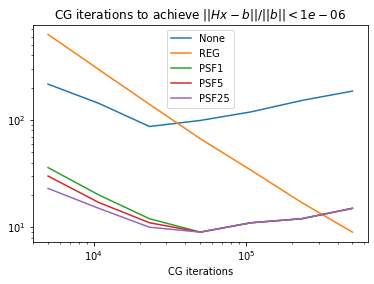

In [70]:
plt.loglog(all_gammas, num_iter_sweep_none)
plt.loglog(all_gammas, num_iter_sweep_reg)
for k in range(len(all_num_batches)):
    plt.loglog(all_gammas, all_num_iter_sweep[:,k])

plt.title(r'CG iterations to achieve $||Hx-b||/||b|| < ' + str(sweep_tol) + '$')
plt.xlabel(r'$\gamma$')
plt.xlabel('CG iterations')
plt.legend(['None', 'REG'] + ['PSF'+str(nb) for nb in all_num_batches])

# Plots to make (7):
 - Batches of impulse responses (Nick will do this, save as hi-res PNG)
 - H-matrix structure and block cluster tree

/home/nick/repos/nalger_helper_functions/nalger_helper_functions/plot_ellipse.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi
/tmp/ipykernel_5880/2805767550.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

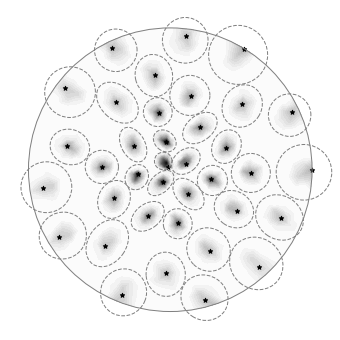

<Figure size 432x288 with 0 Axes>

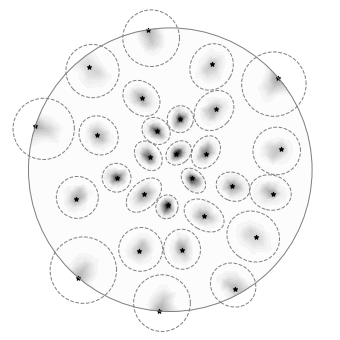

<Figure size 432x288 with 0 Axes>

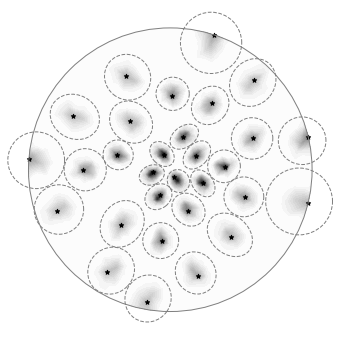

<Figure size 432x288 with 0 Axes>

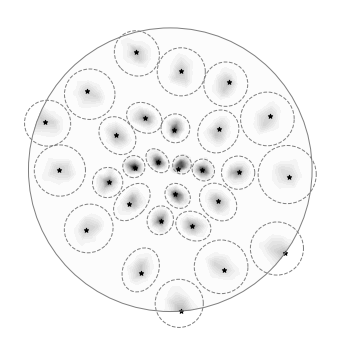

<Figure size 432x288 with 0 Axes>

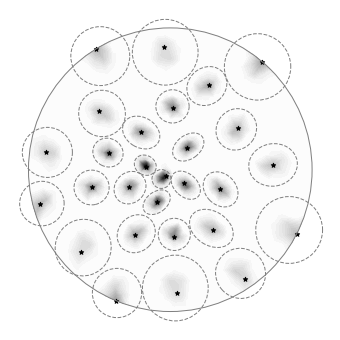

<Figure size 432x288 with 0 Axes>

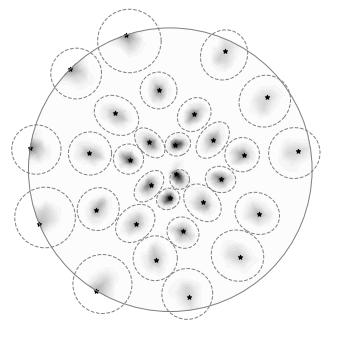

<Figure size 432x288 with 0 Axes>

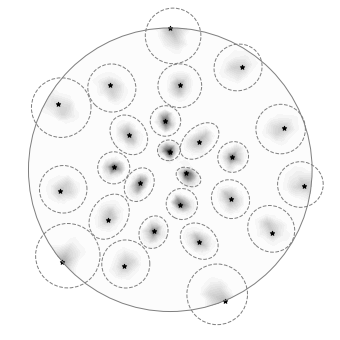

<Figure size 432x288 with 0 Axes>

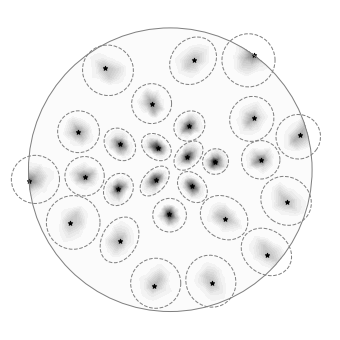

<Figure size 432x288 with 0 Axes>

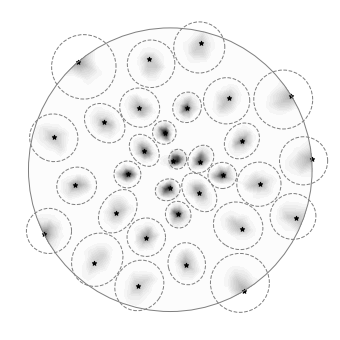

<Figure size 432x288 with 0 Axes>

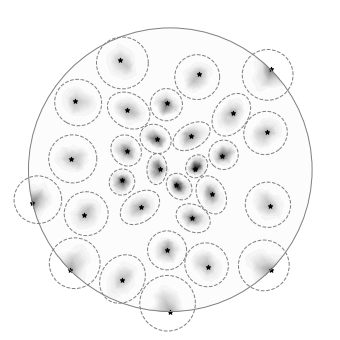

<Figure size 432x288 with 0 Axes>

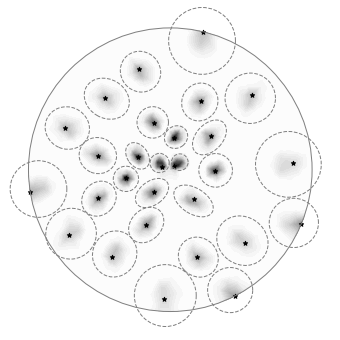

<Figure size 432x288 with 0 Axes>

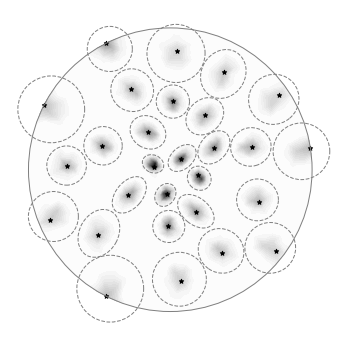

<Figure size 432x288 with 0 Axes>

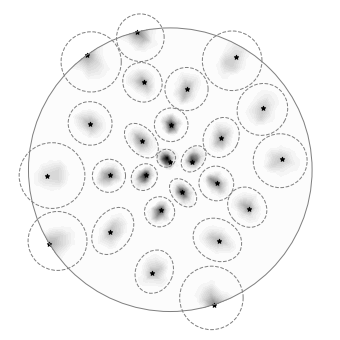

<Figure size 432x288 with 0 Axes>

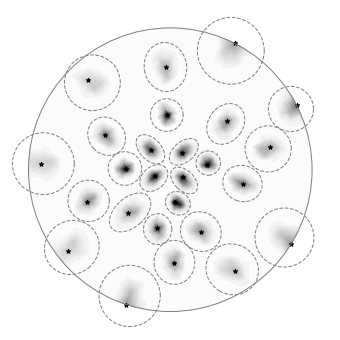

<Figure size 432x288 with 0 Axes>

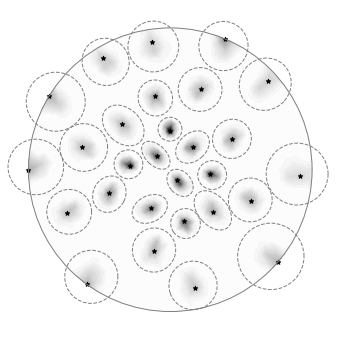

<Figure size 432x288 with 0 Axes>

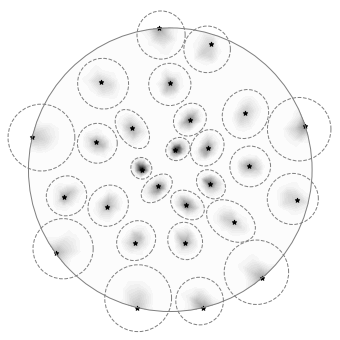

<Figure size 432x288 with 0 Axes>

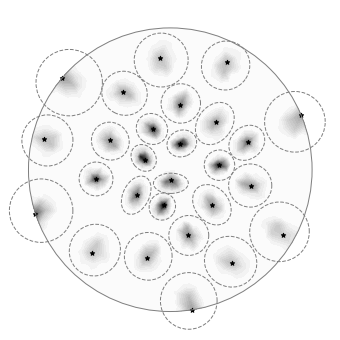

<Figure size 432x288 with 0 Axes>

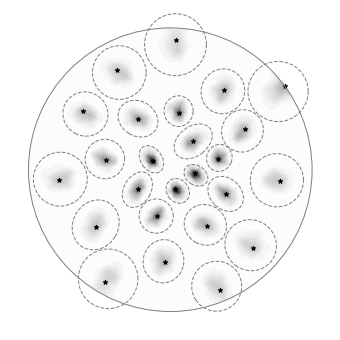

<Figure size 432x288 with 0 Axes>

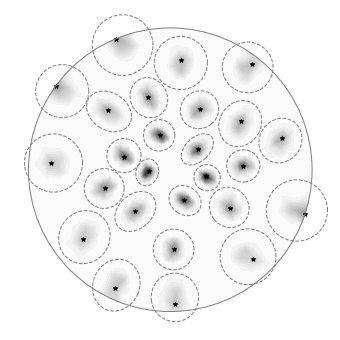

<Figure size 432x288 with 0 Axes>

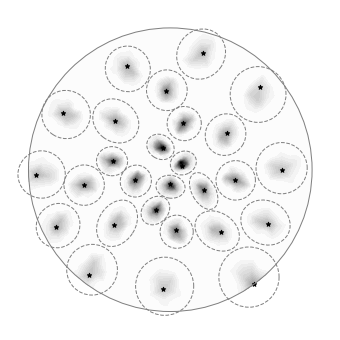

<Figure size 432x288 with 0 Axes>

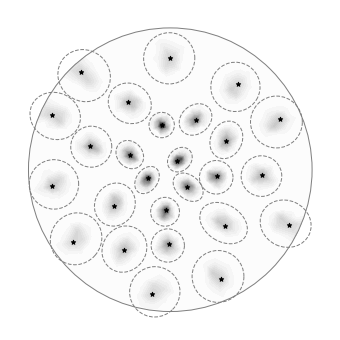

<Figure size 432x288 with 0 Axes>

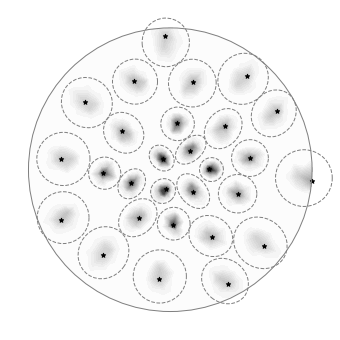

<Figure size 432x288 with 0 Axes>

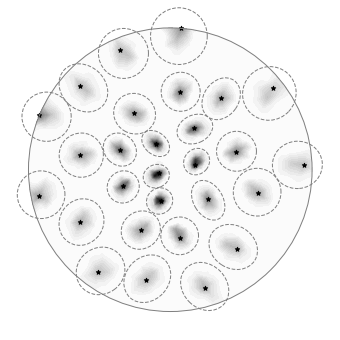

<Figure size 432x288 with 0 Axes>

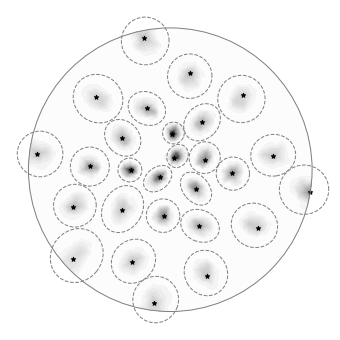

<Figure size 432x288 with 0 Axes>

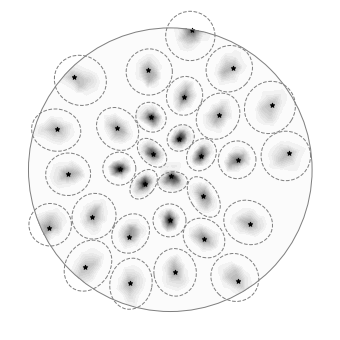

In [174]:
PCK = all_PCK[-1]
CB = PCK.col_batches

def plot_batch(b):
    phi = dl.Function(PCK.V_out)
    ff0 = CB.psi_vertex_batches[b]
    max_ff0 = np.max(ff0)
    ff = ff0.copy()
    ff = np.abs(ff)**1.0
    phi.vector()[CB.vertex2dof_out] = ff

    start = CB.batch2point_start[b]
    stop = CB.batch2point_stop[b]
    pp = CB.sample_points[start:stop, :]
    mu_batch = CB.sample_mu[start:stop, :]
    Sigma_batch = CB.sample_Sigma[start:stop, :, :]

    plt.figure(figsize=(6,6))

#     cm = dl.plot(phi, cmap='binary')
    cm = dl.plot(phi, cmap='gray_r')
#     cm = dl.plot(phi, cmap='jet_r')
#     cm = dl.plot(phi, cmap='jet')
#     cm = dl.plot(phi, cmap='turbo_r')
#     cm = dl.plot(phi, cmap='turbo')
#     cm = dl.plot(phi)
#     cm = dl.plot(phi, cmap='Greys_r')
#     cm = dl.plot(phi, cmap='Greys')
    # plt.colorbar(cm)

    plt.scatter(pp[:, 0], pp[:, 1], c='k', s=20, marker='*')
    # plt.scatter(mu_batch[:, 0], mu_batch[:, 1], c='k', s=3)

    plot_ellipse(np.zeros(2), (10000**2)*np.eye(2), n_std_tau=1,
             facecolor='none', edgecolor='gray', linewidth=1)

    for k in range(mu_batch.shape[0]):
        plot_ellipse(mu_batch[k, :], Sigma_batch[k, :, :], n_std_tau=CB.tau,
                     facecolor='none', edgecolor='gray', linewidth=1, linestyle='--')


    plt.xlim(-11500,11500)
    plt.ylim(-11500,11500)
    plt.axis('off')

for b in range(PCK.col_batches.num_batches):
    plt.figure()
    plot_batch(b)
    plt.savefig(save_dir_str + '/impulse_batch' + str(b) + '.png', bbox_inches='tight', dpi=200)

In [179]:
all_Hd_pch[-1].bct.visualize(save_dir_str + '/stokes_bct.eps')

In [182]:
# all_Hd_pch[-1].visualize(save_dir_str + '/stokes_Hd.eps')

In [184]:
Hd_lowtol = hpro.h_add(all_Hd_pch[-1], all_Hd_pch[-1], alpha=1.0, beta=0.0, rtol=1e-2, overwrite_B=False)
Hd_lowtol.visualize(save_dir_str + '/Hd_lowtol.eps')